In [1]:
import random
import os
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier
import lightgbm as lgb

import optuna
from optuna import Trial
from optuna.samplers import TPESampler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

import warnings

warnings.filterwarnings('ignore')

In [2]:
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

In [5]:
train = pd.read_csv('/work/home/ybchae/aimers/aimers_data/train.csv').drop(columns=['ID'])
test = pd.read_csv('/work/home/ybchae/aimers/aimers_data/test.csv').drop(columns=['ID'])
train.shape, test.shape

((256351, 68), (90067, 67))

In [6]:
train.head()

,시술 시기 코드,시술 당시 나이,임신 시도 또는 마지막 임신 경과 연수,시술 유형,특정 시술 유형,배란 자극 여부,배란 유도 유형,단일 배아 이식 여부,착상 전 유전 검사 사용 여부,착상 전 유전 진단 사용 여부,...,기증 배아 사용 여부,대리모 여부,PGD 시술 여부,PGS 시술 여부,난자 채취 경과일,난자 해동 경과일,난자 혼합 경과일,배아 이식 경과일,배아 해동 경과일,임신 성공 여부
0,TRZKPL,만18-34세,NaN,IVF,ICSI,1,기록되지 않은 시행,0.0,NaN,0.0,...,0.0,0.0,NaN,NaN,0.0,NaN,0.0,3.0,NaN,0
1,TRYBLT,만45-50세,NaN,IVF,ICSI,0,알 수 없음,0.0,NaN,0.0,...,0.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0
2,TRVNRY,만18-34세,NaN,IVF,IVF,1,기록되지 않은 시행,0.0,NaN,0.0,...,0.0,0.0,NaN,NaN,0.0,NaN,0.0,2.0,NaN,0
3,TRJXFG,만35-37세,NaN,IVF,ICSI,1,기록되지 않은 시행,0.0,NaN,0.0,...,0.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0
4,TRVNRY,만18-34세,NaN,IVF,ICSI,1,기록되지 않은 시행,0.0,NaN,0.0,...,0.0,0.0,NaN,NaN,0.0,NaN,0.0,3.0,NaN,0


In [7]:
train['임신 성공 여부'].value_counts()

0    190123
1     66228
Name: 임신 성공 여부, dtype: int64

In [8]:
# train['시술 당시 나이'] = train['시술 당시 나이'].replace('알 수 없음','만35-37세')
# test['시술 당시 나이'] = test['시술 당시 나이'].replace('알 수 없음','만35-37세')

train['시술 당시 나이'].value_counts()

만18-34세    102476
만35-37세     57780
만38-39세     39247
만40-42세     37348
만43-44세     12253
만45-50세      6918
알 수 없음        329
Name: 시술 당시 나이, dtype: int64

In [9]:
# drop_columns = ['착상 전 유전 검사 사용 여부',
#                 'PGD 시술 여부', 'PGS 시술 여부', '난자 해동 경과일'] + ['배란 유도 유형', '불임 원인 - 자궁경부 문제', '불임 원인 - 정자 면역학적 요인','불임 원인 - 정자 운동성', '불임 원인 - 정자 형태']#
drop_columns = ['난자 해동 경과일', '배란 유도 유형']
train.drop(columns=drop_columns, inplace=True)
test.drop(columns=drop_columns, inplace=True)

train.shape, test.shape

((256351, 66), (90067, 65))

In [10]:
nan_col_list = ['착상 전 유전 검사 사용 여부','PGD 시술 여부', 'PGS 시술 여부']
for col in nan_col_list:
    train[col] = train[col].fillna(0)
    test[col] = test[col].fillna(0)

In [11]:
drop_columns2 = []
for col in train.columns:
    if len(train[col].value_counts()) == 1:
        drop_columns2.append(col)

In [12]:
print(drop_columns2)
train.drop(columns=drop_columns2, inplace=True)
test.drop(columns=drop_columns2, inplace=True)

train.shape, test.shape

['불임 원인 - 여성 요인', '난자 채취 경과일']


((256351, 64), (90067, 63))

In [13]:
cat_to_int_dict = {'6회 이상' : 6, '5회' : 5, '4회' : 4, '3회' : 3, '2회' : 2, '1회' : 1, '0회' : 0}

cat_to_int_columns = ['총 시술 횟수', '클리닉 내 총 시술 횟수', 'IVF 시술 횟수','DI 시술 횟수', 'DI 임신 횟수' ,'DI 출산 횟수',
                      '총 임신 횟수', 'IVF 임신 횟수', '총 출산 횟수', 'IVF 출산 횟수'] #
for col in cat_to_int_columns:
    train[col] = train[col].map(cat_to_int_dict)
    test[col] = test[col].map(cat_to_int_dict)

In [14]:
procedure_encoding_dict = {'ICSI' : 'ICSI', 'IVF' : 'IVF', 'Unknown' : 'Unknown','IUI' : 'IUI',
                           'ICSI:ICSI' : 'ICSI', 'ICSI / BLASTOCYST ' : 'ICSI / BLASTOCYST',
                           'IVF / BLASTOCYST' : 'IVF / BLASTOCYST','IVF:IVF' : 'IVF','ICSI:IVF' : 'ICSI:IVF',
                           'ICSI / AH' : 'ICSI / AH','IVF:ICSI' : 'ICSI:IVF', 'IVF / AH' : 'IVF / AH',
                           'ICSI:Unknown' : 'ICSI', 'IVF:Unknown' : 'IVF', 'ICI' : 'ICI','Generic DI' : 'Generic DI',
                           'IVI' : 'IVI','ICSI / BLASTOCYST:IVF / BLASTOCYST' : 'ICSI / BLASTOCYST:IVF / BLASTOCYST',
                           'ICSI / BLASTOCYST :IVF / BLASTOCYST': 'ICSI / BLASTOCYST:IVF / BLASTOCYST','FER' : 'FER',
                           'IVF / AH:ICSI / AH' : 'IVF / AH:ICSI / AH','GIFT':'GIFT','ICSI / AH:Unknown' : 'ICSI / AH',
                           'ICSI / BLASTOCYST :ICSI' : 'ICSI / BLASTOCYST', 'IUI:ICI' : 'IUI:ICI',
                           'IVF:Unknown:Unknown:Unknown' : 'IVF'}

train['특정 시술 유형'] = train['특정 시술 유형'].map(procedure_encoding_dict)
test['특정 시술 유형'] = test['특정 시술 유형'].map(procedure_encoding_dict)

In [15]:
train['불임 원인 - 정자 요인'] = train['불임 원인 - 정자 면역학적 요인'] + train['불임 원인 - 정자 운동성'] + train['불임 원인 - 정자 농도']  + train['불임 원인 - 정자 형태']
test['불임 원인 - 정자 요인'] = test['불임 원인 - 정자 면역학적 요인'] + test['불임 원인 - 정자 운동성'] + test['불임 원인 - 정자 농도'] + test['불임 원인 - 정자 형태']
train['불임 원인 - 여성 요인'] = train['불임 원인 - 자궁경부 문제'] + train['불임 원인 - 자궁내막증'] + train['불임 원인 - 배란 장애'] + train['불임 원인 - 난관 질환']
test['불임 원인 - 여성 요인'] = test['불임 원인 - 자궁경부 문제'] + test['불임 원인 - 자궁내막증'] + test['불임 원인 - 배란 장애'] + test['불임 원인 - 난관 질환']

train['남성 불임 원인'] = train['남성 주 불임 원인'] + train['남성 부 불임 원인']
test['남성 불임 원인'] = test['남성 주 불임 원인'] + test['남성 부 불임 원인']
train['여성 불임 원인'] = train['여성 주 불임 원인'] + train['여성 부 불임 원인']
test['여성 불임 원인'] = test['여성 주 불임 원인'] + test['여성 부 불임 원인']
train['부부 불임 원인'] = train['부부 주 불임 원인'] + train['부부 부 불임 원인']
test['부부 불임 원인'] = test['부부 주 불임 원인'] + test['부부 부 불임 원인']


drop_columns3 = ['불임 원인 - 정자 면역학적 요인', '불임 원인 - 정자 운동성', '불임 원인 - 정자 형태', '불임 원인 - 자궁경부 문제',
                 '남성 주 불임 원인', '남성 부 불임 원인', '여성 주 불임 원인', '여성 부 불임 원인',
                 '부부 주 불임 원인', '부부 부 불임 원인']
train.drop(columns=drop_columns3, inplace=True)
test.drop(columns=drop_columns3, inplace=True)

In [104]:
train.columns

Index(['시술 시기 코드', '시술 당시 나이', '임신 시도 또는 마지막 임신 경과 연수', '시술 유형', '특정 시술 유형',
       '배란 자극 여부', '단일 배아 이식 여부', '착상 전 유전 검사 사용 여부', '착상 전 유전 진단 사용 여부',
       '불명확 불임 원인', '불임 원인 - 난관 질환', '불임 원인 - 남성 요인', '불임 원인 - 배란 장애',
       '불임 원인 - 자궁내막증', '불임 원인 - 정자 농도', '배아 생성 주요 이유', '총 시술 횟수',
       '클리닉 내 총 시술 횟수', 'IVF 시술 횟수', 'DI 시술 횟수', '총 임신 횟수', 'IVF 임신 횟수',
       'DI 임신 횟수', '총 출산 횟수', 'IVF 출산 횟수', 'DI 출산 횟수', '총 생성 배아 수',
       '미세주입된 난자 수', '미세주입에서 생성된 배아 수', '이식된 배아 수', '미세주입 배아 이식 수', '저장된 배아 수',
       '미세주입 후 저장된 배아 수', '해동된 배아 수', '해동 난자 수', '수집된 신선 난자 수', '저장된 신선 난자 수',
       '혼합된 난자 수', '파트너 정자와 혼합된 난자 수', '기증자 정자와 혼합된 난자 수', '난자 출처', '정자 출처',
       '난자 기증자 나이', '정자 기증자 나이', '동결 배아 사용 여부', '신선 배아 사용 여부', '기증 배아 사용 여부',
       '대리모 여부', 'PGD 시술 여부', 'PGS 시술 여부', '난자 혼합 경과일', '배아 이식 경과일',
       '배아 해동 경과일', '임신 성공 여부', '불임 원인 - 정자 요인', '불임 원인 - 여성 요인', '남성 불임 원인',
       '여성 불임 원인', '부부 불임 원인'],
      dtype='object')

In [16]:
# categorical_columns = ["시술 시기 코드","시술 당시 나이", "시술 유형", "특정 시술 유형","배란 자극 여부",
                      #  "단일 배아 이식 여부","착상 전 유전 진단 사용 여부",
                      #  "남성 주 불임 원인","남성 부 불임 원인","여성 주 불임 원인","여성 부 불임 원인",
                      #  "부부 주 불임 원인","부부 부 불임 원인","불명확 불임 원인","불임 원인 - 난관 질환",
                      #  "불임 원인 - 남성 요인","불임 원인 - 배란 장애","불임 원인 - 자궁경부 문제","불임 원인 - 자궁내막증",
                      #  "불임 원인 - 정자 농도","불임 원인 - 정자 면역학적 요인","불임 원인 - 정자 운동성","불임 원인 - 정자 형태",
                      #  "배아 생성 주요 이유","총 시술 횟수","클리닉 내 총 시술 횟수","IVF 시술 횟수","DI 시술 횟수",
                      #  "총 임신 횟수","IVF 임신 횟수","DI 임신 횟수","총 출산 횟수","IVF 출산 횟수","DI 출산 횟수",
                      #  "난자 출처","정자 출처","난자 기증자 나이","정자 기증자 나이",
                      #  "동결 배아 사용 여부","신선 배아 사용 여부","기증 배아 사용 여부","대리모 여부"]
categorical_columns =  ["시술 시기 코드","시술 당시 나이","시술 유형", "특정 시술 유형",
                        "배란 자극 여부", "단일 배아 이식 여부", '착상 전 유전 검사 사용 여부',"착상 전 유전 진단 사용 여부",
                       "불명확 불임 원인","배아 생성 주요 이유",
                        "불임 원인 - 난관 질환","불임 원인 - 남성 요인","불임 원인 - 배란 장애",
                        "불임 원인 - 자궁내막증",'불임 원인 - 정자 농도',"난자 출처","정자 출처","난자 기증자 나이","정자 기증자 나이",
                       "동결 배아 사용 여부","신선 배아 사용 여부", '기증 배아 사용 여부',"대리모 여부",
                        'PGD 시술 여부', 'PGS 시술 여부', '불임 원인 - 정자 요인', '불임 원인 - 여성 요인',  '남성 불임 원인', '여성 불임 원인', '부부 불임 원인'] #
# "남성 주 불임 원인","남성 부 불임 원인","여성 주 불임 원인","여성 부 불임 원인",
#                       "부부 주 불임 원인","부부 부 불임 원인",

for col in categorical_columns:
    if train[col].isna().sum() > 0 or test[col].isna().sum() > 0 :

      mode_value = train[col].mode()[0]
      train[col].fillna(mode_value, inplace=True)  # 최빈값으로 대체
      test[col].fillna(mode_value, inplace = True)
    train[col] = train[col].astype(str)
    test[col] = test[col].astype(str)
    #encoder = ce.OrdinalEncoder(handle_unknown='impute')
    #encoder.fit(train[col])
    #train[col] = encoder.transform(train[col])
    #test[col] = encoder.transform(test[col])

numeric_columns = [ '임신 시도 또는 마지막 임신 경과 연수',"총 시술 횟수","클리닉 내 총 시술 횟수","IVF 시술 횟수","DI 시술 횟수",
                   "총 임신 횟수","IVF 임신 횟수","DI 임신 횟수","총 출산 횟수","IVF 출산 횟수","DI 출산 횟수",
                    '총 생성 배아 수','미세주입된 난자 수', '미세주입에서 생성된 배아 수', '이식된 배아 수', '미세주입 배아 이식 수', '저장된 배아 수',
       '미세주입 후 저장된 배아 수', '해동된 배아 수', '해동 난자 수', '수집된 신선 난자 수', '저장된 신선 난자 수',
       '혼합된 난자 수', '파트너 정자와 혼합된 난자 수', '기증자 정자와 혼합된 난자 수', '난자 혼합 경과일', '배아 이식 경과일', '배아 해동 경과일'] #

# numeric_columns = ["총 생성 배아 수","미세주입된 난자 수","미세주입에서 생성된 배아 수",
#                    "이식된 배아 수","미세주입 배아 이식 수","저장된 배아 수","미세주입 후 저장된 배아 수",
#                    "수집된 신선 난자 수","혼합된 난자 수","파트너 정자와 혼합된 난자 수",
#                    "기증자 정자와 혼합된 난자 수","배아 이식 경과일"]

for col in numeric_columns:
  if train[col].isna().sum():
    if train[col].isna().sum() >= len(train)*0.5: # 결측치가 절반이 넘어갈 경우
      train[col].fillna(-1, inplace=True)  # -1로 대체
      test[col].fillna(-1, inplace = True)
    else:
      mode_value = train[col].mode()[0]  # 최빈값 구하기
      train[col].fillna(mode_value, inplace=True)  # 최빈값으로 대체
      test[col].fillna(mode_value, inplace = True)


In [17]:
len(categorical_columns) + len(numeric_columns)

58

In [18]:
def make_feature(df):
  #df['연령 가중치'] = df['시술 당시 나이'].map(age_weight_dict)

  #df['난자 활용률'] = df['미세주입된 난자 수'] / (df['수집된 신선 난자 수'] + df['해동 난자 수'] + 1)
  df['미세주입 배아 생성률'] = (df['미세주입에서 생성된 배아 수']) / (df['미세주입된 난자 수'] + 1)
  df['미세주입 배아 이식률'] = (df['미세주입 배아 이식 수']) / (df['미세주입에서 생성된 배아 수'] + 1)
  df['배아 이식률'] = (df['이식된 배아 수']) / (df['총 생성 배아 수'] + 1)
  df['저장 배아 비율'] = (df['저장된 배아 수'])/ (df['총 생성 배아 수'] + 1)
  df['해동 배아 생존율'] = (df['해동된 배아 수'])/ (df['총 생성 배아 수'] + 1)
  df['파트너 정자 혼합 비율'] = (df['파트너 정자와 혼합된 난자 수']) / (df['혼합된 난자 수'] + 1)

  # df['저장 배아 비율2'] = (df['저장된 배아 수'])/ (df['이식된 배아 수'] + 1)
  # df['해동 배아 생존율2'] = (df['해동된 배아 수'])/ (df['이식된 배아 수'] + 1)
  # df['미세주입 배아 이식 비율'] = df['미세주입 배아 이식 수'] / (df['이식된 배아 수'] + 1)
  #df['나이보정 배아 이식 수'] = df['이식된 배아 수']*df['연령 가중치']

  df['임신 성공률'] = (df['총 임신 횟수']) / (df['총 시술 횟수'] + 1)
  #df['IVF 시술 성공률'] = (df['IVF 임신 횟수'])/ (df['IVF 시술 횟수'] + 1)
  #df['DI 시술 성공률'] = (df['DI 임신 횟수']) / (df['DI 시술 횟수'] + 1)
  df['출산율'] = df['총 출산 횟수'] / (df['총 임신 횟수'] + 1)
  #df['IVF 출산율'] = df['IVF 출산 횟수'] / (df['IVF 임신 횟수'] + 1)
  #df['DI 출산율'] = df['DI 출산 횟수'] / (df['DI 임신 횟수'] + 1)
  #df['시술 기준 출산 성공률'] = df['총 출산 횟수'] / (df['총 시술 횟수'] + 1)

  #df = df.drop(columns = ['연령 가중치'])

  return df

In [19]:
X = train.drop('임신 성공 여부', axis=1)
y = train['임신 성공 여부']

X = make_feature(X)
test = make_feature(test)

X.shape, test.shape

((256351, 66), (90067, 66))

In [55]:
y.value_counts()

,count
임신 성공 여부,
0,190123
1,66228


In [98]:
from sklearn.utils.class_weight import compute_class_weight
def objective_cat(trial):
    global best_val_auc
    cbrm_param = {
        'iterations':trial.suggest_int("iterations", 1000, 3000),
        'depth':trial.suggest_int("depth", 4, 10),
        'learning_rate' : trial.suggest_float('learning_rate',0.005, 0.1),
        'l2_leaf_reg': trial.suggest_float("l2_leaf_reg", 1e-4, 100.0, log=True)
    }

    # Generate model
    model_cat = CatBoostClassifier(**cbrm_param, auto_class_weights='Balanced', eval_metric='AUC', random_state=seed, task_type="GPU")
    model_cat.fit(X_train,
          y_train,
          cat_features=categorical_columns,
          early_stopping_rounds= 300,
          eval_set=[(X_val,y_val)],
          verbose = 300)
    
    val_auc = model_cat.get_best_score()["validation"]["AUC"]
    best_model_path = "./weight/cat_fold_gpu{}.cbm".format(idx)
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        model_cat.save_model(best_model_path)
        print('저장 완료')

    return val_auc

def objective_lgbm(trial):

    lgbm_params = {
         #'num_leaves': trial.suggest_int('num_leaves', 2, 1024, step=1),
         #'max_depth': trial.suggest_int('max_depth', 3, 18, step=1),
        "objective":  trial.suggest_categorical("objective", ["binary"]),
         "metric":  trial.suggest_categorical("metric", ["auc"]),
         "random_state":  trial.suggest_int('random_state', 42, 42),
        "verbose":  trial.suggest_int('verbose', -1, -1),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 50, step=5, log=False),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0, step=0.1, log=False),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0, step=0.1, log=False),
    }

    # Generate model

    class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y), y=y_train)
    class_weight_dict = {i: w for i, w in enumerate(class_weights)}

    model_lgbm = lgb.LGBMClassifier(**lgbm_params, class_weight=class_weight_dict)

    model_lgbm.fit(X_train, y_train,eval_set=[(X_val, y_val)],categorical_feature=categorical_columns)

    return model_lgbm.best_score_['valid_0']['auc']

In [101]:
for col in X.columns:
    if X[col].dtype == 'object':  # 문자형이면 category로 변환
        X[col] = X[col].astype('category')
        test[col] = test[col].astype('category')
seed = 42

test_pred_total = []
scores_total = []
seed_everything(seed)
print('Seed {} Start!'.format(seed))
cv = StratifiedKFold(n_splits = 10, random_state = seed, shuffle=True)

cat_param_list = []
lgbm_param_list = []
for idx, (train_idx, val_idx) in enumerate(cv.split(X, y)):
    print('='*50)
    X_train, X_val = X.iloc[train_idx],X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    best_val_auc = 0

    sampler = TPESampler(seed=seed)
    optuna_cat = optuna.create_study(direction='maximize', sampler=sampler)
    optuna_cat.optimize(objective_cat, n_trials = 20)
    cat_trial = optuna_cat.best_trial
    cat_trial_params = cat_trial.params
    cat_param_list.append(cat_trial_params)
    
    model = CatBoostClassifier(**cat_trial_params, auto_class_weights='Balanced', eval_metric='AUC', random_state=seed, task_type="GPU" )
    model.load_model("./weight/cat_fold_gpu{}.cbm".format(idx))
    #model = CatBoostClassifier(auto_class_weights='Balanced', eval_metric='AUC', random_state=seed, task_type="CPU" )
    #model.fit(X_train,y_train,cat_features=categorical_columns,early_stopping_rounds = 300,eval_set=[(X_val,y_val)], verbose = 300)
    
    # model_gpu = CatBoostClassifier(auto_class_weights='Balanced',eval_metric='AUC', random_state = 501, task_type="GPU" )
    # model_gpu.fit(X_train,y_train,cat_features=categorical_columns, early_stopping_rounds = 300,eval_set=[(X_val,y_val)], verbose = 300)
    # model_gpu.save_model("cat_fold_{}.cbm".format(idx))


    # sampler = TPESampler(seed=seed)
    # optuna_lgbm = optuna.create_study(direction='maximize', sampler=sampler)
    # optuna_lgbm.optimize(objective_lgbm, n_trials = 20)
    # lgbm_trial = optuna_lgbm.best_trial
    # lgbm_trial_params = lgbm_trial.params
    # lgbm_param_list.append(lgbm_trial_params)
    lgbm_trial_params =loaded_lgbm_params[idx]
    #print(lgbm_trial_params)

    class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y), y=y_train)
    class_weight_dict = {i: w for i, w in enumerate(class_weights)}

    model_lgbm = lgb.LGBMClassifier(**lgbm_trial_params,class_weight=class_weight_dict)
    #model_lgbm= lgb.LGBMClassifier(objective = 'binary', metric = 'auc', random_state =  seed, class_weight=class_weight_dict)
    model_lgbm.fit(X_train, y_train, eval_set=[(X_val, y_val)],categorical_feature=categorical_columns)

    val_pred = model.predict_proba(X_val)[:, 1]
    val_pred_lgbm = model_lgbm.predict_proba(X_val)[:, 1]
    print('Cat val score : {}'.format(roc_auc_score(y_val,val_pred)))
    print('LGBM val score : {}'.format(roc_auc_score(y_val,val_pred_lgbm)))

    roc_val = roc_auc_score(y_val, (val_pred+val_pred_lgbm)/2)
    scores_total.append(roc_val)
    print('Ensemble val score : {}'.format(roc_val))

    test_pred = model.predict_proba(test)[:, 1]
    test_pred_lgbm = model_lgbm.predict_proba(test)[:, 1]
    test_pred_total.append((test_pred+test_pred_lgbm)/2)

[I 2025-02-17 15:07:23,696] A new study created in memory with name: no-name-eaf20120-1c68-4303-b1c6-4d80b8b97199


Seed 42 Start!


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7326191	best: 0.7326191 (0)	total: 72.1ms	remaining: 2m 6s
300:	test: 0.7386052	best: 0.7423840 (81)	total: 19.8s	remaining: 1m 35s
bestTest = 0.7423840165
bestIteration = 81
Shrink model to first 82 iterations.


[I 2025-02-17 15:07:50,165] Trial 0 finished with value: 0.7423840165138245 and parameters: {'iterations': 1749, 'depth': 10, 'learning_rate': 0.07453942447208349, 'l2_leaf_reg': 0.39079671568228835}. Best is trial 0 with value: 0.7423840165138245.


저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7178718	best: 0.7178718 (0)	total: 14.8ms	remaining: 19.4s
300:	test: 0.7385333	best: 0.7385333 (300)	total: 4.09s	remaining: 13.7s
600:	test: 0.7413220	best: 0.7413220 (600)	total: 8.16s	remaining: 9.66s
900:	test: 0.7422114	best: 0.7422114 (900)	total: 12.2s	remaining: 5.56s
1200:	test: 0.7428088	best: 0.7428093 (1199)	total: 16.2s	remaining: 1.5s
1311:	test: 0.7429550	best: 0.7429576 (1310)	total: 17.7s	remaining: 0us
bestTest = 0.742957592
bestIteration = 1310
Shrink model to first 1311 iterations.


[I 2025-02-17 15:08:09,417] Trial 1 finished with value: 0.742957592010498 and parameters: {'iterations': 1312, 'depth': 5, 'learning_rate': 0.010517943155978949, 'l2_leaf_reg': 15.741890047456648}. Best is trial 1 with value: 0.742957592010498.


저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7309370	best: 0.7309370 (0)	total: 30.6ms	remaining: 1m 7s
300:	test: 0.7398137	best: 0.7398137 (300)	total: 8.82s	remaining: 55.7s
600:	test: 0.7422290	best: 0.7422290 (600)	total: 17.5s	remaining: 46.6s
900:	test: 0.7431483	best: 0.7431493 (899)	total: 26.2s	remaining: 37.8s
1200:	test: 0.7436026	best: 0.7436026 (1200)	total: 34.9s	remaining: 29s
1500:	test: 0.7437961	best: 0.7437984 (1490)	total: 43.5s	remaining: 20.3s
1800:	test: 0.7439618	best: 0.7439618 (1800)	total: 52.2s	remaining: 11.6s
2100:	test: 0.7440287	best: 0.7440558 (2037)	total: 1m	remaining: 2.92s
2201:	test: 0.7440627	best: 0.7440627 (2201)	total: 1m 3s	remaining: 0us
bestTest = 0.7440626621
bestIteration = 2201


[I 2025-02-17 15:09:14,841] Trial 2 finished with value: 0.7440626621246338 and parameters: {'iterations': 2202, 'depth': 8, 'learning_rate': 0.006955526958101232, 'l2_leaf_reg': 65.98711072054076}. Best is trial 2 with value: 0.7440626621246338.


저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7178745	best: 0.7178745 (0)	total: 13.7ms	remaining: 36.6s
300:	test: 0.7414447	best: 0.7414456 (299)	total: 3.92s	remaining: 30.8s
600:	test: 0.7428034	best: 0.7428124 (599)	total: 7.94s	remaining: 27.3s
900:	test: 0.7432390	best: 0.7432396 (898)	total: 11.8s	remaining: 23.2s
1200:	test: 0.7433866	best: 0.7434530 (1094)	total: 15.8s	remaining: 19.3s
1500:	test: 0.7434335	best: 0.7435814 (1362)	total: 19.7s	remaining: 15.3s
bestTest = 0.7435813546
bestIteration = 1362
Shrink model to first 1363 iterations.


[I 2025-02-17 15:09:38,118] Trial 3 finished with value: 0.7435813546180725 and parameters: {'iterations': 2665, 'depth': 5, 'learning_rate': 0.02227337188467456, 'l2_leaf_reg': 0.0012601639723276807}. Best is trial 2 with value: 0.7440626621246338.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7275189	best: 0.7275189 (0)	total: 22.2ms	remaining: 35.6s
300:	test: 0.7434482	best: 0.7436951 (272)	total: 6.43s	remaining: 27.9s
bestTest = 0.7436951399
bestIteration = 272
Shrink model to first 273 iterations.


[I 2025-02-17 15:09:51,825] Trial 4 finished with value: 0.7436951398849487 and parameters: {'iterations': 1608, 'depth': 7, 'learning_rate': 0.046034776771001, 'l2_leaf_reg': 0.005589524205217926}. Best is trial 2 with value: 0.7440626621246338.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7159628	best: 0.7159628 (0)	total: 11.3ms	remaining: 25s
300:	test: 0.7417810	best: 0.7417810 (300)	total: 3.17s	remaining: 20.3s
600:	test: 0.7430221	best: 0.7430284 (587)	total: 6.29s	remaining: 17s
900:	test: 0.7434285	best: 0.7434384 (890)	total: 9.43s	remaining: 13.8s
1200:	test: 0.7435890	best: 0.7436614 (1051)	total: 12.6s	remaining: 10.7s
1500:	test: 0.7437296	best: 0.7437653 (1420)	total: 15.7s	remaining: 7.58s
1800:	test: 0.7437626	best: 0.7437704 (1797)	total: 18.9s	remaining: 4.44s
2100:	test: 0.7437152	best: 0.7437965 (1971)	total: 22.1s	remaining: 1.29s
2223:	test: 0.7437206	best: 0.7437965 (1971)	total: 23.4s	remaining: 0us
bestTest = 0.7437964678
bestIteration = 1971
Shrink model to first 1972 iterations.


[I 2025-02-17 15:10:16,760] Trial 5 finished with value: 0.7437964677810669 and parameters: {'iterations': 2224, 'depth': 4, 'learning_rate': 0.032753741610845724, 'l2_leaf_reg': 0.01578232781079559}. Best is trial 2 with value: 0.7440626621246338.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7334892	best: 0.7334892 (0)	total: 42.1ms	remaining: 1m 20s
300:	test: 0.7429585	best: 0.7429714 (294)	total: 12.8s	remaining: 1m 8s
600:	test: 0.7425097	best: 0.7431923 (452)	total: 25.5s	remaining: 55.7s
bestTest = 0.7431922555
bestIteration = 452
Shrink model to first 453 iterations.


[I 2025-02-17 15:10:50,304] Trial 6 finished with value: 0.7431922554969788 and parameters: {'iterations': 1912, 'depth': 9, 'learning_rate': 0.023969009305044177, 'l2_leaf_reg': 0.12173252504194051}. Best is trial 2 with value: 0.7440626621246338.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7159628	best: 0.7159628 (0)	total: 11.2ms	remaining: 24.5s
300:	test: 0.7426773	best: 0.7426848 (299)	total: 3.12s	remaining: 19.5s
600:	test: 0.7430896	best: 0.7431107 (594)	total: 6.24s	remaining: 16.5s
900:	test: 0.7432907	best: 0.7433266 (828)	total: 9.41s	remaining: 13.4s
1200:	test: 0.7431822	best: 0.7433403 (1039)	total: 12.6s	remaining: 10.3s


[I 2025-02-17 15:11:05,746] Trial 7 finished with value: 0.743340253829956 and parameters: {'iterations': 2185, 'depth': 4, 'learning_rate': 0.06271676093063665, 'l2_leaf_reg': 0.0010547383621352044}. Best is trial 2 with value: 0.7440626621246338.


bestTest = 0.7433402538
bestIteration = 1039
Shrink model to first 1040 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7326830	best: 0.7326830 (0)	total: 65.2ms	remaining: 1m 13s
300:	test: 0.7389760	best: 0.7423972 (91)	total: 19.9s	remaining: 54.7s
bestTest = 0.7423972487
bestIteration = 91
Shrink model to first 92 iterations.


[I 2025-02-17 15:11:33,231] Trial 8 finished with value: 0.7423972487449646 and parameters: {'iterations': 1130, 'depth': 10, 'learning_rate': 0.09673504314208314, 'l2_leaf_reg': 7.085721663941605}. Best is trial 2 with value: 0.7440626621246338.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7159628	best: 0.7159628 (0)	total: 11.2ms	remaining: 18s
300:	test: 0.7427149	best: 0.7427154 (299)	total: 3.19s	remaining: 13.9s
600:	test: 0.7430345	best: 0.7431744 (550)	total: 6.41s	remaining: 10.7s


[I 2025-02-17 15:11:43,799] Trial 9 finished with value: 0.7431744039058685 and parameters: {'iterations': 1609, 'depth': 4, 'learning_rate': 0.07000213751865492, 'l2_leaf_reg': 0.04374364439939081}. Best is trial 2 with value: 0.7440626621246338.


bestTest = 0.7431744039
bestIteration = 550
Shrink model to first 551 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7309179	best: 0.7309179 (0)	total: 29.8ms	remaining: 1m 26s
300:	test: 0.7390426	best: 0.7390426 (300)	total: 8.74s	remaining: 1m 15s
600:	test: 0.7415744	best: 0.7415744 (600)	total: 17.5s	remaining: 1m 7s
900:	test: 0.7426945	best: 0.7426945 (900)	total: 26.2s	remaining: 58.4s
1200:	test: 0.7432612	best: 0.7432612 (1200)	total: 35.1s	remaining: 49.8s
1500:	test: 0.7435557	best: 0.7435557 (1500)	total: 43.9s	remaining: 41.1s
1800:	test: 0.7437706	best: 0.7437735 (1799)	total: 52.7s	remaining: 32.4s
2100:	test: 0.7439066	best: 0.7439066 (2100)	total: 1m 1s	remaining: 23.7s
2400:	test: 0.7440476	best: 0.7440478 (2399)	total: 1m 10s	remaining: 14.9s
2700:	test: 0.7440615	best: 0.7440905 (2640)	total: 1m 19s	remaining: 6.06s
2907:	test: 0.7440331	best: 0.7440905 (2640)	total: 1m 25s	remaining: 0us
bestTest = 0.7440904975
bestIteration = 2640
Shrink model to first 2641 iterations.


[I 2025-02-17 15:13:10,667] Trial 10 finished with value: 0.7440904974937439 and parameters: {'iterations': 2908, 'depth': 8, 'learning_rate': 0.005716995335047832, 'l2_leaf_reg': 53.77119408946009}. Best is trial 10 with value: 0.7440904974937439.


저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7309391	best: 0.7309391 (0)	total: 30.6ms	remaining: 1m 29s
300:	test: 0.7394030	best: 0.7394030 (300)	total: 8.67s	remaining: 1m 15s
600:	test: 0.7420157	best: 0.7420157 (600)	total: 17.3s	remaining: 1m 7s
900:	test: 0.7430373	best: 0.7430398 (899)	total: 26.1s	remaining: 58.7s
1200:	test: 0.7435116	best: 0.7435116 (1199)	total: 34.8s	remaining: 50.1s
1500:	test: 0.7437714	best: 0.7437714 (1500)	total: 43.5s	remaining: 41.4s
1800:	test: 0.7439461	best: 0.7439461 (1800)	total: 52.4s	remaining: 32.8s
2100:	test: 0.7440207	best: 0.7440246 (2094)	total: 1m 1s	remaining: 24.2s
2400:	test: 0.7440570	best: 0.7440668 (2250)	total: 1m 9s	remaining: 15.4s
2700:	test: 0.7441172	best: 0.7441303 (2675)	total: 1m 18s	remaining: 6.67s
2929:	test: 0.7441504	best: 0.7441648 (2799)	total: 1m 25s	remaining: 0us
bestTest = 0.7441648245
bestIteration = 2799
Shrink model to first 2800 iterations.


[I 2025-02-17 15:14:37,669] Trial 11 finished with value: 0.7441648244857788 and parameters: {'iterations': 2930, 'depth': 8, 'learning_rate': 0.006402408540446867, 'l2_leaf_reg': 83.11832707510945}. Best is trial 11 with value: 0.7441648244857788.


저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7275186	best: 0.7275186 (0)	total: 24.4ms	remaining: 1m 11s
300:	test: 0.7435147	best: 0.7435147 (300)	total: 6.61s	remaining: 57.9s
600:	test: 0.7435814	best: 0.7438276 (468)	total: 13s	remaining: 50.8s
bestTest = 0.743827641
bestIteration = 468
Shrink model to first 469 iterations.


[I 2025-02-17 15:14:55,750] Trial 12 finished with value: 0.7438276410102844 and parameters: {'iterations': 2941, 'depth': 7, 'learning_rate': 0.04193178467290181, 'l2_leaf_reg': 1.5372567535251158}. Best is trial 11 with value: 0.7441648244857788.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7309371	best: 0.7309371 (0)	total: 29.7ms	remaining: 1m 18s
300:	test: 0.7402943	best: 0.7402943 (300)	total: 8.7s	remaining: 1m 7s
600:	test: 0.7425278	best: 0.7425278 (600)	total: 17.3s	remaining: 58.6s
900:	test: 0.7432965	best: 0.7433011 (892)	total: 26.1s	remaining: 50.2s
1200:	test: 0.7436733	best: 0.7436752 (1199)	total: 35s	remaining: 41.9s
1500:	test: 0.7437899	best: 0.7437943 (1478)	total: 43.8s	remaining: 33.2s
1800:	test: 0.7439582	best: 0.7439615 (1794)	total: 52.5s	remaining: 24.4s
2100:	test: 0.7440108	best: 0.7440359 (2027)	total: 1m 1s	remaining: 15.6s
bestTest = 0.7440359294
bestIteration = 2027
Shrink model to first 2028 iterations.


[I 2025-02-17 15:16:05,263] Trial 13 finished with value: 0.744035929441452 and parameters: {'iterations': 2638, 'depth': 8, 'learning_rate': 0.007940569964231542, 'l2_leaf_reg': 65.5477287928456}. Best is trial 11 with value: 0.7441648244857788.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7309763	best: 0.7309763 (0)	total: 29.2ms	remaining: 1m 27s
300:	test: 0.7429859	best: 0.7429859 (300)	total: 8.75s	remaining: 1m 18s
600:	test: 0.7435730	best: 0.7436662 (554)	total: 17.5s	remaining: 1m 9s
bestTest = 0.7436662018
bestIteration = 554
Shrink model to first 555 iterations.


[I 2025-02-17 15:16:31,475] Trial 14 finished with value: 0.7436662018299103 and parameters: {'iterations': 2990, 'depth': 8, 'learning_rate': 0.02191927121203297, 'l2_leaf_reg': 3.4437900071734107}. Best is trial 11 with value: 0.7441648244857788.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7217555	best: 0.7217555 (0)	total: 20.4ms	remaining: 52.8s
300:	test: 0.7428099	best: 0.7428140 (298)	total: 5.89s	remaining: 44.7s
600:	test: 0.7436487	best: 0.7436487 (600)	total: 11s	remaining: 36.4s
900:	test: 0.7437299	best: 0.7437930 (857)	total: 16.1s	remaining: 30s
1200:	test: 0.7437578	best: 0.7438198 (991)	total: 21.1s	remaining: 24.3s
1500:	test: 0.7437145	best: 0.7438427 (1282)	total: 26.1s	remaining: 18.8s
bestTest = 0.743842721
bestIteration = 1282
Shrink model to first 1283 iterations.


[I 2025-02-17 15:17:00,475] Trial 15 finished with value: 0.7438427209854126 and parameters: {'iterations': 2583, 'depth': 6, 'learning_rate': 0.02963805491728204, 'l2_leaf_reg': 0.8243036091063639}. Best is trial 11 with value: 0.7441648244857788.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7336274	best: 0.7336274 (0)	total: 42.4ms	remaining: 1m 41s
300:	test: 0.7426794	best: 0.7426794 (300)	total: 12.8s	remaining: 1m 29s
600:	test: 0.7437927	best: 0.7437927 (600)	total: 25.5s	remaining: 1m 16s
900:	test: 0.7440704	best: 0.7440709 (899)	total: 38.3s	remaining: 1m 3s
1200:	test: 0.7441164	best: 0.7441478 (1070)	total: 51s	remaining: 51.1s
bestTest = 0.7441478372
bestIteration = 1070
Shrink model to first 1071 iterations.


[I 2025-02-17 15:18:00,366] Trial 16 finished with value: 0.7441478371620178 and parameters: {'iterations': 2403, 'depth': 9, 'learning_rate': 0.015196777855232777, 'l2_leaf_reg': 94.64533014403676}. Best is trial 11 with value: 0.7441648244857788.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7335311	best: 0.7335311 (0)	total: 42.4ms	remaining: 1m 43s
300:	test: 0.7431229	best: 0.7431229 (300)	total: 12.9s	remaining: 1m 31s
600:	test: 0.7439895	best: 0.7439909 (597)	total: 25.7s	remaining: 1m 19s
900:	test: 0.7439317	best: 0.7441171 (710)	total: 38.5s	remaining: 1m 6s
bestTest = 0.7441170812
bestIteration = 710
Shrink model to first 711 iterations.


[I 2025-02-17 15:18:45,037] Trial 17 finished with value: 0.7441170811653137 and parameters: {'iterations': 2448, 'depth': 9, 'learning_rate': 0.01706356018010325, 'l2_leaf_reg': 11.764065887527059}. Best is trial 11 with value: 0.7441648244857788.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7336257	best: 0.7336257 (0)	total: 42.3ms	remaining: 1m 44s
300:	test: 0.7438811	best: 0.7439031 (296)	total: 12.8s	remaining: 1m 32s
600:	test: 0.7436440	best: 0.7439721 (333)	total: 25.5s	remaining: 1m 19s
bestTest = 0.7439721227
bestIteration = 333
Shrink model to first 334 iterations.


[I 2025-02-17 15:19:13,445] Trial 18 finished with value: 0.74397212266922 and parameters: {'iterations': 2478, 'depth': 9, 'learning_rate': 0.03721319326346145, 'l2_leaf_reg': 98.56235002614817}. Best is trial 11 with value: 0.7441648244857788.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7326192	best: 0.7326192 (0)	total: 65.7ms	remaining: 3m 2s
300:	test: 0.7407184	best: 0.7420758 (130)	total: 20.2s	remaining: 2m 45s
bestTest = 0.7420758009
bestIteration = 130
Shrink model to first 131 iterations.


[I 2025-02-17 15:19:43,858] Trial 19 finished with value: 0.7420758008956909 and parameters: {'iterations': 2772, 'depth': 10, 'learning_rate': 0.0526711296023181, 'l2_leaf_reg': 0.18304865137789625}. Best is trial 11 with value: 0.7441648244857788.


Cat val score : 0.7441647620187619
LGBM val score : 0.7439849578352579
Ensemble val score : 0.7443275439083659


[I 2025-02-17 15:19:57,744] A new study created in memory with name: no-name-e4c9c2b0-d31d-4146-bce9-e9ef16449e49


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7213705	best: 0.7213705 (0)	total: 74.2ms	remaining: 2m 9s
300:	test: 0.7261553	best: 0.7309427 (93)	total: 20.1s	remaining: 1m 36s
bestTest = 0.7309426665
bestIteration = 93
Shrink model to first 94 iterations.


[I 2025-02-17 15:20:25,204] Trial 0 finished with value: 0.7309426665306091 and parameters: {'iterations': 1749, 'depth': 10, 'learning_rate': 0.07453942447208349, 'l2_leaf_reg': 0.39079671568228835}. Best is trial 0 with value: 0.7309426665306091.


저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7034566	best: 0.7034566 (0)	total: 14.1ms	remaining: 18.5s
300:	test: 0.7271377	best: 0.7271377 (300)	total: 3.97s	remaining: 13.3s
600:	test: 0.7301401	best: 0.7301401 (600)	total: 8.2s	remaining: 9.7s
900:	test: 0.7313224	best: 0.7313224 (900)	total: 12.4s	remaining: 5.68s
1200:	test: 0.7320054	best: 0.7320058 (1199)	total: 16.6s	remaining: 1.53s
1311:	test: 0.7321984	best: 0.7321984 (1311)	total: 18.1s	remaining: 0us
bestTest = 0.7321983576
bestIteration = 1311


[I 2025-02-17 15:20:44,793] Trial 1 finished with value: 0.7321983575820923 and parameters: {'iterations': 1312, 'depth': 5, 'learning_rate': 0.010517943155978949, 'l2_leaf_reg': 15.741890047456648}. Best is trial 1 with value: 0.7321983575820923.


저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7204369	best: 0.7204369 (0)	total: 29.5ms	remaining: 1m 4s
300:	test: 0.7282984	best: 0.7282984 (300)	total: 8.82s	remaining: 55.7s
600:	test: 0.7305775	best: 0.7305775 (600)	total: 18s	remaining: 48s
900:	test: 0.7315427	best: 0.7315427 (900)	total: 26.9s	remaining: 38.8s
1200:	test: 0.7320523	best: 0.7320591 (1198)	total: 35.9s	remaining: 29.9s
1500:	test: 0.7323671	best: 0.7323671 (1500)	total: 44.8s	remaining: 20.9s
1800:	test: 0.7325395	best: 0.7325395 (1800)	total: 53.7s	remaining: 12s
2100:	test: 0.7325636	best: 0.7325813 (2050)	total: 1m 2s	remaining: 3.01s
2201:	test: 0.7325931	best: 0.7325931 (2201)	total: 1m 5s	remaining: 0us
bestTest = 0.7325930595
bestIteration = 2201


[I 2025-02-17 15:21:51,953] Trial 2 finished with value: 0.7325930595397949 and parameters: {'iterations': 2202, 'depth': 8, 'learning_rate': 0.006955526958101232, 'l2_leaf_reg': 65.98711072054076}. Best is trial 2 with value: 0.7325930595397949.


저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7034329	best: 0.7034329 (0)	total: 14.6ms	remaining: 38.8s
300:	test: 0.7303464	best: 0.7303464 (300)	total: 4.13s	remaining: 32.5s
600:	test: 0.7319472	best: 0.7319480 (599)	total: 8.33s	remaining: 28.6s
900:	test: 0.7326781	best: 0.7327085 (891)	total: 12.3s	remaining: 24.1s
1200:	test: 0.7329500	best: 0.7329759 (1111)	total: 16.3s	remaining: 19.9s
1500:	test: 0.7328671	best: 0.7329826 (1329)	total: 20.3s	remaining: 15.7s
bestTest = 0.7329826355
bestIteration = 1329
Shrink model to first 1330 iterations.


[I 2025-02-17 15:22:15,368] Trial 3 finished with value: 0.7329826354980469 and parameters: {'iterations': 2665, 'depth': 5, 'learning_rate': 0.02227337188467456, 'l2_leaf_reg': 0.0012601639723276807}. Best is trial 3 with value: 0.7329826354980469.


저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7160500	best: 0.7160500 (0)	total: 24.3ms	remaining: 39s
300:	test: 0.7321786	best: 0.7322186 (247)	total: 6.96s	remaining: 30.2s
600:	test: 0.7314774	best: 0.7322544 (309)	total: 13.6s	remaining: 22.7s
bestTest = 0.7322543561
bestIteration = 309
Shrink model to first 310 iterations.


[I 2025-02-17 15:22:30,809] Trial 4 finished with value: 0.7322543561458588 and parameters: {'iterations': 1608, 'depth': 7, 'learning_rate': 0.046034776771001, 'l2_leaf_reg': 0.005589524205217926}. Best is trial 3 with value: 0.7329826354980469.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7013710	best: 0.7013710 (0)	total: 11.4ms	remaining: 25.3s
300:	test: 0.7304132	best: 0.7304132 (300)	total: 3.22s	remaining: 20.6s
600:	test: 0.7320269	best: 0.7320269 (600)	total: 6.38s	remaining: 17.2s
900:	test: 0.7326801	best: 0.7327024 (885)	total: 9.56s	remaining: 14s
1200:	test: 0.7329098	best: 0.7329541 (1132)	total: 12.7s	remaining: 10.8s
1500:	test: 0.7329120	best: 0.7329779 (1267)	total: 15.9s	remaining: 7.67s
bestTest = 0.7329778969
bestIteration = 1267
Shrink model to first 1268 iterations.


[I 2025-02-17 15:22:48,896] Trial 5 finished with value: 0.7329778969287872 and parameters: {'iterations': 2224, 'depth': 4, 'learning_rate': 0.032753741610845724, 'l2_leaf_reg': 0.01578232781079559}. Best is trial 3 with value: 0.7329826354980469.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7218685	best: 0.7218685 (0)	total: 43.2ms	remaining: 1m 22s
300:	test: 0.7310558	best: 0.7310674 (298)	total: 12.9s	remaining: 1m 8s
600:	test: 0.7308141	best: 0.7311600 (369)	total: 25.7s	remaining: 56s
bestTest = 0.7311600447
bestIteration = 369
Shrink model to first 370 iterations.


[I 2025-02-17 15:23:19,077] Trial 6 finished with value: 0.731160044670105 and parameters: {'iterations': 1912, 'depth': 9, 'learning_rate': 0.023969009305044177, 'l2_leaf_reg': 0.12173252504194051}. Best is trial 3 with value: 0.7329826354980469.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7013710	best: 0.7013710 (0)	total: 11.7ms	remaining: 25.5s
300:	test: 0.7320350	best: 0.7320531 (297)	total: 3.18s	remaining: 19.9s
600:	test: 0.7325392	best: 0.7326072 (571)	total: 6.35s	remaining: 16.7s


[I 2025-02-17 15:23:29,746] Trial 7 finished with value: 0.7326071858406067 and parameters: {'iterations': 2185, 'depth': 4, 'learning_rate': 0.06271676093063665, 'l2_leaf_reg': 0.0010547383621352044}. Best is trial 3 with value: 0.7329826354980469.


bestTest = 0.7326071858
bestIteration = 571
Shrink model to first 572 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7214071	best: 0.7214071 (0)	total: 65.9ms	remaining: 1m 14s
300:	test: 0.7268719	best: 0.7307761 (75)	total: 19.9s	remaining: 54.8s
bestTest = 0.7307761014
bestIteration = 75
Shrink model to first 76 iterations.


[I 2025-02-17 15:23:56,208] Trial 8 finished with value: 0.7307761013507843 and parameters: {'iterations': 1130, 'depth': 10, 'learning_rate': 0.09673504314208314, 'l2_leaf_reg': 7.085721663941605}. Best is trial 3 with value: 0.7329826354980469.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7013710	best: 0.7013710 (0)	total: 11.3ms	remaining: 18.1s
300:	test: 0.7319374	best: 0.7319604 (286)	total: 3.17s	remaining: 13.8s
600:	test: 0.7325311	best: 0.7325442 (585)	total: 6.35s	remaining: 10.7s
900:	test: 0.7324783	best: 0.7325567 (845)	total: 9.56s	remaining: 7.51s


[I 2025-02-17 15:24:09,810] Trial 9 finished with value: 0.7325567305088043 and parameters: {'iterations': 1609, 'depth': 4, 'learning_rate': 0.07000213751865492, 'l2_leaf_reg': 0.04374364439939081}. Best is trial 3 with value: 0.7329826354980469.


bestTest = 0.7325567305
bestIteration = 845
Shrink model to first 846 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7100796	best: 0.7100796 (0)	total: 19.3ms	remaining: 55.9s
300:	test: 0.7316126	best: 0.7316568 (296)	total: 5.17s	remaining: 44.5s
600:	test: 0.7319226	best: 0.7319871 (522)	total: 10.2s	remaining: 39s
900:	test: 0.7319300	best: 0.7320326 (877)	total: 15.3s	remaining: 33.8s
1200:	test: 0.7314143	best: 0.7320383 (925)	total: 20.4s	remaining: 28.7s
bestTest = 0.7320383191
bestIteration = 925
Shrink model to first 926 iterations.


[I 2025-02-17 15:24:32,153] Trial 10 finished with value: 0.7320383191108704 and parameters: {'iterations': 2891, 'depth': 6, 'learning_rate': 0.04002923340850424, 'l2_leaf_reg': 0.000128165534691859}. Best is trial 3 with value: 0.7329826354980469.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7034329	best: 0.7034329 (0)	total: 14.6ms	remaining: 38.5s
300:	test: 0.7312520	best: 0.7312520 (300)	total: 4.05s	remaining: 31.5s
600:	test: 0.7324081	best: 0.7324081 (600)	total: 8.02s	remaining: 27.2s
900:	test: 0.7328346	best: 0.7328440 (880)	total: 12s	remaining: 23.1s
1200:	test: 0.7329086	best: 0.7329661 (1104)	total: 15.9s	remaining: 19.1s
bestTest = 0.7329660654
bestIteration = 1104
Shrink model to first 1105 iterations.


[I 2025-02-17 15:24:52,293] Trial 11 finished with value: 0.7329660654067993 and parameters: {'iterations': 2643, 'depth': 5, 'learning_rate': 0.02926712858269389, 'l2_leaf_reg': 0.00479333817463658}. Best is trial 3 with value: 0.7329826354980469.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7100796	best: 0.7100796 (0)	total: 17.3ms	remaining: 43.2s
300:	test: 0.7313388	best: 0.7313516 (298)	total: 5.04s	remaining: 36.6s
600:	test: 0.7326007	best: 0.7326157 (586)	total: 10.1s	remaining: 31.8s
900:	test: 0.7328920	best: 0.7329126 (870)	total: 15.2s	remaining: 26.8s
1200:	test: 0.7324831	best: 0.7329628 (946)	total: 20.2s	remaining: 21.7s
bestTest = 0.7329627872
bestIteration = 946
Shrink model to first 947 iterations.


[I 2025-02-17 15:25:14,797] Trial 12 finished with value: 0.7329627871513367 and parameters: {'iterations': 2490, 'depth': 6, 'learning_rate': 0.025490361333901267, 'l2_leaf_reg': 0.00011330390824985123}. Best is trial 3 with value: 0.7329826354980469.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7013710	best: 0.7013710 (0)	total: 11.4ms	remaining: 28.3s
300:	test: 0.7308724	best: 0.7308885 (298)	total: 3.2s	remaining: 23.3s
600:	test: 0.7322724	best: 0.7322724 (600)	total: 6.36s	remaining: 20s
900:	test: 0.7327635	best: 0.7327930 (886)	total: 9.55s	remaining: 16.9s
1200:	test: 0.7328422	best: 0.7328843 (1135)	total: 12.7s	remaining: 13.7s
1500:	test: 0.7328568	best: 0.7329500 (1363)	total: 16s	remaining: 10.5s
bestTest = 0.7329500318
bestIteration = 1363
Shrink model to first 1364 iterations.


[I 2025-02-17 15:25:34,029] Trial 13 finished with value: 0.7329500317573547 and parameters: {'iterations': 2490, 'depth': 4, 'learning_rate': 0.037539019405086874, 'l2_leaf_reg': 0.008836133639122057}. Best is trial 3 with value: 0.7329826354980469.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7034329	best: 0.7034329 (0)	total: 14.4ms	remaining: 42.5s
300:	test: 0.7296233	best: 0.7296255 (299)	total: 4s	remaining: 35.2s
600:	test: 0.7315442	best: 0.7315442 (600)	total: 8.03s	remaining: 31.3s
900:	test: 0.7324031	best: 0.7324250 (891)	total: 12s	remaining: 27.2s
1200:	test: 0.7327899	best: 0.7327901 (1199)	total: 16s	remaining: 23.2s
1500:	test: 0.7327477	best: 0.7328450 (1239)	total: 19.9s	remaining: 19.2s
bestTest = 0.7328450084
bestIteration = 1239
Shrink model to first 1240 iterations.


[I 2025-02-17 15:25:55,982] Trial 14 finished with value: 0.7328450083732605 and parameters: {'iterations': 2946, 'depth': 5, 'learning_rate': 0.018618197681913726, 'l2_leaf_reg': 0.0007615231559767447}. Best is trial 3 with value: 0.7329826354980469.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7101059	best: 0.7101059 (0)	total: 17.8ms	remaining: 39.4s
300:	test: 0.7323385	best: 0.7323385 (300)	total: 5.16s	remaining: 32.8s
600:	test: 0.7327225	best: 0.7328967 (502)	total: 10.2s	remaining: 27.4s
bestTest = 0.7328967154
bestIteration = 502
Shrink model to first 503 iterations.


[I 2025-02-17 15:26:11,108] Trial 15 finished with value: 0.7328967154026031 and parameters: {'iterations': 2216, 'depth': 6, 'learning_rate': 0.054182769936289704, 'l2_leaf_reg': 0.7965345598945991}. Best is trial 3 with value: 0.7329826354980469.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7160764	best: 0.7160764 (0)	total: 22.3ms	remaining: 58.5s
300:	test: 0.7322613	best: 0.7322896 (297)	total: 6.58s	remaining: 50.7s
600:	test: 0.7327945	best: 0.7328038 (598)	total: 13.1s	remaining: 43.9s
900:	test: 0.7320574	best: 0.7328272 (616)	total: 19.6s	remaining: 37.4s
bestTest = 0.7328271866
bestIteration = 616
Shrink model to first 617 iterations.


[I 2025-02-17 15:26:32,599] Trial 16 finished with value: 0.7328271865844727 and parameters: {'iterations': 2621, 'depth': 7, 'learning_rate': 0.03520827945008767, 'l2_leaf_reg': 0.020409909532914425}. Best is trial 3 with value: 0.7329826354980469.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7034329	best: 0.7034329 (0)	total: 14.1ms	remaining: 32.6s
300:	test: 0.7293896	best: 0.7293896 (300)	total: 3.99s	remaining: 26.8s
600:	test: 0.7313776	best: 0.7313790 (599)	total: 8.02s	remaining: 22.9s
900:	test: 0.7323816	best: 0.7323859 (891)	total: 12s	remaining: 18.8s
1200:	test: 0.7328364	best: 0.7328437 (1191)	total: 15.9s	remaining: 14.8s
1500:	test: 0.7328142	best: 0.7328905 (1239)	total: 19.9s	remaining: 10.8s
bestTest = 0.7328905463
bestIteration = 1239
Shrink model to first 1240 iterations.


[I 2025-02-17 15:26:54,498] Trial 17 finished with value: 0.7328905463218689 and parameters: {'iterations': 2318, 'depth': 5, 'learning_rate': 0.01706356018010325, 'l2_leaf_reg': 0.0008188474004243405}. Best is trial 3 with value: 0.7329826354980469.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7013710	best: 0.7013710 (0)	total: 12.4ms	remaining: 24.8s
300:	test: 0.7317011	best: 0.7317011 (300)	total: 3.23s	remaining: 18.1s
600:	test: 0.7326435	best: 0.7326682 (586)	total: 6.42s	remaining: 14.9s
900:	test: 0.7326762	best: 0.7327455 (886)	total: 9.66s	remaining: 11.7s
bestTest = 0.7327454686
bestIteration = 886
Shrink model to first 887 iterations.


[I 2025-02-17 15:27:08,734] Trial 18 finished with value: 0.7327454686164856 and parameters: {'iterations': 1994, 'depth': 4, 'learning_rate': 0.05222311239303098, 'l2_leaf_reg': 0.0022072033947375387}. Best is trial 3 with value: 0.7329826354980469.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7160763	best: 0.7160763 (0)	total: 22.2ms	remaining: 1m 1s
300:	test: 0.7310752	best: 0.7318607 (167)	total: 6.47s	remaining: 53.2s
bestTest = 0.7318606973
bestIteration = 167
Shrink model to first 168 iterations.


[I 2025-02-17 15:27:20,348] Trial 19 finished with value: 0.7318606972694397 and parameters: {'iterations': 2772, 'depth': 7, 'learning_rate': 0.08614192101110421, 'l2_leaf_reg': 0.1423205689447929}. Best is trial 3 with value: 0.7329826354980469.


Cat val score : 0.7329827047868804
LGBM val score : 0.7326602847504091
Ensemble val score : 0.7332942435243921


[I 2025-02-17 15:27:30,849] A new study created in memory with name: no-name-55028244-f478-4381-b621-bb01d6f4398c


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7259500	best: 0.7259500 (0)	total: 72.8ms	remaining: 2m 7s
300:	test: 0.7351516	best: 0.7381862 (127)	total: 20.1s	remaining: 1m 36s
bestTest = 0.7381862402
bestIteration = 127
Shrink model to first 128 iterations.


[I 2025-02-17 15:28:00,659] Trial 0 finished with value: 0.738186240196228 and parameters: {'iterations': 1749, 'depth': 10, 'learning_rate': 0.07453942447208349, 'l2_leaf_reg': 0.39079671568228835}. Best is trial 0 with value: 0.738186240196228.


저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7092260	best: 0.7092260 (0)	total: 13.9ms	remaining: 18.2s
300:	test: 0.7323175	best: 0.7323175 (300)	total: 4.01s	remaining: 13.5s
600:	test: 0.7358645	best: 0.7358645 (600)	total: 8.02s	remaining: 9.49s
900:	test: 0.7372832	best: 0.7372832 (900)	total: 12.1s	remaining: 5.5s
1200:	test: 0.7380377	best: 0.7380377 (1200)	total: 16.2s	remaining: 1.5s
1311:	test: 0.7382627	best: 0.7382627 (1311)	total: 17.7s	remaining: 0us
bestTest = 0.7382626534
bestIteration = 1311


[I 2025-02-17 15:28:19,884] Trial 1 finished with value: 0.7382626533508301 and parameters: {'iterations': 1312, 'depth': 5, 'learning_rate': 0.010517943155978949, 'l2_leaf_reg': 15.741890047456648}. Best is trial 1 with value: 0.7382626533508301.


저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7227673	best: 0.7227673 (0)	total: 30.4ms	remaining: 1m 6s
300:	test: 0.7335159	best: 0.7335159 (300)	total: 9s	remaining: 56.8s
600:	test: 0.7366594	best: 0.7366594 (600)	total: 17.8s	remaining: 47.5s
900:	test: 0.7378834	best: 0.7378834 (900)	total: 26.7s	remaining: 38.6s
1200:	test: 0.7385349	best: 0.7385394 (1195)	total: 35.5s	remaining: 29.6s
1500:	test: 0.7388747	best: 0.7388747 (1500)	total: 44.5s	remaining: 20.8s
1800:	test: 0.7390474	best: 0.7390518 (1797)	total: 53.3s	remaining: 11.9s
2100:	test: 0.7391964	best: 0.7391984 (2093)	total: 1m 2s	remaining: 2.98s
2201:	test: 0.7392262	best: 0.7392269 (2176)	total: 1m 4s	remaining: 0us
bestTest = 0.7392268777
bestIteration = 2176
Shrink model to first 2177 iterations.


[I 2025-02-17 15:29:26,589] Trial 2 finished with value: 0.7392268776893616 and parameters: {'iterations': 2202, 'depth': 8, 'learning_rate': 0.006955526958101232, 'l2_leaf_reg': 65.98711072054076}. Best is trial 2 with value: 0.7392268776893616.


저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7092182	best: 0.7092182 (0)	total: 13.9ms	remaining: 36.9s
300:	test: 0.7360907	best: 0.7360907 (300)	total: 3.99s	remaining: 31.3s
600:	test: 0.7380607	best: 0.7380611 (598)	total: 7.99s	remaining: 27.4s
900:	test: 0.7388815	best: 0.7388815 (900)	total: 11.9s	remaining: 23.4s
1200:	test: 0.7391103	best: 0.7391231 (1176)	total: 15.9s	remaining: 19.4s
1500:	test: 0.7393152	best: 0.7393375 (1439)	total: 19.9s	remaining: 15.5s
1800:	test: 0.7394415	best: 0.7394684 (1706)	total: 24s	remaining: 11.5s
2100:	test: 0.7394920	best: 0.7394977 (2094)	total: 28.1s	remaining: 7.54s
2400:	test: 0.7393726	best: 0.7395137 (2147)	total: 32.1s	remaining: 3.53s
bestTest = 0.739513725
bestIteration = 2147
Shrink model to first 2148 iterations.


[I 2025-02-17 15:30:00,833] Trial 3 finished with value: 0.7395137250423431 and parameters: {'iterations': 2665, 'depth': 5, 'learning_rate': 0.02227337188467456, 'l2_leaf_reg': 0.0012601639723276807}. Best is trial 3 with value: 0.7395137250423431.


저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7200207	best: 0.7200207 (0)	total: 21.8ms	remaining: 35.1s
300:	test: 0.7393747	best: 0.7393747 (300)	total: 6.54s	remaining: 28.4s
600:	test: 0.7397875	best: 0.7399336 (463)	total: 13.1s	remaining: 22s
900:	test: 0.7394262	best: 0.7399571 (635)	total: 19.6s	remaining: 15.3s
bestTest = 0.7399570942
bestIteration = 635
Shrink model to first 636 iterations.


[I 2025-02-17 15:30:22,669] Trial 4 finished with value: 0.7399570941925049 and parameters: {'iterations': 1608, 'depth': 7, 'learning_rate': 0.046034776771001, 'l2_leaf_reg': 0.005589524205217926}. Best is trial 4 with value: 0.7399570941925049.


저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.6947436	best: 0.6947436 (0)	total: 11.1ms	remaining: 24.8s
300:	test: 0.7362868	best: 0.7362868 (300)	total: 3.18s	remaining: 20.3s
600:	test: 0.7382713	best: 0.7382782 (597)	total: 6.29s	remaining: 17s
900:	test: 0.7387511	best: 0.7387526 (895)	total: 9.46s	remaining: 13.9s
1200:	test: 0.7390494	best: 0.7390661 (1138)	total: 12.6s	remaining: 10.8s
1500:	test: 0.7391928	best: 0.7392182 (1385)	total: 15.8s	remaining: 7.62s
1800:	test: 0.7393094	best: 0.7393681 (1715)	total: 19s	remaining: 4.46s
2100:	test: 0.7393467	best: 0.7393703 (2003)	total: 22.2s	remaining: 1.3s
2223:	test: 0.7393852	best: 0.7393921 (2208)	total: 23.5s	remaining: 0us
bestTest = 0.7393921018
bestIteration = 2208
Shrink model to first 2209 iterations.


[I 2025-02-17 15:30:47,684] Trial 5 finished with value: 0.739392101764679 and parameters: {'iterations': 2224, 'depth': 4, 'learning_rate': 0.032753741610845724, 'l2_leaf_reg': 0.01578232781079559}. Best is trial 4 with value: 0.7399570941925049.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7247363	best: 0.7247363 (0)	total: 43.4ms	remaining: 1m 23s
300:	test: 0.7384561	best: 0.7384561 (300)	total: 13.1s	remaining: 1m 9s
600:	test: 0.7387648	best: 0.7389735 (441)	total: 26.1s	remaining: 56.9s
bestTest = 0.7389734685
bestIteration = 441
Shrink model to first 442 iterations.


[I 2025-02-17 15:31:21,411] Trial 6 finished with value: 0.738973468542099 and parameters: {'iterations': 1912, 'depth': 9, 'learning_rate': 0.023969009305044177, 'l2_leaf_reg': 0.12173252504194051}. Best is trial 4 with value: 0.7399570941925049.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.6947436	best: 0.6947436 (0)	total: 11ms	remaining: 24.1s
300:	test: 0.7380611	best: 0.7380630 (299)	total: 3.28s	remaining: 20.6s
600:	test: 0.7387807	best: 0.7388327 (588)	total: 6.64s	remaining: 17.5s
900:	test: 0.7390013	best: 0.7390056 (892)	total: 9.86s	remaining: 14s
1200:	test: 0.7391197	best: 0.7391464 (1165)	total: 13.2s	remaining: 10.8s
1500:	test: 0.7390300	best: 0.7391629 (1471)	total: 16.4s	remaining: 7.49s
bestTest = 0.7391628921
bestIteration = 1471
Shrink model to first 1472 iterations.


[I 2025-02-17 15:31:42,289] Trial 7 finished with value: 0.7391628921031952 and parameters: {'iterations': 2185, 'depth': 4, 'learning_rate': 0.06271676093063665, 'l2_leaf_reg': 0.0010547383621352044}. Best is trial 4 with value: 0.7399570941925049.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7259490	best: 0.7259490 (0)	total: 64.6ms	remaining: 1m 12s
300:	test: 0.7353113	best: 0.7384405 (100)	total: 19.9s	remaining: 54.8s
bestTest = 0.7384405136
bestIteration = 100
Shrink model to first 101 iterations.


[I 2025-02-17 15:32:10,451] Trial 8 finished with value: 0.7384405136108398 and parameters: {'iterations': 1130, 'depth': 10, 'learning_rate': 0.09673504314208314, 'l2_leaf_reg': 7.085721663941605}. Best is trial 4 with value: 0.7399570941925049.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.6947436	best: 0.6947436 (0)	total: 12.9ms	remaining: 20.7s
300:	test: 0.7379357	best: 0.7379384 (299)	total: 3.36s	remaining: 14.6s
600:	test: 0.7386318	best: 0.7386688 (593)	total: 6.61s	remaining: 11.1s
900:	test: 0.7388859	best: 0.7388905 (897)	total: 9.82s	remaining: 7.72s
1200:	test: 0.7388974	best: 0.7389873 (1038)	total: 13s	remaining: 4.43s
bestTest = 0.7389873266
bestIteration = 1038
Shrink model to first 1039 iterations.


[I 2025-02-17 15:32:26,504] Trial 9 finished with value: 0.7389873266220093 and parameters: {'iterations': 1609, 'depth': 4, 'learning_rate': 0.07000213751865492, 'l2_leaf_reg': 0.04374364439939081}. Best is trial 4 with value: 0.7399570941925049.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7200207	best: 0.7200207 (0)	total: 22.3ms	remaining: 1m 4s
300:	test: 0.7390844	best: 0.7391356 (298)	total: 6.47s	remaining: 55.7s
600:	test: 0.7394550	best: 0.7394550 (600)	total: 13.1s	remaining: 49.8s
900:	test: 0.7386503	best: 0.7394550 (600)	total: 19.6s	remaining: 43.3s
bestTest = 0.7394550443
bestIteration = 600
Shrink model to first 601 iterations.


[I 2025-02-17 15:32:47,665] Trial 10 finished with value: 0.7394550442695618 and parameters: {'iterations': 2891, 'depth': 7, 'learning_rate': 0.04584783385796229, 'l2_leaf_reg': 0.000128165534691859}. Best is trial 4 with value: 0.7399570941925049.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7171634	best: 0.7171634 (0)	total: 20.4ms	remaining: 56.1s
300:	test: 0.7384653	best: 0.7384840 (293)	total: 5.19s	remaining: 42.2s
600:	test: 0.7391659	best: 0.7392687 (582)	total: 10.2s	remaining: 36.6s
bestTest = 0.7392686605
bestIteration = 582
Shrink model to first 583 iterations.


[I 2025-02-17 15:33:04,301] Trial 11 finished with value: 0.7392686605453491 and parameters: {'iterations': 2752, 'depth': 6, 'learning_rate': 0.04069340053417332, 'l2_leaf_reg': 0.0017578879572528634}. Best is trial 4 with value: 0.7399570941925049.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7171634	best: 0.7171634 (0)	total: 19.4ms	remaining: 49.7s
300:	test: 0.7373158	best: 0.7373158 (300)	total: 5.25s	remaining: 39.5s
600:	test: 0.7387230	best: 0.7387275 (597)	total: 10.3s	remaining: 33.8s
900:	test: 0.7392804	best: 0.7392903 (870)	total: 15.3s	remaining: 28.3s
1200:	test: 0.7394271	best: 0.7394719 (1046)	total: 20.3s	remaining: 23.1s
1500:	test: 0.7393024	best: 0.7395337 (1320)	total: 25.3s	remaining: 18s
bestTest = 0.7395337224
bestIteration = 1320
Shrink model to first 1321 iterations.


[I 2025-02-17 15:33:33,123] Trial 12 finished with value: 0.7395337224006653 and parameters: {'iterations': 2568, 'depth': 6, 'learning_rate': 0.023782954997258212, 'l2_leaf_reg': 0.0038317147749786563}. Best is trial 4 with value: 0.7399570941925049.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7200207	best: 0.7200207 (0)	total: 22.9ms	remaining: 55.2s
300:	test: 0.7389205	best: 0.7391282 (254)	total: 6.6s	remaining: 46.3s
bestTest = 0.739128232
bestIteration = 254
Shrink model to first 255 iterations.


[I 2025-02-17 15:33:46,644] Trial 13 finished with value: 0.7391282320022583 and parameters: {'iterations': 2413, 'depth': 7, 'learning_rate': 0.052406287975782825, 'l2_leaf_reg': 0.008123019592628788}. Best is trial 4 with value: 0.7399570941925049.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7171634	best: 0.7171634 (0)	total: 17.6ms	remaining: 28.6s
300:	test: 0.7380900	best: 0.7380900 (300)	total: 5.05s	remaining: 22.2s
600:	test: 0.7394182	best: 0.7394987 (582)	total: 10.1s	remaining: 17.2s
900:	test: 0.7395511	best: 0.7395888 (783)	total: 15.2s	remaining: 12.2s
1200:	test: 0.7392805	best: 0.7395990 (948)	total: 20.3s	remaining: 7.13s
bestTest = 0.7395990491
bestIteration = 948
Shrink model to first 949 iterations.


[I 2025-02-17 15:34:09,361] Trial 14 finished with value: 0.7395990490913391 and parameters: {'iterations': 1622, 'depth': 6, 'learning_rate': 0.030364151929810096, 'l2_leaf_reg': 0.00011488664586377342}. Best is trial 4 with value: 0.7399570941925049.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7227408	best: 0.7227408 (0)	total: 38.6ms	remaining: 55.1s
300:	test: 0.7368260	best: 0.7380998 (159)	total: 8.72s	remaining: 32.7s
bestTest = 0.7380997539
bestIteration = 159
Shrink model to first 160 iterations.


[I 2025-02-17 15:34:24,246] Trial 15 finished with value: 0.7380997538566589 and parameters: {'iterations': 1428, 'depth': 8, 'learning_rate': 0.0601227752016405, 'l2_leaf_reg': 0.0002585616045284539}. Best is trial 4 with value: 0.7399570941925049.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7171632	best: 0.7171632 (0)	total: 17.4ms	remaining: 29.4s
300:	test: 0.7379441	best: 0.7379441 (300)	total: 5.24s	remaining: 24.3s
600:	test: 0.7390822	best: 0.7391189 (592)	total: 10.2s	remaining: 18.6s
900:	test: 0.7393552	best: 0.7393552 (900)	total: 15.4s	remaining: 13.6s
1200:	test: 0.7392905	best: 0.7394730 (1040)	total: 20.5s	remaining: 8.41s
bestTest = 0.7394729853
bestIteration = 1040
Shrink model to first 1041 iterations.


[I 2025-02-17 15:34:48,585] Trial 16 finished with value: 0.7394729852676392 and parameters: {'iterations': 1695, 'depth': 6, 'learning_rate': 0.03694705348047124, 'l2_leaf_reg': 0.7392089492536406}. Best is trial 4 with value: 0.7399570941925049.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7227408	best: 0.7227408 (0)	total: 32.7ms	remaining: 46.1s
300:	test: 0.7351949	best: 0.7382712 (136)	total: 8.87s	remaining: 32.7s
bestTest = 0.7382712066
bestIteration = 136
Shrink model to first 137 iterations.


[I 2025-02-17 15:35:02,908] Trial 17 finished with value: 0.7382712066173553 and parameters: {'iterations': 1411, 'depth': 8, 'learning_rate': 0.087054491373927, 'l2_leaf_reg': 0.000367837975936652}. Best is trial 4 with value: 0.7399570941925049.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7200207	best: 0.7200207 (0)	total: 24ms	remaining: 25.2s
300:	test: 0.7388052	best: 0.7388102 (299)	total: 6.55s	remaining: 16.3s
600:	test: 0.7389354	best: 0.7390280 (565)	total: 13s	remaining: 9.73s
bestTest = 0.739027977
bestIteration = 565
Shrink model to first 566 iterations.


[I 2025-02-17 15:35:23,165] Trial 18 finished with value: 0.7390279769897461 and parameters: {'iterations': 1051, 'depth': 7, 'learning_rate': 0.05222311239303098, 'l2_leaf_reg': 0.031911628026870635}. Best is trial 4 with value: 0.7399570941925049.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7092182	best: 0.7092182 (0)	total: 14ms	remaining: 28.5s
300:	test: 0.7368351	best: 0.7368351 (300)	total: 4s	remaining: 23.2s
600:	test: 0.7383039	best: 0.7383340 (594)	total: 7.99s	remaining: 19.1s
900:	test: 0.7390480	best: 0.7390480 (900)	total: 12s	remaining: 15.2s
1200:	test: 0.7390398	best: 0.7391058 (947)	total: 16s	remaining: 11.2s
bestTest = 0.7391057611
bestIteration = 947
Shrink model to first 948 iterations.


[I 2025-02-17 15:35:41,292] Trial 19 finished with value: 0.739105761051178 and parameters: {'iterations': 2042, 'depth': 5, 'learning_rate': 0.02957124224373413, 'l2_leaf_reg': 0.0001026536056157824}. Best is trial 4 with value: 0.7399570941925049.


Cat val score : 0.739957061441199
LGBM val score : 0.7394204902929044
Ensemble val score : 0.7403343565831533


[I 2025-02-17 15:35:52,581] A new study created in memory with name: no-name-eaca5f7d-23c9-4c9e-94a3-73db4e32a58f


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7339236	best: 0.7339236 (0)	total: 73.1ms	remaining: 2m 7s
300:	test: 0.7417336	best: 0.7443335 (152)	total: 20.2s	remaining: 1m 37s
bestTest = 0.7443335354
bestIteration = 152
Shrink model to first 153 iterations.


[I 2025-02-17 15:36:24,185] Trial 0 finished with value: 0.7443335354328156 and parameters: {'iterations': 1749, 'depth': 10, 'learning_rate': 0.07453942447208349, 'l2_leaf_reg': 0.39079671568228835}. Best is trial 0 with value: 0.7443335354328156.


저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7208990	best: 0.7208990 (0)	total: 14.3ms	remaining: 18.8s
300:	test: 0.7405053	best: 0.7405053 (300)	total: 4.07s	remaining: 13.7s
600:	test: 0.7442684	best: 0.7442684 (600)	total: 8.16s	remaining: 9.66s
900:	test: 0.7456217	best: 0.7456217 (900)	total: 12.2s	remaining: 5.58s
1200:	test: 0.7462843	best: 0.7462843 (1200)	total: 16.3s	remaining: 1.5s
1311:	test: 0.7464982	best: 0.7464986 (1310)	total: 17.7s	remaining: 0us
bestTest = 0.7464986145
bestIteration = 1310
Shrink model to first 1311 iterations.


[I 2025-02-17 15:36:43,460] Trial 1 finished with value: 0.7464986145496368 and parameters: {'iterations': 1312, 'depth': 5, 'learning_rate': 0.010517943155978949, 'l2_leaf_reg': 15.741890047456648}. Best is trial 1 with value: 0.7464986145496368.


저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7328834	best: 0.7328834 (0)	total: 31.6ms	remaining: 1m 9s
300:	test: 0.7415838	best: 0.7415838 (300)	total: 8.79s	remaining: 55.5s
600:	test: 0.7447910	best: 0.7447910 (600)	total: 17.6s	remaining: 46.9s
900:	test: 0.7459925	best: 0.7459925 (900)	total: 26.5s	remaining: 38.2s
1200:	test: 0.7465872	best: 0.7465887 (1199)	total: 35.3s	remaining: 29.4s
1500:	test: 0.7469533	best: 0.7469552 (1498)	total: 44.1s	remaining: 20.6s
1800:	test: 0.7471914	best: 0.7471918 (1798)	total: 52.9s	remaining: 11.8s
2100:	test: 0.7473066	best: 0.7473149 (2070)	total: 1m 1s	remaining: 2.97s
2201:	test: 0.7473344	best: 0.7473361 (2198)	total: 1m 4s	remaining: 0us
bestTest = 0.7473361492
bestIteration = 2198
Shrink model to first 2199 iterations.


[I 2025-02-17 15:37:49,873] Trial 2 finished with value: 0.7473361492156982 and parameters: {'iterations': 2202, 'depth': 8, 'learning_rate': 0.006955526958101232, 'l2_leaf_reg': 65.98711072054076}. Best is trial 2 with value: 0.7473361492156982.


저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7208853	best: 0.7208853 (0)	total: 14ms	remaining: 37.3s
300:	test: 0.7443834	best: 0.7443834 (300)	total: 4.12s	remaining: 32.3s
600:	test: 0.7460915	best: 0.7461108 (596)	total: 8.29s	remaining: 28.5s
900:	test: 0.7467550	best: 0.7467550 (900)	total: 12.2s	remaining: 24s
1200:	test: 0.7469161	best: 0.7469273 (1175)	total: 16.3s	remaining: 19.9s
bestTest = 0.746927321
bestIteration = 1175
Shrink model to first 1176 iterations.


[I 2025-02-17 15:38:11,385] Trial 3 finished with value: 0.7469273209571838 and parameters: {'iterations': 2665, 'depth': 5, 'learning_rate': 0.02227337188467456, 'l2_leaf_reg': 0.0012601639723276807}. Best is trial 2 with value: 0.7473361492156982.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7319939	best: 0.7319939 (0)	total: 23.4ms	remaining: 37.5s
300:	test: 0.7458405	best: 0.7458405 (300)	total: 6.67s	remaining: 29s
600:	test: 0.7455875	best: 0.7460752 (385)	total: 13.2s	remaining: 22.2s
bestTest = 0.746075213
bestIteration = 385
Shrink model to first 386 iterations.


[I 2025-02-17 15:38:28,078] Trial 4 finished with value: 0.7460752129554749 and parameters: {'iterations': 1608, 'depth': 7, 'learning_rate': 0.046034776771001, 'l2_leaf_reg': 0.005589524205217926}. Best is trial 2 with value: 0.7473361492156982.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7046825	best: 0.7046825 (0)	total: 11.3ms	remaining: 25.2s
300:	test: 0.7447507	best: 0.7447507 (300)	total: 3.25s	remaining: 20.8s
600:	test: 0.7464506	best: 0.7464506 (600)	total: 6.45s	remaining: 17.4s
900:	test: 0.7469792	best: 0.7469792 (900)	total: 9.81s	remaining: 14.4s
1200:	test: 0.7470420	best: 0.7470755 (1074)	total: 13s	remaining: 11.1s
1500:	test: 0.7472235	best: 0.7472311 (1496)	total: 16.3s	remaining: 7.85s
1800:	test: 0.7472910	best: 0.7472910 (1800)	total: 19.6s	remaining: 4.59s
2100:	test: 0.7472188	best: 0.7473421 (2002)	total: 22.8s	remaining: 1.34s
2223:	test: 0.7471766	best: 0.7473421 (2002)	total: 24.2s	remaining: 0us
bestTest = 0.7473421097
bestIteration = 2002
Shrink model to first 2003 iterations.


[I 2025-02-17 15:38:53,840] Trial 5 finished with value: 0.7473421096801758 and parameters: {'iterations': 2224, 'depth': 4, 'learning_rate': 0.032753741610845724, 'l2_leaf_reg': 0.01578232781079559}. Best is trial 5 with value: 0.7473421096801758.


저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7342460	best: 0.7342460 (0)	total: 43ms	remaining: 1m 22s
300:	test: 0.7457411	best: 0.7457551 (298)	total: 13.1s	remaining: 1m 10s
600:	test: 0.7462414	best: 0.7463105 (597)	total: 26.2s	remaining: 57.1s
bestTest = 0.7463104725
bestIteration = 597
Shrink model to first 598 iterations.


[I 2025-02-17 15:39:34,373] Trial 6 finished with value: 0.7463104724884033 and parameters: {'iterations': 1912, 'depth': 9, 'learning_rate': 0.023969009305044177, 'l2_leaf_reg': 0.12173252504194051}. Best is trial 5 with value: 0.7473421096801758.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7046825	best: 0.7046825 (0)	total: 11.2ms	remaining: 24.4s
300:	test: 0.7462349	best: 0.7462349 (300)	total: 3.34s	remaining: 20.9s
600:	test: 0.7468553	best: 0.7468637 (596)	total: 6.64s	remaining: 17.5s
900:	test: 0.7468204	best: 0.7469470 (709)	total: 9.91s	remaining: 14.1s
bestTest = 0.7469470203
bestIteration = 709
Shrink model to first 710 iterations.


[I 2025-02-17 15:39:46,934] Trial 7 finished with value: 0.7469470202922821 and parameters: {'iterations': 2185, 'depth': 4, 'learning_rate': 0.06271676093063665, 'l2_leaf_reg': 0.0010547383621352044}. Best is trial 5 with value: 0.7473421096801758.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7339168	best: 0.7339168 (0)	total: 65.8ms	remaining: 1m 14s
300:	test: 0.7426082	best: 0.7452220 (99)	total: 20.1s	remaining: 55.4s
bestTest = 0.7452220321
bestIteration = 99
Shrink model to first 100 iterations.


[I 2025-02-17 15:40:15,162] Trial 8 finished with value: 0.7452220320701599 and parameters: {'iterations': 1130, 'depth': 10, 'learning_rate': 0.09673504314208314, 'l2_leaf_reg': 7.085721663941605}. Best is trial 5 with value: 0.7473421096801758.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7046825	best: 0.7046825 (0)	total: 10.9ms	remaining: 17.5s
300:	test: 0.7464722	best: 0.7464746 (298)	total: 3.22s	remaining: 14s
600:	test: 0.7469518	best: 0.7470343 (513)	total: 6.52s	remaining: 10.9s
bestTest = 0.7470343411
bestIteration = 513
Shrink model to first 514 iterations.


[I 2025-02-17 15:40:25,476] Trial 9 finished with value: 0.747034341096878 and parameters: {'iterations': 1609, 'depth': 4, 'learning_rate': 0.07000213751865492, 'l2_leaf_reg': 0.04374364439939081}. Best is trial 5 with value: 0.7473421096801758.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7269539	best: 0.7269539 (0)	total: 17.8ms	remaining: 51.8s
300:	test: 0.7461764	best: 0.7461764 (300)	total: 5.18s	remaining: 44.9s
600:	test: 0.7462643	best: 0.7463791 (527)	total: 10.3s	remaining: 39.5s
bestTest = 0.7463790774
bestIteration = 527
Shrink model to first 528 iterations.


[I 2025-02-17 15:40:41,040] Trial 10 finished with value: 0.7463790774345398 and parameters: {'iterations': 2912, 'depth': 6, 'learning_rate': 0.04039108028802378, 'l2_leaf_reg': 0.000128165534691859}. Best is trial 5 with value: 0.7473421096801758.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7328848	best: 0.7328848 (0)	total: 29.2ms	remaining: 1m 8s
300:	test: 0.7406879	best: 0.7406879 (300)	total: 8.68s	remaining: 58.5s
600:	test: 0.7440463	best: 0.7440463 (600)	total: 17.4s	remaining: 49.9s
900:	test: 0.7455390	best: 0.7455390 (900)	total: 26.2s	remaining: 41.6s
1200:	test: 0.7462474	best: 0.7462501 (1199)	total: 35.1s	remaining: 33s
1500:	test: 0.7466274	best: 0.7466280 (1498)	total: 43.9s	remaining: 24.2s
1800:	test: 0.7469128	best: 0.7469128 (1800)	total: 52.8s	remaining: 15.4s
2100:	test: 0.7471093	best: 0.7471114 (2093)	total: 1m 1s	remaining: 6.65s
2327:	test: 0.7471924	best: 0.7471925 (2325)	total: 1m 8s	remaining: 0us
bestTest = 0.7471925318
bestIteration = 2325
Shrink model to first 2326 iterations.


[I 2025-02-17 15:41:50,936] Trial 11 finished with value: 0.7471925318241119 and parameters: {'iterations': 2328, 'depth': 8, 'learning_rate': 0.005870495975123518, 'l2_leaf_reg': 72.625156020769}. Best is trial 5 with value: 0.7473421096801758.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7319939	best: 0.7319939 (0)	total: 22.7ms	remaining: 54.4s
300:	test: 0.7463316	best: 0.7463358 (299)	total: 6.64s	remaining: 46.2s
600:	test: 0.7470713	best: 0.7471027 (582)	total: 13.1s	remaining: 39.2s
bestTest = 0.7471027076
bestIteration = 582
Shrink model to first 583 iterations.


[I 2025-02-17 15:42:11,565] Trial 12 finished with value: 0.7471027076244354 and parameters: {'iterations': 2396, 'depth': 7, 'learning_rate': 0.031672290652771884, 'l2_leaf_reg': 1.4864820357964372}. Best is trial 5 with value: 0.7473421096801758.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7328840	best: 0.7328840 (0)	total: 29.8ms	remaining: 1m 17s
300:	test: 0.7451327	best: 0.7451327 (300)	total: 8.9s	remaining: 1m 7s
600:	test: 0.7461399	best: 0.7461399 (600)	total: 17.7s	remaining: 58.8s
900:	test: 0.7461497	best: 0.7462658 (779)	total: 26.4s	remaining: 49.8s
bestTest = 0.7462657988
bestIteration = 779
Shrink model to first 780 iterations.


[I 2025-02-17 15:42:44,724] Trial 13 finished with value: 0.7462657988071442 and parameters: {'iterations': 2597, 'depth': 8, 'learning_rate': 0.01722486982832179, 'l2_leaf_reg': 0.027476881608817696}. Best is trial 5 with value: 0.7473421096801758.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7328838	best: 0.7328838 (0)	total: 29.6ms	remaining: 1m 2s
300:	test: 0.7465962	best: 0.7466048 (299)	total: 8.89s	remaining: 53.6s
600:	test: 0.7463322	best: 0.7467991 (375)	total: 17.7s	remaining: 44.5s
bestTest = 0.7467991412
bestIteration = 375
Shrink model to first 376 iterations.


[I 2025-02-17 15:43:06,045] Trial 14 finished with value: 0.7467991411685944 and parameters: {'iterations': 2114, 'depth': 8, 'learning_rate': 0.03398646658044312, 'l2_leaf_reg': 0.8821725806720432}. Best is trial 5 with value: 0.7473421096801758.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7269539	best: 0.7269539 (0)	total: 17.8ms	remaining: 33.8s
300:	test: 0.7464947	best: 0.7465260 (297)	total: 5.12s	remaining: 27.2s
600:	test: 0.7464996	best: 0.7468834 (391)	total: 10.2s	remaining: 22.1s


[I 2025-02-17 15:43:19,184] Trial 15 finished with value: 0.746883362531662 and parameters: {'iterations': 1904, 'depth': 6, 'learning_rate': 0.05528444691997589, 'l2_leaf_reg': 0.013194010639714482}. Best is trial 5 with value: 0.7473421096801758.


bestTest = 0.7468833625
bestIteration = 391
Shrink model to first 392 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7341969	best: 0.7341969 (0)	total: 43ms	remaining: 1m 49s
300:	test: 0.7417760	best: 0.7417760 (300)	total: 12.9s	remaining: 1m 36s
600:	test: 0.7447023	best: 0.7447023 (600)	total: 25.9s	remaining: 1m 23s
900:	test: 0.7459338	best: 0.7459348 (899)	total: 38.7s	remaining: 1m 10s
1200:	test: 0.7464902	best: 0.7464902 (1200)	total: 51.7s	remaining: 57.8s
1500:	test: 0.7468609	best: 0.7468609 (1500)	total: 1m 4s	remaining: 45s
1800:	test: 0.7470329	best: 0.7470329 (1800)	total: 1m 17s	remaining: 32.1s
2100:	test: 0.7471630	best: 0.7471646 (2096)	total: 1m 30s	remaining: 19.2s
2400:	test: 0.7472238	best: 0.7472265 (2398)	total: 1m 43s	remaining: 6.19s
2543:	test: 0.7472207	best: 0.7472340 (2479)	total: 1m 50s	remaining: 0us
bestTest = 0.7472340167
bestIteration = 2479
Shrink model to first 2480 iterations.


[I 2025-02-17 15:45:11,176] Trial 16 finished with value: 0.7472340166568756 and parameters: {'iterations': 2544, 'depth': 9, 'learning_rate': 0.005944315033918464, 'l2_leaf_reg': 94.64533014403676}. Best is trial 5 with value: 0.7473421096801758.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7269539	best: 0.7269539 (0)	total: 17.6ms	remaining: 51.6s
300:	test: 0.7458630	best: 0.7458646 (299)	total: 5.11s	remaining: 44.7s
600:	test: 0.7466314	best: 0.7466745 (550)	total: 10.1s	remaining: 39.3s
900:	test: 0.7466956	best: 0.7468456 (804)	total: 15.2s	remaining: 34.3s
bestTest = 0.746845603
bestIteration = 804
Shrink model to first 805 iterations.


[I 2025-02-17 15:45:31,130] Trial 17 finished with value: 0.7468456029891968 and parameters: {'iterations': 2935, 'depth': 6, 'learning_rate': 0.029780281992136996, 'l2_leaf_reg': 0.13435004091492816}. Best is trial 5 with value: 0.7473421096801758.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7319821	best: 0.7319821 (0)	total: 22.3ms	remaining: 50s
300:	test: 0.7449072	best: 0.7449072 (300)	total: 6.63s	remaining: 42.6s
600:	test: 0.7466884	best: 0.7466884 (600)	total: 13.3s	remaining: 36.3s
900:	test: 0.7471814	best: 0.7471814 (900)	total: 20s	remaining: 29.6s
1200:	test: 0.7473938	best: 0.7474058 (1175)	total: 26.4s	remaining: 22.8s
1500:	test: 0.7473759	best: 0.7474416 (1229)	total: 33s	remaining: 16.2s
bestTest = 0.74744156
bestIteration = 1229
Shrink model to first 1230 iterations.


[I 2025-02-17 15:46:06,344] Trial 18 finished with value: 0.7474415600299835 and parameters: {'iterations': 2238, 'depth': 7, 'learning_rate': 0.015604656439686575, 'l2_leaf_reg': 4.0059252720606}. Best is trial 18 with value: 0.7474415600299835.


저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7208853	best: 0.7208853 (0)	total: 15.7ms	remaining: 30.9s
300:	test: 0.7466953	best: 0.7466974 (299)	total: 4.56s	remaining: 25.2s
600:	test: 0.7470533	best: 0.7470571 (595)	total: 9.1s	remaining: 20.6s
900:	test: 0.7469702	best: 0.7470694 (622)	total: 13.7s	remaining: 16.1s
bestTest = 0.7470694184
bestIteration = 622
Shrink model to first 623 iterations.


[I 2025-02-17 15:46:21,750] Trial 19 finished with value: 0.7470694184303284 and parameters: {'iterations': 1964, 'depth': 5, 'learning_rate': 0.048900902048107174, 'l2_leaf_reg': 3.958640846287098}. Best is trial 18 with value: 0.7474415600299835.


Cat val score : 0.7474415858016865
LGBM val score : 0.7467345178878735
Ensemble val score : 0.7473621124847871


[I 2025-02-17 15:46:29,334] A new study created in memory with name: no-name-dbba39ba-2dcb-4425-8dd5-2f4e674c27e9


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7336249	best: 0.7336249 (0)	total: 75.5ms	remaining: 2m 11s
300:	test: 0.7361284	best: 0.7416098 (58)	total: 20.1s	remaining: 1m 36s


[I 2025-02-17 15:46:54,436] Trial 0 finished with value: 0.7416097521781921 and parameters: {'iterations': 1749, 'depth': 10, 'learning_rate': 0.07453942447208349, 'l2_leaf_reg': 0.39079671568228835}. Best is trial 0 with value: 0.7416097521781921.


bestTest = 0.7416097522
bestIteration = 58
Shrink model to first 59 iterations.
저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7145917	best: 0.7145917 (0)	total: 14.2ms	remaining: 18.6s
300:	test: 0.7385893	best: 0.7385893 (300)	total: 4.1s	remaining: 13.8s
600:	test: 0.7411564	best: 0.7411564 (600)	total: 8.29s	remaining: 9.81s
900:	test: 0.7421513	best: 0.7421513 (900)	total: 12.3s	remaining: 5.63s
1200:	test: 0.7426390	best: 0.7426390 (1200)	total: 16.4s	remaining: 1.52s
1311:	test: 0.7428072	best: 0.7428111 (1307)	total: 17.9s	remaining: 0us
bestTest = 0.7428110838
bestIteration = 1307
Shrink model to first 1308 iterations.


[I 2025-02-17 15:47:13,914] Trial 1 finished with value: 0.7428110837936401 and parameters: {'iterations': 1312, 'depth': 5, 'learning_rate': 0.010517943155978949, 'l2_leaf_reg': 15.741890047456648}. Best is trial 1 with value: 0.7428110837936401.


저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7313291	best: 0.7313291 (0)	total: 32.3ms	remaining: 1m 11s
300:	test: 0.7397629	best: 0.7397629 (300)	total: 8.74s	remaining: 55.2s
600:	test: 0.7420906	best: 0.7420906 (600)	total: 17.5s	remaining: 46.5s
900:	test: 0.7429357	best: 0.7429357 (900)	total: 26.3s	remaining: 37.9s
1200:	test: 0.7432916	best: 0.7432995 (1195)	total: 35s	remaining: 29.2s
1500:	test: 0.7435180	best: 0.7435180 (1500)	total: 43.8s	remaining: 20.4s
1800:	test: 0.7436049	best: 0.7436097 (1781)	total: 52.5s	remaining: 11.7s
2100:	test: 0.7436495	best: 0.7436550 (2029)	total: 1m 1s	remaining: 2.94s
2201:	test: 0.7436389	best: 0.7436550 (2029)	total: 1m 4s	remaining: 0us
bestTest = 0.743655026
bestIteration = 2029
Shrink model to first 2030 iterations.


[I 2025-02-17 15:48:19,740] Trial 2 finished with value: 0.7436550259590149 and parameters: {'iterations': 2202, 'depth': 8, 'learning_rate': 0.006955526958101232, 'l2_leaf_reg': 65.98711072054076}. Best is trial 2 with value: 0.7436550259590149.


저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7145741	best: 0.7145741 (0)	total: 15.7ms	remaining: 41.8s
300:	test: 0.7413934	best: 0.7413934 (300)	total: 4.12s	remaining: 32.3s
600:	test: 0.7427222	best: 0.7427222 (600)	total: 8.17s	remaining: 28.1s
900:	test: 0.7430987	best: 0.7431014 (898)	total: 12.1s	remaining: 23.8s
1200:	test: 0.7431598	best: 0.7431646 (952)	total: 16.2s	remaining: 19.7s
1500:	test: 0.7430925	best: 0.7431877 (1370)	total: 20.2s	remaining: 15.7s
1800:	test: 0.7430432	best: 0.7431898 (1653)	total: 24.3s	remaining: 11.6s
bestTest = 0.7431897521
bestIteration = 1653
Shrink model to first 1654 iterations.


[I 2025-02-17 15:48:47,580] Trial 3 finished with value: 0.7431897521018982 and parameters: {'iterations': 2665, 'depth': 5, 'learning_rate': 0.02227337188467456, 'l2_leaf_reg': 0.0012601639723276807}. Best is trial 2 with value: 0.7436550259590149.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7273457	best: 0.7273457 (0)	total: 22.4ms	remaining: 36s
300:	test: 0.7426592	best: 0.7426616 (281)	total: 6.52s	remaining: 28.3s
600:	test: 0.7415149	best: 0.7427041 (318)	total: 13s	remaining: 21.7s
bestTest = 0.7427040637
bestIteration = 318
Shrink model to first 319 iterations.


[I 2025-02-17 15:49:02,430] Trial 4 finished with value: 0.7427040636539459 and parameters: {'iterations': 1608, 'depth': 7, 'learning_rate': 0.046034776771001, 'l2_leaf_reg': 0.005589524205217926}. Best is trial 2 with value: 0.7436550259590149.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7122787	best: 0.7122787 (0)	total: 11.4ms	remaining: 25.4s
300:	test: 0.7416911	best: 0.7416911 (300)	total: 3.19s	remaining: 20.4s
600:	test: 0.7427106	best: 0.7427710 (568)	total: 6.34s	remaining: 17.1s
900:	test: 0.7430040	best: 0.7430249 (897)	total: 9.55s	remaining: 14s
1200:	test: 0.7431932	best: 0.7431932 (1200)	total: 12.8s	remaining: 10.9s
1500:	test: 0.7433115	best: 0.7433357 (1418)	total: 16s	remaining: 7.71s
1800:	test: 0.7433322	best: 0.7433972 (1654)	total: 19.2s	remaining: 4.51s
bestTest = 0.7433971763
bestIteration = 1654
Shrink model to first 1655 iterations.


[I 2025-02-17 15:49:24,822] Trial 5 finished with value: 0.7433971762657166 and parameters: {'iterations': 2224, 'depth': 4, 'learning_rate': 0.032753741610845724, 'l2_leaf_reg': 0.01578232781079559}. Best is trial 2 with value: 0.7436550259590149.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7331100	best: 0.7331100 (0)	total: 45.6ms	remaining: 1m 27s
300:	test: 0.7423073	best: 0.7423239 (260)	total: 13s	remaining: 1m 9s
600:	test: 0.7420828	best: 0.7423490 (505)	total: 25.9s	remaining: 56.5s
bestTest = 0.742348969
bestIteration = 505
Shrink model to first 506 iterations.


[I 2025-02-17 15:50:01,152] Trial 6 finished with value: 0.7423489689826965 and parameters: {'iterations': 1912, 'depth': 9, 'learning_rate': 0.023969009305044177, 'l2_leaf_reg': 0.12173252504194051}. Best is trial 2 with value: 0.7436550259590149.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7122787	best: 0.7122787 (0)	total: 11.5ms	remaining: 25.2s
300:	test: 0.7426057	best: 0.7426057 (300)	total: 3.2s	remaining: 20s
600:	test: 0.7430317	best: 0.7430505 (573)	total: 6.4s	remaining: 16.9s
900:	test: 0.7430761	best: 0.7431853 (813)	total: 9.6s	remaining: 13.7s
1200:	test: 0.7431045	best: 0.7432227 (1084)	total: 12.8s	remaining: 10.5s
1500:	test: 0.7431232	best: 0.7433206 (1266)	total: 16s	remaining: 7.31s
bestTest = 0.7433206141
bestIteration = 1266
Shrink model to first 1267 iterations.


[I 2025-02-17 15:50:19,399] Trial 7 finished with value: 0.7433206140995026 and parameters: {'iterations': 2185, 'depth': 4, 'learning_rate': 0.06271676093063665, 'l2_leaf_reg': 0.0010547383621352044}. Best is trial 2 with value: 0.7436550259590149.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7336346	best: 0.7336346 (0)	total: 66.5ms	remaining: 1m 15s
300:	test: 0.7375734	best: 0.7430044 (92)	total: 20s	remaining: 55s
bestTest = 0.7430044413
bestIteration = 92
Shrink model to first 93 iterations.


[I 2025-02-17 15:50:46,977] Trial 8 finished with value: 0.7430044412612915 and parameters: {'iterations': 1130, 'depth': 10, 'learning_rate': 0.09673504314208314, 'l2_leaf_reg': 7.085721663941605}. Best is trial 2 with value: 0.7436550259590149.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7122787	best: 0.7122787 (0)	total: 14ms	remaining: 22.5s
300:	test: 0.7425893	best: 0.7425893 (300)	total: 3.24s	remaining: 14.1s
600:	test: 0.7432215	best: 0.7432378 (597)	total: 6.44s	remaining: 10.8s
900:	test: 0.7430158	best: 0.7432450 (698)	total: 9.64s	remaining: 7.57s
bestTest = 0.7432450354
bestIteration = 698
Shrink model to first 699 iterations.


[I 2025-02-17 15:50:59,145] Trial 9 finished with value: 0.7432450354099274 and parameters: {'iterations': 1609, 'depth': 4, 'learning_rate': 0.07000213751865492, 'l2_leaf_reg': 0.04374364439939081}. Best is trial 2 with value: 0.7436550259590149.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7313159	best: 0.7313159 (0)	total: 29.6ms	remaining: 1m 26s
300:	test: 0.7390115	best: 0.7390115 (300)	total: 8.72s	remaining: 1m 15s
600:	test: 0.7415122	best: 0.7415122 (600)	total: 17.4s	remaining: 1m 6s
900:	test: 0.7424854	best: 0.7424854 (900)	total: 26.2s	remaining: 58.3s
1200:	test: 0.7429771	best: 0.7429782 (1196)	total: 34.9s	remaining: 49.7s
1500:	test: 0.7432114	best: 0.7432114 (1500)	total: 43.7s	remaining: 40.9s
1800:	test: 0.7433989	best: 0.7433989 (1800)	total: 52.5s	remaining: 32.2s
2100:	test: 0.7435241	best: 0.7435246 (2099)	total: 1m 1s	remaining: 23.5s
2400:	test: 0.7435539	best: 0.7435630 (2286)	total: 1m 10s	remaining: 14.8s
2700:	test: 0.7435233	best: 0.7435724 (2528)	total: 1m 18s	remaining: 6.04s
bestTest = 0.7435724139
bestIteration = 2528
Shrink model to first 2529 iterations.


[I 2025-02-17 15:52:23,422] Trial 10 finished with value: 0.7435724139213562 and parameters: {'iterations': 2908, 'depth': 8, 'learning_rate': 0.005716995335047832, 'l2_leaf_reg': 53.77119408946009}. Best is trial 2 with value: 0.7436550259590149.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7313361	best: 0.7313361 (0)	total: 29.4ms	remaining: 1m 26s
300:	test: 0.7394263	best: 0.7394263 (300)	total: 8.7s	remaining: 1m 16s
600:	test: 0.7418680	best: 0.7418680 (600)	total: 17.5s	remaining: 1m 7s
900:	test: 0.7427942	best: 0.7427942 (900)	total: 26.1s	remaining: 58.9s
1200:	test: 0.7431752	best: 0.7431752 (1200)	total: 34.9s	remaining: 50.3s
1500:	test: 0.7434387	best: 0.7434420 (1497)	total: 43.7s	remaining: 41.6s
1800:	test: 0.7435597	best: 0.7435635 (1775)	total: 52.5s	remaining: 32.9s
2100:	test: 0.7436067	best: 0.7436069 (2099)	total: 1m 1s	remaining: 24.2s
2400:	test: 0.7436093	best: 0.7436330 (2286)	total: 1m 9s	remaining: 15.4s
bestTest = 0.743633002
bestIteration = 2286
Shrink model to first 2287 iterations.


[I 2025-02-17 15:53:40,279] Trial 11 finished with value: 0.7436330020427704 and parameters: {'iterations': 2930, 'depth': 8, 'learning_rate': 0.006402408540446867, 'l2_leaf_reg': 83.11832707510945}. Best is trial 2 with value: 0.7436550259590149.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7273457	best: 0.7273457 (0)	total: 23.3ms	remaining: 58.8s
300:	test: 0.7431088	best: 0.7431093 (293)	total: 6.53s	remaining: 48.2s
600:	test: 0.7432883	best: 0.7433323 (537)	total: 12.9s	remaining: 41.2s
bestTest = 0.7433323264
bestIteration = 537
Shrink model to first 538 iterations.


[I 2025-02-17 15:53:59,680] Trial 12 finished with value: 0.7433323264122009 and parameters: {'iterations': 2521, 'depth': 7, 'learning_rate': 0.03782006809201868, 'l2_leaf_reg': 1.523826037441336}. Best is trial 2 with value: 0.7436550259590149.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7313291	best: 0.7313291 (0)	total: 30ms	remaining: 1m 27s
300:	test: 0.7426510	best: 0.7426510 (300)	total: 8.7s	remaining: 1m 15s
600:	test: 0.7433969	best: 0.7433969 (600)	total: 17.5s	remaining: 1m 7s
900:	test: 0.7435215	best: 0.7435609 (871)	total: 26.2s	remaining: 58.7s
bestTest = 0.7435608804
bestIteration = 871
Shrink model to first 872 iterations.


[I 2025-02-17 15:54:35,229] Trial 13 finished with value: 0.7435608804225922 and parameters: {'iterations': 2923, 'depth': 8, 'learning_rate': 0.01844851425508691, 'l2_leaf_reg': 65.5477287928456}. Best is trial 2 with value: 0.7436550259590149.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7313600	best: 0.7313600 (0)	total: 29.3ms	remaining: 1m 13s
300:	test: 0.7391897	best: 0.7391897 (300)	total: 8.78s	remaining: 1m 3s
600:	test: 0.7415529	best: 0.7415529 (600)	total: 17.5s	remaining: 55.2s
900:	test: 0.7424643	best: 0.7424643 (900)	total: 26.3s	remaining: 46.5s
1200:	test: 0.7429511	best: 0.7429542 (1197)	total: 35.1s	remaining: 37.8s
1500:	test: 0.7431932	best: 0.7431932 (1500)	total: 43.9s	remaining: 29.1s
1800:	test: 0.7432826	best: 0.7432826 (1800)	total: 52.7s	remaining: 20.3s
2100:	test: 0.7434037	best: 0.7434132 (2025)	total: 1m 1s	remaining: 11.5s
2400:	test: 0.7434416	best: 0.7434518 (2376)	total: 1m 10s	remaining: 2.73s
2493:	test: 0.7434070	best: 0.7434518 (2376)	total: 1m 13s	remaining: 0us
bestTest = 0.7434517741
bestIteration = 2376
Shrink model to first 2377 iterations.


[I 2025-02-17 15:55:50,085] Trial 14 finished with value: 0.7434517741203308 and parameters: {'iterations': 2494, 'depth': 8, 'learning_rate': 0.0057375705176899395, 'l2_leaf_reg': 3.2738747363367016}. Best is trial 2 with value: 0.7436550259590149.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7225931	best: 0.7225931 (0)	total: 17.6ms	remaining: 38.4s
300:	test: 0.7428857	best: 0.7428964 (297)	total: 5.08s	remaining: 31.8s
600:	test: 0.7429707	best: 0.7429873 (486)	total: 10s	remaining: 26.5s
900:	test: 0.7425158	best: 0.7430236 (624)	total: 15.2s	remaining: 21.7s
bestTest = 0.7430235744
bestIteration = 624
Shrink model to first 625 iterations.


[I 2025-02-17 15:56:07,131] Trial 15 finished with value: 0.7430235743522644 and parameters: {'iterations': 2185, 'depth': 6, 'learning_rate': 0.049526995794345004, 'l2_leaf_reg': 0.8243036091063639}. Best is trial 2 with value: 0.7436550259590149.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7330914	best: 0.7330914 (0)	total: 42.9ms	remaining: 1m 55s
300:	test: 0.7432847	best: 0.7432847 (300)	total: 12.9s	remaining: 1m 42s
600:	test: 0.7432918	best: 0.7434756 (412)	total: 25.7s	remaining: 1m 29s
bestTest = 0.7434756458
bestIteration = 412
Shrink model to first 413 iterations.


[I 2025-02-17 15:56:39,164] Trial 16 finished with value: 0.7434756457805634 and parameters: {'iterations': 2692, 'depth': 9, 'learning_rate': 0.030434232530633896, 'l2_leaf_reg': 94.64533014403676}. Best is trial 2 with value: 0.7436550259590149.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7330974	best: 0.7330974 (0)	total: 42.4ms	remaining: 1m 39s
300:	test: 0.7425786	best: 0.7425786 (300)	total: 13s	remaining: 1m 28s
600:	test: 0.7432983	best: 0.7432995 (582)	total: 26s	remaining: 1m 15s
900:	test: 0.7433206	best: 0.7434115 (758)	total: 39.2s	remaining: 1m 3s
bestTest = 0.7434114814
bestIteration = 758
Shrink model to first 759 iterations.


[I 2025-02-17 15:57:26,759] Trial 17 finished with value: 0.7434114813804626 and parameters: {'iterations': 2351, 'depth': 9, 'learning_rate': 0.015403871719562565, 'l2_leaf_reg': 16.24191867612336}. Best is trial 2 with value: 0.7436550259590149.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7273453	best: 0.7273453 (0)	total: 22.3ms	remaining: 44s
300:	test: 0.7433138	best: 0.7433775 (176)	total: 6.47s	remaining: 35.9s


[I 2025-02-17 15:57:38,370] Trial 18 finished with value: 0.7433774769306183 and parameters: {'iterations': 1971, 'depth': 7, 'learning_rate': 0.09183848173899832, 'l2_leaf_reg': 18.91461659520964}. Best is trial 2 with value: 0.7436550259590149.


bestTest = 0.7433774769
bestIteration = 176
Shrink model to first 177 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7225931	best: 0.7225931 (0)	total: 17.4ms	remaining: 51.6s
300:	test: 0.7426832	best: 0.7427028 (296)	total: 5.04s	remaining: 44.5s
600:	test: 0.7430883	best: 0.7430883 (600)	total: 10.1s	remaining: 39.6s
900:	test: 0.7428854	best: 0.7431432 (624)	total: 15.1s	remaining: 34.5s
bestTest = 0.7431432307
bestIteration = 624
Shrink model to first 625 iterations.


[I 2025-02-17 15:57:55,422] Trial 19 finished with value: 0.743143230676651 and parameters: {'iterations': 2961, 'depth': 6, 'learning_rate': 0.03818314966555223, 'l2_leaf_reg': 0.19555626253956448}. Best is trial 2 with value: 0.7436550259590149.


Cat val score : 0.7436549884067594
LGBM val score : 0.7434959305881463
Ensemble val score : 0.7438286789411102


[I 2025-02-17 15:58:01,288] A new study created in memory with name: no-name-b956f193-4242-43da-b2bc-0cb29203d713


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7225066	best: 0.7225066 (0)	total: 72.2ms	remaining: 2m 6s
300:	test: 0.7329118	best: 0.7354762 (100)	total: 20s	remaining: 1m 36s
bestTest = 0.7354761958
bestIteration = 100
Shrink model to first 101 iterations.
저장 완료


[I 2025-02-17 15:58:28,990] Trial 0 finished with value: 0.7354761958122253 and parameters: {'iterations': 1749, 'depth': 10, 'learning_rate': 0.07453942447208349, 'l2_leaf_reg': 0.39079671568228835}. Best is trial 0 with value: 0.7354761958122253.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7080702	best: 0.7080702 (0)	total: 14.4ms	remaining: 18.9s
300:	test: 0.7313474	best: 0.7313474 (300)	total: 4.04s	remaining: 13.6s
600:	test: 0.7342836	best: 0.7342836 (600)	total: 8.03s	remaining: 9.5s
900:	test: 0.7354117	best: 0.7354117 (900)	total: 12.3s	remaining: 5.6s
1200:	test: 0.7361185	best: 0.7361185 (1200)	total: 16.4s	remaining: 1.51s
1311:	test: 0.7363133	best: 0.7363146 (1305)	total: 17.8s	remaining: 0us
bestTest = 0.7363146245
bestIteration = 1305
Shrink model to first 1306 iterations.


[I 2025-02-17 15:58:48,395] Trial 1 finished with value: 0.7363146245479584 and parameters: {'iterations': 1312, 'depth': 5, 'learning_rate': 0.010517943155978949, 'l2_leaf_reg': 15.741890047456648}. Best is trial 1 with value: 0.7363146245479584.


저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7217614	best: 0.7217614 (0)	total: 30.7ms	remaining: 1m 7s
300:	test: 0.7319885	best: 0.7319885 (300)	total: 8.74s	remaining: 55.2s
600:	test: 0.7347082	best: 0.7347082 (600)	total: 17.5s	remaining: 46.5s
900:	test: 0.7357920	best: 0.7357957 (898)	total: 26.2s	remaining: 37.9s
1200:	test: 0.7364486	best: 0.7364486 (1200)	total: 35.1s	remaining: 29.3s
1500:	test: 0.7368162	best: 0.7368162 (1500)	total: 44s	remaining: 20.5s
1800:	test: 0.7371236	best: 0.7371253 (1797)	total: 52.9s	remaining: 11.8s
2100:	test: 0.7372619	best: 0.7372658 (2099)	total: 1m 1s	remaining: 2.96s
2201:	test: 0.7373415	best: 0.7373424 (2200)	total: 1m 4s	remaining: 0us
bestTest = 0.7373424172
bestIteration = 2200
Shrink model to first 2201 iterations.


[I 2025-02-17 15:59:54,730] Trial 2 finished with value: 0.7373424172401428 and parameters: {'iterations': 2202, 'depth': 8, 'learning_rate': 0.006955526958101232, 'l2_leaf_reg': 65.98711072054076}. Best is trial 2 with value: 0.7373424172401428.


저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7080738	best: 0.7080738 (0)	total: 14ms	remaining: 37.4s
300:	test: 0.7345811	best: 0.7345811 (300)	total: 4.09s	remaining: 32.1s
600:	test: 0.7361993	best: 0.7362055 (597)	total: 8.11s	remaining: 27.8s
900:	test: 0.7368773	best: 0.7368823 (899)	total: 12s	remaining: 23.5s
1200:	test: 0.7371898	best: 0.7371938 (1168)	total: 16s	remaining: 19.5s
1500:	test: 0.7372832	best: 0.7373024 (1464)	total: 20.1s	remaining: 15.6s
1800:	test: 0.7375105	best: 0.7375154 (1798)	total: 24.2s	remaining: 11.6s
2100:	test: 0.7374972	best: 0.7375528 (2061)	total: 28.3s	remaining: 7.59s
bestTest = 0.7375528216
bestIteration = 2061
Shrink model to first 2062 iterations.


[I 2025-02-17 16:00:27,993] Trial 3 finished with value: 0.7375528216362 and parameters: {'iterations': 2665, 'depth': 5, 'learning_rate': 0.02227337188467456, 'l2_leaf_reg': 0.0012601639723276807}. Best is trial 3 with value: 0.7375528216362.


저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7190981	best: 0.7190981 (0)	total: 22.4ms	remaining: 36s
300:	test: 0.7369432	best: 0.7369432 (300)	total: 6.53s	remaining: 28.4s
600:	test: 0.7371024	best: 0.7374846 (475)	total: 12.9s	remaining: 21.7s
bestTest = 0.7374846041
bestIteration = 475
Shrink model to first 476 iterations.


[I 2025-02-17 16:00:46,176] Trial 4 finished with value: 0.7374846041202545 and parameters: {'iterations': 1608, 'depth': 7, 'learning_rate': 0.046034776771001, 'l2_leaf_reg': 0.005589524205217926}. Best is trial 3 with value: 0.7375528216362.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.6967319	best: 0.6967319 (0)	total: 11.7ms	remaining: 25.9s
300:	test: 0.7345339	best: 0.7345339 (300)	total: 3.25s	remaining: 20.8s
600:	test: 0.7360269	best: 0.7360269 (600)	total: 6.43s	remaining: 17.4s
900:	test: 0.7365410	best: 0.7365463 (899)	total: 9.67s	remaining: 14.2s
1200:	test: 0.7366864	best: 0.7366881 (1182)	total: 12.9s	remaining: 11s
1500:	test: 0.7369394	best: 0.7369518 (1493)	total: 16.1s	remaining: 7.75s
1800:	test: 0.7370344	best: 0.7370749 (1778)	total: 19.3s	remaining: 4.54s
bestTest = 0.7370749414
bestIteration = 1778
Shrink model to first 1779 iterations.


[I 2025-02-17 16:01:10,128] Trial 5 finished with value: 0.7370749413967133 and parameters: {'iterations': 2224, 'depth': 4, 'learning_rate': 0.032753741610845724, 'l2_leaf_reg': 0.01578232781079559}. Best is trial 3 with value: 0.7375528216362.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7233196	best: 0.7233196 (0)	total: 43.2ms	remaining: 1m 22s
300:	test: 0.7364221	best: 0.7364418 (297)	total: 13s	remaining: 1m 9s
600:	test: 0.7369751	best: 0.7371429 (547)	total: 25.9s	remaining: 56.6s
900:	test: 0.7367266	best: 0.7371523 (626)	total: 38.8s	remaining: 43.5s
bestTest = 0.7371523082
bestIteration = 626
Shrink model to first 627 iterations.


[I 2025-02-17 16:01:51,623] Trial 6 finished with value: 0.7371523082256317 and parameters: {'iterations': 1912, 'depth': 9, 'learning_rate': 0.023969009305044177, 'l2_leaf_reg': 0.12173252504194051}. Best is trial 3 with value: 0.7375528216362.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.6967319	best: 0.6967319 (0)	total: 11ms	remaining: 24.1s
300:	test: 0.7361698	best: 0.7361968 (297)	total: 3.21s	remaining: 20.1s
600:	test: 0.7367194	best: 0.7367558 (567)	total: 6.42s	remaining: 16.9s
900:	test: 0.7368201	best: 0.7368909 (719)	total: 9.66s	remaining: 13.8s
bestTest = 0.7368908525
bestIteration = 719
Shrink model to first 720 iterations.


[I 2025-02-17 16:02:04,094] Trial 7 finished with value: 0.7368908524513245 and parameters: {'iterations': 2185, 'depth': 4, 'learning_rate': 0.06271676093063665, 'l2_leaf_reg': 0.0010547383621352044}. Best is trial 3 with value: 0.7375528216362.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7225935	best: 0.7225935 (0)	total: 65.2ms	remaining: 1m 13s
300:	test: 0.7332773	best: 0.7357962 (81)	total: 19.9s	remaining: 54.8s
bestTest = 0.735796243
bestIteration = 81
Shrink model to first 82 iterations.


[I 2025-02-17 16:02:30,796] Trial 8 finished with value: 0.7357962429523468 and parameters: {'iterations': 1130, 'depth': 10, 'learning_rate': 0.09673504314208314, 'l2_leaf_reg': 7.085721663941605}. Best is trial 3 with value: 0.7375528216362.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.6967319	best: 0.6967319 (0)	total: 13.4ms	remaining: 21.5s
300:	test: 0.7361320	best: 0.7361341 (296)	total: 3.79s	remaining: 16.5s
600:	test: 0.7370175	best: 0.7370216 (598)	total: 7.63s	remaining: 12.8s
900:	test: 0.7370247	best: 0.7371367 (823)	total: 11s	remaining: 8.61s
1200:	test: 0.7372406	best: 0.7372407 (1198)	total: 14.3s	remaining: 4.87s
1500:	test: 0.7372710	best: 0.7372878 (1476)	total: 17.7s	remaining: 1.28s
1608:	test: 0.7373655	best: 0.7373655 (1608)	total: 19s	remaining: 0us
bestTest = 0.7373654544
bestIteration = 1608


[I 2025-02-17 16:02:51,358] Trial 9 finished with value: 0.7373654544353485 and parameters: {'iterations': 1609, 'depth': 4, 'learning_rate': 0.07000213751865492, 'l2_leaf_reg': 0.04374364439939081}. Best is trial 3 with value: 0.7375528216362.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7154495	best: 0.7154495 (0)	total: 17.8ms	remaining: 51.4s
300:	test: 0.7362247	best: 0.7362247 (300)	total: 5.24s	remaining: 45.1s
600:	test: 0.7374315	best: 0.7374557 (599)	total: 10.3s	remaining: 39.4s
900:	test: 0.7373210	best: 0.7375224 (615)	total: 15.5s	remaining: 34.2s
bestTest = 0.7375224233
bestIteration = 615
Shrink model to first 616 iterations.


[I 2025-02-17 16:03:08,617] Trial 10 finished with value: 0.7375224232673645 and parameters: {'iterations': 2891, 'depth': 6, 'learning_rate': 0.04002923340850424, 'l2_leaf_reg': 0.000128165534691859}. Best is trial 3 with value: 0.7375528216362.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7154495	best: 0.7154495 (0)	total: 17.7ms	remaining: 51.7s
300:	test: 0.7367007	best: 0.7367084 (298)	total: 5.11s	remaining: 44.5s
600:	test: 0.7380087	best: 0.7380087 (600)	total: 10.1s	remaining: 39s
900:	test: 0.7376182	best: 0.7381439 (661)	total: 15.3s	remaining: 34.2s
bestTest = 0.7381438911
bestIteration = 661
Shrink model to first 662 iterations.


[I 2025-02-17 16:03:26,467] Trial 11 finished with value: 0.7381438910961151 and parameters: {'iterations': 2920, 'depth': 6, 'learning_rate': 0.0395561372090833, 'l2_leaf_reg': 0.00011815814684318785}. Best is trial 11 with value: 0.7381438910961151.


저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7154495	best: 0.7154495 (0)	total: 18.4ms	remaining: 54s
300:	test: 0.7353547	best: 0.7353718 (291)	total: 5.17s	remaining: 45.3s
600:	test: 0.7371531	best: 0.7371531 (600)	total: 10.4s	remaining: 40.4s
900:	test: 0.7376675	best: 0.7376873 (892)	total: 15.5s	remaining: 35s
1200:	test: 0.7375103	best: 0.7377061 (918)	total: 20.6s	remaining: 29.8s
bestTest = 0.7377061248
bestIteration = 918
Shrink model to first 919 iterations.


[I 2025-02-17 16:03:48,867] Trial 12 finished with value: 0.7377061247825623 and parameters: {'iterations': 2937, 'depth': 6, 'learning_rate': 0.023778349384873828, 'l2_leaf_reg': 0.00011382014886547911}. Best is trial 11 with value: 0.7381438910961151.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7190979	best: 0.7190979 (0)	total: 21.8ms	remaining: 1m 4s
300:	test: 0.7369965	best: 0.7369994 (295)	total: 6.49s	remaining: 57s
600:	test: 0.7364321	best: 0.7370583 (333)	total: 12.9s	remaining: 50.5s


[I 2025-02-17 16:04:03,964] Trial 13 finished with value: 0.7370583117008209 and parameters: {'iterations': 2946, 'depth': 7, 'learning_rate': 0.05078015131801631, 'l2_leaf_reg': 0.00011612701649731215}. Best is trial 11 with value: 0.7381438910961151.


bestTest = 0.7370583117
bestIteration = 333
Shrink model to first 334 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7154495	best: 0.7154495 (0)	total: 19.1ms	remaining: 50.4s
300:	test: 0.7356250	best: 0.7356378 (298)	total: 5.1s	remaining: 39.7s
600:	test: 0.7371023	best: 0.7371042 (598)	total: 10.1s	remaining: 34.4s
900:	test: 0.7374318	best: 0.7374912 (891)	total: 15.1s	remaining: 29.3s
bestTest = 0.7374911904
bestIteration = 891
Shrink model to first 892 iterations.


[I 2025-02-17 16:04:25,690] Trial 14 finished with value: 0.7374911904335022 and parameters: {'iterations': 2643, 'depth': 6, 'learning_rate': 0.0284422990604185, 'l2_leaf_reg': 0.0007320615656517497}. Best is trial 11 with value: 0.7381438910961151.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7154492	best: 0.7154492 (0)	total: 17.5ms	remaining: 45.1s
300:	test: 0.7339268	best: 0.7339268 (300)	total: 5.05s	remaining: 38.3s
600:	test: 0.7359433	best: 0.7359433 (600)	total: 10.1s	remaining: 33.4s
900:	test: 0.7367454	best: 0.7367457 (898)	total: 15.2s	remaining: 28.4s
1200:	test: 0.7372677	best: 0.7372808 (1185)	total: 20.2s	remaining: 23.3s
1500:	test: 0.7375367	best: 0.7375367 (1500)	total: 25.2s	remaining: 18.2s
1800:	test: 0.7377173	best: 0.7377246 (1736)	total: 30.2s	remaining: 13.1s
2100:	test: 0.7378649	best: 0.7378885 (2076)	total: 35.3s	remaining: 8.11s
2400:	test: 0.7380223	best: 0.7380223 (2400)	total: 40.4s	remaining: 3.06s
2582:	test: 0.7380660	best: 0.7381091 (2540)	total: 43.5s	remaining: 0us
bestTest = 0.7381091118
bestIteration = 2540
Shrink model to first 2541 iterations.


[I 2025-02-17 16:05:10,850] Trial 15 finished with value: 0.7381091117858887 and parameters: {'iterations': 2583, 'depth': 6, 'learning_rate': 0.01434752861806413, 'l2_leaf_reg': 0.8404435860635421}. Best is trial 11 with value: 0.7381438910961151.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7216930	best: 0.7216930 (0)	total: 31.5ms	remaining: 1m 20s
300:	test: 0.7349156	best: 0.7349156 (300)	total: 8.81s	remaining: 1m 5s
600:	test: 0.7368421	best: 0.7368448 (598)	total: 17.6s	remaining: 56.9s
900:	test: 0.7377915	best: 0.7377936 (899)	total: 26.5s	remaining: 48.3s
1200:	test: 0.7381364	best: 0.7381364 (1200)	total: 35.2s	remaining: 39.3s
1500:	test: 0.7382192	best: 0.7382860 (1437)	total: 44s	remaining: 30.6s
bestTest = 0.7382860482
bestIteration = 1437
Shrink model to first 1438 iterations.


[I 2025-02-17 16:06:03,414] Trial 16 finished with value: 0.7382860481739044 and parameters: {'iterations': 2544, 'depth': 8, 'learning_rate': 0.014116903087011697, 'l2_leaf_reg': 1.1045487630580906}. Best is trial 16 with value: 0.7382860481739044.


저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7216926	best: 0.7216926 (0)	total: 29.4ms	remaining: 1m 12s
300:	test: 0.7368222	best: 0.7368357 (298)	total: 8.81s	remaining: 1m 3s
600:	test: 0.7374425	best: 0.7375917 (563)	total: 17.5s	remaining: 54.2s
bestTest = 0.7375917137
bestIteration = 563
Shrink model to first 564 iterations.


[I 2025-02-17 16:06:29,968] Trial 17 finished with value: 0.7375917136669159 and parameters: {'iterations': 2469, 'depth': 8, 'learning_rate': 0.040221336184918466, 'l2_leaf_reg': 1.7515307718683315}. Best is trial 16 with value: 0.7382860481739044.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7216909	best: 0.7216909 (0)	total: 29.3ms	remaining: 1m 8s
300:	test: 0.7365852	best: 0.7369433 (252)	total: 8.75s	remaining: 59.6s
bestTest = 0.7369433343
bestIteration = 252
Shrink model to first 253 iterations.


[I 2025-02-17 16:06:47,521] Trial 18 finished with value: 0.7369433343410492 and parameters: {'iterations': 2352, 'depth': 8, 'learning_rate': 0.06109570455962112, 'l2_leaf_reg': 0.07264376395834626}. Best is trial 16 with value: 0.7382860481739044.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7233575	best: 0.7233575 (0)	total: 43.2ms	remaining: 1m 59s
300:	test: 0.7373917	best: 0.7377990 (196)	total: 12.9s	remaining: 1m 46s
bestTest = 0.7377990484
bestIteration = 196
Shrink model to first 197 iterations.


[I 2025-02-17 16:07:10,320] Trial 19 finished with value: 0.7377990484237671 and parameters: {'iterations': 2772, 'depth': 9, 'learning_rate': 0.08614192101110421, 'l2_leaf_reg': 4.327382243704863}. Best is trial 16 with value: 0.7382860481739044.


Cat val score : 0.7382861318323425
LGBM val score : 0.7378922278606337
Ensemble val score : 0.7383914079679295


[I 2025-02-17 16:07:20,806] A new study created in memory with name: no-name-ba7328f7-2a5a-411d-98b9-2f54c60aac90


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7253973	best: 0.7253973 (0)	total: 72.4ms	remaining: 2m 6s
300:	test: 0.7310510	best: 0.7348126 (109)	total: 20s	remaining: 1m 36s
bestTest = 0.7348126173
bestIteration = 109
Shrink model to first 110 iterations.


[I 2025-02-17 16:07:49,304] Trial 0 finished with value: 0.7348126173019409 and parameters: {'iterations': 1749, 'depth': 10, 'learning_rate': 0.07453942447208349, 'l2_leaf_reg': 0.39079671568228835}. Best is trial 0 with value: 0.7348126173019409.


저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7077027	best: 0.7077027 (0)	total: 14.1ms	remaining: 18.5s
300:	test: 0.7318092	best: 0.7318092 (300)	total: 3.98s	remaining: 13.4s
600:	test: 0.7343230	best: 0.7343230 (600)	total: 7.96s	remaining: 9.41s
900:	test: 0.7352919	best: 0.7352919 (900)	total: 12s	remaining: 5.47s
1200:	test: 0.7358332	best: 0.7358333 (1199)	total: 16s	remaining: 1.48s
1311:	test: 0.7360182	best: 0.7360182 (1311)	total: 17.5s	remaining: 0us
bestTest = 0.736018151
bestIteration = 1311


[I 2025-02-17 16:08:08,308] Trial 1 finished with value: 0.7360181510448456 and parameters: {'iterations': 1312, 'depth': 5, 'learning_rate': 0.010517943155978949, 'l2_leaf_reg': 15.741890047456648}. Best is trial 1 with value: 0.7360181510448456.


저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7244656	best: 0.7244656 (0)	total: 30.1ms	remaining: 1m 6s
300:	test: 0.7325440	best: 0.7325440 (300)	total: 8.76s	remaining: 55.3s
600:	test: 0.7347928	best: 0.7347928 (600)	total: 17.4s	remaining: 46.5s
900:	test: 0.7358028	best: 0.7358028 (900)	total: 26.2s	remaining: 37.9s
1200:	test: 0.7362759	best: 0.7362766 (1199)	total: 35s	remaining: 29.2s
1500:	test: 0.7365869	best: 0.7365890 (1498)	total: 43.8s	remaining: 20.5s
1800:	test: 0.7368446	best: 0.7368446 (1800)	total: 52.6s	remaining: 11.7s
2100:	test: 0.7370100	best: 0.7370217 (2090)	total: 1m 1s	remaining: 2.95s
2201:	test: 0.7370446	best: 0.7370518 (2178)	total: 1m 4s	remaining: 0us
bestTest = 0.7370518446
bestIteration = 2178
Shrink model to first 2179 iterations.


[I 2025-02-17 16:09:14,301] Trial 2 finished with value: 0.7370518445968628 and parameters: {'iterations': 2202, 'depth': 8, 'learning_rate': 0.006955526958101232, 'l2_leaf_reg': 65.98711072054076}. Best is trial 2 with value: 0.7370518445968628.


저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7077072	best: 0.7077072 (0)	total: 14.5ms	remaining: 38.7s
300:	test: 0.7342322	best: 0.7342322 (300)	total: 4.17s	remaining: 32.8s
600:	test: 0.7356212	best: 0.7356212 (600)	total: 8.25s	remaining: 28.3s
900:	test: 0.7362301	best: 0.7362474 (887)	total: 12.2s	remaining: 23.9s
1200:	test: 0.7365923	best: 0.7366055 (1197)	total: 16.2s	remaining: 19.7s
1500:	test: 0.7367284	best: 0.7367575 (1304)	total: 20.2s	remaining: 15.7s
1800:	test: 0.7366750	best: 0.7368045 (1623)	total: 24.2s	remaining: 11.6s
bestTest = 0.7368044853
bestIteration = 1623
Shrink model to first 1624 iterations.


[I 2025-02-17 16:09:41,656] Trial 3 finished with value: 0.7368044853210449 and parameters: {'iterations': 2665, 'depth': 5, 'learning_rate': 0.02227337188467456, 'l2_leaf_reg': 0.0012601639723276807}. Best is trial 2 with value: 0.7370518445968628.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7214380	best: 0.7214380 (0)	total: 22.6ms	remaining: 36.4s
300:	test: 0.7358960	best: 0.7360452 (288)	total: 6.59s	remaining: 28.6s


[I 2025-02-17 16:09:55,948] Trial 4 finished with value: 0.736045241355896 and parameters: {'iterations': 1608, 'depth': 7, 'learning_rate': 0.046034776771001, 'l2_leaf_reg': 0.005589524205217926}. Best is trial 2 with value: 0.7370518445968628.


bestTest = 0.7360452414
bestIteration = 288
Shrink model to first 289 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7060946	best: 0.7060946 (0)	total: 11.5ms	remaining: 25.6s
300:	test: 0.7342808	best: 0.7342808 (300)	total: 3.25s	remaining: 20.8s
600:	test: 0.7356209	best: 0.7356284 (596)	total: 6.49s	remaining: 17.5s
900:	test: 0.7360160	best: 0.7360271 (885)	total: 9.78s	remaining: 14.4s
1200:	test: 0.7362441	best: 0.7362626 (1184)	total: 13s	remaining: 11.1s
1500:	test: 0.7363664	best: 0.7363665 (1454)	total: 16.3s	remaining: 7.86s
1800:	test: 0.7364221	best: 0.7364476 (1646)	total: 19.6s	remaining: 4.59s
2100:	test: 0.7364014	best: 0.7364499 (1849)	total: 22.8s	remaining: 1.33s
bestTest = 0.7364498675
bestIteration = 1849
Shrink model to first 1850 iterations.


[I 2025-02-17 16:10:20,804] Trial 5 finished with value: 0.7364498674869537 and parameters: {'iterations': 2224, 'depth': 4, 'learning_rate': 0.032753741610845724, 'l2_leaf_reg': 0.01578232781079559}. Best is trial 2 with value: 0.7370518445968628.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7257199	best: 0.7257199 (0)	total: 44ms	remaining: 1m 24s
300:	test: 0.7359628	best: 0.7360796 (280)	total: 13s	remaining: 1m 9s
600:	test: 0.7361191	best: 0.7363487 (384)	total: 26s	remaining: 56.6s
bestTest = 0.7363486886
bestIteration = 384
Shrink model to first 385 iterations.


[I 2025-02-17 16:10:51,886] Trial 6 finished with value: 0.7363486886024475 and parameters: {'iterations': 1912, 'depth': 9, 'learning_rate': 0.023969009305044177, 'l2_leaf_reg': 0.12173252504194051}. Best is trial 2 with value: 0.7370518445968628.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7060946	best: 0.7060946 (0)	total: 11.6ms	remaining: 25.3s
300:	test: 0.7355896	best: 0.7356125 (295)	total: 3.23s	remaining: 20.2s
600:	test: 0.7361363	best: 0.7361794 (571)	total: 6.51s	remaining: 17.2s
900:	test: 0.7360023	best: 0.7361962 (757)	total: 9.74s	remaining: 13.9s


[I 2025-02-17 16:11:04,790] Trial 7 finished with value: 0.7361961901187897 and parameters: {'iterations': 2185, 'depth': 4, 'learning_rate': 0.06271676093063665, 'l2_leaf_reg': 0.0010547383621352044}. Best is trial 2 with value: 0.7370518445968628.


bestTest = 0.7361961901
bestIteration = 757
Shrink model to first 758 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7265585	best: 0.7265585 (0)	total: 68.1ms	remaining: 1m 16s
300:	test: 0.7326830	best: 0.7353524 (106)	total: 20.1s	remaining: 55.4s
bestTest = 0.7353524268
bestIteration = 106
Shrink model to first 107 iterations.


[I 2025-02-17 16:11:33,528] Trial 8 finished with value: 0.7353524267673492 and parameters: {'iterations': 1130, 'depth': 10, 'learning_rate': 0.09673504314208314, 'l2_leaf_reg': 7.085721663941605}. Best is trial 2 with value: 0.7370518445968628.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7060946	best: 0.7060946 (0)	total: 11.5ms	remaining: 18.5s
300:	test: 0.7358875	best: 0.7359143 (285)	total: 3.22s	remaining: 14s
600:	test: 0.7362846	best: 0.7364091 (570)	total: 6.41s	remaining: 10.8s
bestTest = 0.7364090681
bestIteration = 570
Shrink model to first 571 iterations.


[I 2025-02-17 16:11:44,324] Trial 9 finished with value: 0.736409068107605 and parameters: {'iterations': 1609, 'depth': 4, 'learning_rate': 0.07000213751865492, 'l2_leaf_reg': 0.04374364439939081}. Best is trial 2 with value: 0.7370518445968628.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7244489	best: 0.7244489 (0)	total: 29.7ms	remaining: 1m 26s
300:	test: 0.7317386	best: 0.7317386 (300)	total: 8.76s	remaining: 1m 15s
600:	test: 0.7342952	best: 0.7342952 (600)	total: 17.5s	remaining: 1m 7s
900:	test: 0.7353465	best: 0.7353473 (899)	total: 26.3s	remaining: 58.5s
1200:	test: 0.7358837	best: 0.7358839 (1197)	total: 35.1s	remaining: 49.9s
1500:	test: 0.7362482	best: 0.7362491 (1499)	total: 43.9s	remaining: 41.2s
1800:	test: 0.7364757	best: 0.7364779 (1799)	total: 52.8s	remaining: 32.4s
2100:	test: 0.7366818	best: 0.7366818 (2100)	total: 1m 1s	remaining: 23.7s
2400:	test: 0.7368367	best: 0.7368413 (2397)	total: 1m 10s	remaining: 14.9s
2700:	test: 0.7369456	best: 0.7369472 (2696)	total: 1m 19s	remaining: 6.07s
2907:	test: 0.7370600	best: 0.7370605 (2904)	total: 1m 25s	remaining: 0us
bestTest = 0.7370604873
bestIteration = 2904
Shrink model to first 2905 iterations.


[I 2025-02-17 16:13:11,305] Trial 10 finished with value: 0.7370604872703552 and parameters: {'iterations': 2908, 'depth': 8, 'learning_rate': 0.005716995335047832, 'l2_leaf_reg': 53.77119408946009}. Best is trial 10 with value: 0.7370604872703552.


저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7244800	best: 0.7244800 (0)	total: 31ms	remaining: 1m 30s
300:	test: 0.7321676	best: 0.7321676 (300)	total: 8.73s	remaining: 1m 16s
600:	test: 0.7345778	best: 0.7345778 (600)	total: 17.4s	remaining: 1m 7s
900:	test: 0.7356176	best: 0.7356202 (899)	total: 26.1s	remaining: 58.9s
1200:	test: 0.7361224	best: 0.7361224 (1200)	total: 35s	remaining: 50.4s
1500:	test: 0.7364368	best: 0.7364379 (1497)	total: 43.9s	remaining: 41.8s
1800:	test: 0.7366604	best: 0.7366604 (1800)	total: 52.7s	remaining: 33s
2100:	test: 0.7368848	best: 0.7368857 (2098)	total: 1m 1s	remaining: 24.2s
2400:	test: 0.7370604	best: 0.7370605 (2398)	total: 1m 10s	remaining: 15.4s
2700:	test: 0.7371510	best: 0.7371519 (2693)	total: 1m 18s	remaining: 6.68s
2929:	test: 0.7372262	best: 0.7372269 (2928)	total: 1m 25s	remaining: 0us
bestTest = 0.7372269034
bestIteration = 2928
Shrink model to first 2929 iterations.


[I 2025-02-17 16:14:38,435] Trial 11 finished with value: 0.7372269034385681 and parameters: {'iterations': 2930, 'depth': 8, 'learning_rate': 0.006402408540446867, 'l2_leaf_reg': 83.11832707510945}. Best is trial 11 with value: 0.7372269034385681.


저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7214636	best: 0.7214636 (0)	total: 25.4ms	remaining: 1m 14s
300:	test: 0.7362774	best: 0.7362990 (292)	total: 6.55s	remaining: 57.5s
600:	test: 0.7367753	best: 0.7368293 (498)	total: 13s	remaining: 50.5s
bestTest = 0.7368293107
bestIteration = 498
Shrink model to first 499 iterations.


[I 2025-02-17 16:14:57,019] Trial 12 finished with value: 0.7368293106555939 and parameters: {'iterations': 2941, 'depth': 7, 'learning_rate': 0.04193178467290181, 'l2_leaf_reg': 1.5372567535251158}. Best is trial 11 with value: 0.7372269034385681.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7244656	best: 0.7244656 (0)	total: 29.4ms	remaining: 1m 17s
300:	test: 0.7331473	best: 0.7331473 (300)	total: 8.82s	remaining: 1m 8s
600:	test: 0.7351427	best: 0.7351427 (600)	total: 17.5s	remaining: 59.2s
900:	test: 0.7359613	best: 0.7359613 (900)	total: 26.3s	remaining: 50.6s
1200:	test: 0.7363485	best: 0.7363485 (1200)	total: 35.1s	remaining: 42s
1500:	test: 0.7366742	best: 0.7366746 (1498)	total: 43.8s	remaining: 33.2s
1800:	test: 0.7369767	best: 0.7369767 (1800)	total: 52.5s	remaining: 24.4s
2100:	test: 0.7371058	best: 0.7371095 (2097)	total: 1m 1s	remaining: 15.6s
2400:	test: 0.7371626	best: 0.7371694 (2369)	total: 1m 9s	remaining: 6.9s
2637:	test: 0.7371881	best: 0.7371952 (2448)	total: 1m 16s	remaining: 0us
bestTest = 0.7371951938
bestIteration = 2448
Shrink model to first 2449 iterations.


[I 2025-02-17 16:16:15,578] Trial 13 finished with value: 0.7371951937675476 and parameters: {'iterations': 2638, 'depth': 8, 'learning_rate': 0.007940569964231542, 'l2_leaf_reg': 65.5477287928456}. Best is trial 11 with value: 0.7372269034385681.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7243825	best: 0.7243825 (0)	total: 30.3ms	remaining: 1m 18s
300:	test: 0.7356971	best: 0.7356971 (300)	total: 8.92s	remaining: 1m 7s
600:	test: 0.7365921	best: 0.7365921 (600)	total: 17.8s	remaining: 59.1s
900:	test: 0.7369898	best: 0.7370167 (897)	total: 26.6s	remaining: 50s
1200:	test: 0.7367601	best: 0.7370786 (941)	total: 35.4s	remaining: 41.1s
bestTest = 0.7370785773
bestIteration = 941
Shrink model to first 942 iterations.


[I 2025-02-17 16:16:53,741] Trial 14 finished with value: 0.7370785772800446 and parameters: {'iterations': 2594, 'depth': 8, 'learning_rate': 0.02182047604346704, 'l2_leaf_reg': 2.7018508933730327}. Best is trial 11 with value: 0.7372269034385681.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7163130	best: 0.7163130 (0)	total: 18.6ms	remaining: 48.1s
300:	test: 0.7353805	best: 0.7353805 (300)	total: 5.1s	remaining: 38.7s
600:	test: 0.7366245	best: 0.7366422 (595)	total: 10.1s	remaining: 33.4s
900:	test: 0.7369230	best: 0.7369274 (890)	total: 15.2s	remaining: 28.3s
1200:	test: 0.7371102	best: 0.7371221 (1197)	total: 20.2s	remaining: 23.2s
bestTest = 0.7371220589
bestIteration = 1197
Shrink model to first 1198 iterations.


[I 2025-02-17 16:17:20,476] Trial 15 finished with value: 0.7371220588684082 and parameters: {'iterations': 2583, 'depth': 6, 'learning_rate': 0.02945133331652104, 'l2_leaf_reg': 17.018635601186592}. Best is trial 11 with value: 0.7372269034385681.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7259449	best: 0.7259449 (0)	total: 43.2ms	remaining: 1m 45s
300:	test: 0.7351761	best: 0.7351761 (300)	total: 12.9s	remaining: 1m 31s
600:	test: 0.7364570	best: 0.7364740 (590)	total: 25.8s	remaining: 1m 19s
900:	test: 0.7368393	best: 0.7368497 (898)	total: 38.7s	remaining: 1m 6s
1200:	test: 0.7370970	best: 0.7370970 (1200)	total: 51.7s	remaining: 53.6s
1500:	test: 0.7371320	best: 0.7371917 (1409)	total: 1m 4s	remaining: 40.7s
bestTest = 0.7371917069
bestIteration = 1409
Shrink model to first 1410 iterations.


[I 2025-02-17 16:18:35,790] Trial 16 finished with value: 0.7371917068958282 and parameters: {'iterations': 2447, 'depth': 9, 'learning_rate': 0.01538472547421383, 'l2_leaf_reg': 94.64533014403676}. Best is trial 11 with value: 0.7372269034385681.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7256692	best: 0.7256692 (0)	total: 42.5ms	remaining: 2m 6s
300:	test: 0.7352546	best: 0.7357930 (173)	total: 13s	remaining: 1m 55s
bestTest = 0.7357929647
bestIteration = 173
Shrink model to first 174 iterations.


[I 2025-02-17 16:18:57,683] Trial 17 finished with value: 0.7357929646968842 and parameters: {'iterations': 2979, 'depth': 9, 'learning_rate': 0.03605925570347782, 'l2_leaf_reg': 0.00016260154106128273}. Best is trial 11 with value: 0.7372269034385681.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7163350	best: 0.7163350 (0)	total: 18.1ms	remaining: 49.2s
300:	test: 0.7366251	best: 0.7366251 (300)	total: 5.26s	remaining: 42.3s
600:	test: 0.7368675	best: 0.7368723 (599)	total: 10.3s	remaining: 36.5s
bestTest = 0.7368723154
bestIteration = 599
Shrink model to first 600 iterations.


[I 2025-02-17 16:19:14,802] Trial 18 finished with value: 0.7368723154067993 and parameters: {'iterations': 2720, 'depth': 6, 'learning_rate': 0.05222311239303098, 'l2_leaf_reg': 0.7013678302835362}. Best is trial 11 with value: 0.7372269034385681.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7243826	best: 0.7243826 (0)	total: 31.6ms	remaining: 1m 15s
300:	test: 0.7360243	best: 0.7366990 (229)	total: 8.93s	remaining: 1m 2s
bestTest = 0.7366990447
bestIteration = 229
Shrink model to first 230 iterations.


[I 2025-02-17 16:19:32,083] Trial 19 finished with value: 0.7366990447044373 and parameters: {'iterations': 2395, 'depth': 8, 'learning_rate': 0.09179224566434405, 'l2_leaf_reg': 6.770499390711931}. Best is trial 11 with value: 0.7372269034385681.


Cat val score : 0.7372268463104066
LGBM val score : 0.7371349163234207
Ensemble val score : 0.737396625521826


[I 2025-02-17 16:19:44,771] A new study created in memory with name: no-name-d1c5f96f-ad61-40d9-85bd-9eaef9cb3493


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7285603	best: 0.7285603 (0)	total: 72ms	remaining: 2m 5s
300:	test: 0.7342030	best: 0.7390585 (61)	total: 20s	remaining: 1m 36s
bestTest = 0.7390585244
bestIteration = 61
Shrink model to first 62 iterations.


[I 2025-02-17 16:20:10,172] Trial 0 finished with value: 0.7390585243701935 and parameters: {'iterations': 1749, 'depth': 10, 'learning_rate': 0.07453942447208349, 'l2_leaf_reg': 0.39079671568228835}. Best is trial 0 with value: 0.7390585243701935.


저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7144840	best: 0.7144840 (0)	total: 14.3ms	remaining: 18.7s
300:	test: 0.7363128	best: 0.7363128 (300)	total: 4.05s	remaining: 13.6s
600:	test: 0.7386160	best: 0.7386160 (600)	total: 8.1s	remaining: 9.58s
900:	test: 0.7394619	best: 0.7394619 (900)	total: 12.2s	remaining: 5.55s
1200:	test: 0.7398275	best: 0.7398297 (1181)	total: 16.3s	remaining: 1.5s
1311:	test: 0.7399084	best: 0.7399094 (1310)	total: 17.8s	remaining: 0us
bestTest = 0.7399093509
bestIteration = 1310
Shrink model to first 1311 iterations.


[I 2025-02-17 16:20:29,448] Trial 1 finished with value: 0.7399093508720398 and parameters: {'iterations': 1312, 'depth': 5, 'learning_rate': 0.010517943155978949, 'l2_leaf_reg': 15.741890047456648}. Best is trial 1 with value: 0.7399093508720398.


저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7274789	best: 0.7274789 (0)	total: 29.5ms	remaining: 1m 5s
300:	test: 0.7372263	best: 0.7372263 (300)	total: 8.81s	remaining: 55.7s
600:	test: 0.7390826	best: 0.7390850 (599)	total: 17.5s	remaining: 46.7s
900:	test: 0.7397698	best: 0.7397698 (900)	total: 26.3s	remaining: 38s
1200:	test: 0.7400964	best: 0.7400983 (1199)	total: 35.1s	remaining: 29.3s
1500:	test: 0.7402597	best: 0.7402627 (1467)	total: 44.2s	remaining: 20.6s
1800:	test: 0.7403333	best: 0.7403354 (1798)	total: 52.9s	remaining: 11.8s
2100:	test: 0.7403651	best: 0.7403787 (2065)	total: 1m 1s	remaining: 2.97s
2201:	test: 0.7403720	best: 0.7403787 (2065)	total: 1m 4s	remaining: 0us
bestTest = 0.7403787374
bestIteration = 2065
Shrink model to first 2066 iterations.


[I 2025-02-17 16:21:35,969] Trial 2 finished with value: 0.740378737449646 and parameters: {'iterations': 2202, 'depth': 8, 'learning_rate': 0.006955526958101232, 'l2_leaf_reg': 65.98711072054076}. Best is trial 2 with value: 0.740378737449646.


저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7144855	best: 0.7144855 (0)	total: 14ms	remaining: 37.3s
300:	test: 0.7387687	best: 0.7387687 (300)	total: 4.07s	remaining: 32s
600:	test: 0.7397670	best: 0.7397681 (599)	total: 8.12s	remaining: 27.9s
900:	test: 0.7399513	best: 0.7400798 (771)	total: 12.1s	remaining: 23.7s


[I 2025-02-17 16:21:51,726] Trial 3 finished with value: 0.7400798499584198 and parameters: {'iterations': 2665, 'depth': 5, 'learning_rate': 0.02227337188467456, 'l2_leaf_reg': 0.0012601639723276807}. Best is trial 2 with value: 0.740378737449646.


bestTest = 0.74007985
bestIteration = 771
Shrink model to first 772 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7238676	best: 0.7238676 (0)	total: 21.8ms	remaining: 35s
300:	test: 0.7396958	best: 0.7399806 (217)	total: 6.66s	remaining: 28.9s


[I 2025-02-17 16:22:04,605] Trial 4 finished with value: 0.7399805784225464 and parameters: {'iterations': 1608, 'depth': 7, 'learning_rate': 0.046034776771001, 'l2_leaf_reg': 0.005589524205217926}. Best is trial 2 with value: 0.740378737449646.


bestTest = 0.7399805784
bestIteration = 217
Shrink model to first 218 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7012093	best: 0.7012093 (0)	total: 11.2ms	remaining: 25s
300:	test: 0.7389264	best: 0.7389264 (300)	total: 3.21s	remaining: 20.5s
600:	test: 0.7399734	best: 0.7399786 (597)	total: 6.4s	remaining: 17.3s
900:	test: 0.7398510	best: 0.7400292 (724)	total: 9.6s	remaining: 14.1s


[I 2025-02-17 16:22:16,979] Trial 5 finished with value: 0.7400291562080383 and parameters: {'iterations': 2224, 'depth': 4, 'learning_rate': 0.032753741610845724, 'l2_leaf_reg': 0.01578232781079559}. Best is trial 2 with value: 0.740378737449646.


bestTest = 0.7400291562
bestIteration = 724
Shrink model to first 725 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7295199	best: 0.7295199 (0)	total: 42.6ms	remaining: 1m 21s
300:	test: 0.7397680	best: 0.7398434 (274)	total: 13.1s	remaining: 1m 9s
600:	test: 0.7392993	best: 0.7398443 (325)	total: 26.1s	remaining: 56.9s
bestTest = 0.7398442626
bestIteration = 325
Shrink model to first 326 iterations.


[I 2025-02-17 16:22:45,658] Trial 6 finished with value: 0.7398442625999451 and parameters: {'iterations': 1912, 'depth': 9, 'learning_rate': 0.023969009305044177, 'l2_leaf_reg': 0.12173252504194051}. Best is trial 2 with value: 0.740378737449646.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7012093	best: 0.7012093 (0)	total: 11.2ms	remaining: 24.4s
300:	test: 0.7396109	best: 0.7396109 (300)	total: 3.2s	remaining: 20s
600:	test: 0.7398616	best: 0.7400094 (485)	total: 6.39s	remaining: 16.8s


[I 2025-02-17 16:22:55,426] Trial 7 finished with value: 0.7400093674659729 and parameters: {'iterations': 2185, 'depth': 4, 'learning_rate': 0.06271676093063665, 'l2_leaf_reg': 0.0010547383621352044}. Best is trial 2 with value: 0.740378737449646.


bestTest = 0.7400093675
bestIteration = 485
Shrink model to first 486 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7285773	best: 0.7285773 (0)	total: 64.8ms	remaining: 1m 13s
300:	test: 0.7344573	best: 0.7393444 (59)	total: 20.1s	remaining: 55.3s
bestTest = 0.739344418
bestIteration = 59
Shrink model to first 60 iterations.


[I 2025-02-17 16:23:20,910] Trial 8 finished with value: 0.7393444180488586 and parameters: {'iterations': 1130, 'depth': 10, 'learning_rate': 0.09673504314208314, 'l2_leaf_reg': 7.085721663941605}. Best is trial 2 with value: 0.740378737449646.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7012093	best: 0.7012093 (0)	total: 11ms	remaining: 17.7s
300:	test: 0.7400114	best: 0.7400128 (298)	total: 3.21s	remaining: 13.9s
600:	test: 0.7401525	best: 0.7401991 (595)	total: 6.44s	remaining: 10.8s
900:	test: 0.7400762	best: 0.7402285 (756)	total: 9.77s	remaining: 7.67s
bestTest = 0.7402285337
bestIteration = 756
Shrink model to first 757 iterations.


[I 2025-02-17 16:23:33,856] Trial 9 finished with value: 0.740228533744812 and parameters: {'iterations': 1609, 'depth': 4, 'learning_rate': 0.07000213751865492, 'l2_leaf_reg': 0.04374364439939081}. Best is trial 2 with value: 0.740378737449646.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7274663	best: 0.7274663 (0)	total: 30.2ms	remaining: 1m 27s
300:	test: 0.7365330	best: 0.7365330 (300)	total: 8.79s	remaining: 1m 16s
600:	test: 0.7385845	best: 0.7385845 (600)	total: 17.6s	remaining: 1m 7s
900:	test: 0.7394779	best: 0.7394779 (900)	total: 26.4s	remaining: 58.8s
1200:	test: 0.7399254	best: 0.7399283 (1194)	total: 35.3s	remaining: 50.1s
1500:	test: 0.7401551	best: 0.7401592 (1493)	total: 44.1s	remaining: 41.4s
1800:	test: 0.7402612	best: 0.7402629 (1797)	total: 53s	remaining: 32.6s
2100:	test: 0.7402682	best: 0.7402800 (2066)	total: 1m 1s	remaining: 23.8s
2400:	test: 0.7402972	best: 0.7403015 (2387)	total: 1m 10s	remaining: 14.9s
bestTest = 0.7403015494
bestIteration = 2387
Shrink model to first 2388 iterations.


[I 2025-02-17 16:24:54,753] Trial 10 finished with value: 0.7403015494346619 and parameters: {'iterations': 2908, 'depth': 8, 'learning_rate': 0.005716995335047832, 'l2_leaf_reg': 53.77119408946009}. Best is trial 2 with value: 0.740378737449646.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7275022	best: 0.7275022 (0)	total: 31.3ms	remaining: 1m 31s
300:	test: 0.7369050	best: 0.7369050 (300)	total: 8.86s	remaining: 1m 17s
600:	test: 0.7388861	best: 0.7388896 (599)	total: 17.7s	remaining: 1m 8s
900:	test: 0.7396875	best: 0.7396875 (900)	total: 26.6s	remaining: 59.9s
1200:	test: 0.7400543	best: 0.7400572 (1196)	total: 35.5s	remaining: 51.2s
1500:	test: 0.7402591	best: 0.7402604 (1491)	total: 44.5s	remaining: 42.4s
1800:	test: 0.7403382	best: 0.7403393 (1798)	total: 53.4s	remaining: 33.5s
2100:	test: 0.7403603	best: 0.7403717 (2042)	total: 1m 2s	remaining: 24.6s
2400:	test: 0.7403905	best: 0.7403948 (2395)	total: 1m 11s	remaining: 15.7s
bestTest = 0.7403947711
bestIteration = 2395
Shrink model to first 2396 iterations.


[I 2025-02-17 16:26:16,379] Trial 11 finished with value: 0.7403947710990906 and parameters: {'iterations': 2930, 'depth': 8, 'learning_rate': 0.006402408540446867, 'l2_leaf_reg': 83.11832707510945}. Best is trial 11 with value: 0.7403947710990906.


저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7238672	best: 0.7238672 (0)	total: 23.1ms	remaining: 58.2s
300:	test: 0.7399504	best: 0.7399504 (300)	total: 6.66s	remaining: 49.1s
600:	test: 0.7397740	best: 0.7400061 (421)	total: 13.1s	remaining: 42s
bestTest = 0.740006119
bestIteration = 421
Shrink model to first 422 iterations.


[I 2025-02-17 16:26:33,569] Trial 12 finished with value: 0.7400061190128326 and parameters: {'iterations': 2521, 'depth': 7, 'learning_rate': 0.03782006809201868, 'l2_leaf_reg': 1.523826037441336}. Best is trial 11 with value: 0.7403947710990906.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7274789	best: 0.7274789 (0)	total: 32.5ms	remaining: 1m 34s
300:	test: 0.7396238	best: 0.7396243 (296)	total: 9.77s	remaining: 1m 25s
600:	test: 0.7401620	best: 0.7401620 (600)	total: 19.5s	remaining: 1m 15s
900:	test: 0.7402266	best: 0.7403131 (762)	total: 29.3s	remaining: 1m 5s
bestTest = 0.7403130531
bestIteration = 762
Shrink model to first 763 iterations.


[I 2025-02-17 16:27:09,596] Trial 13 finished with value: 0.7403130531311035 and parameters: {'iterations': 2923, 'depth': 8, 'learning_rate': 0.01844851425508691, 'l2_leaf_reg': 65.5477287928456}. Best is trial 11 with value: 0.7403947710990906.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7274312	best: 0.7274312 (0)	total: 29.9ms	remaining: 1m 14s
300:	test: 0.7366718	best: 0.7366718 (300)	total: 8.76s	remaining: 1m 3s
600:	test: 0.7386083	best: 0.7386093 (599)	total: 17.6s	remaining: 55.5s
900:	test: 0.7394606	best: 0.7394606 (900)	total: 26.7s	remaining: 47.1s
1200:	test: 0.7398552	best: 0.7398552 (1200)	total: 35.5s	remaining: 38.3s
1500:	test: 0.7400666	best: 0.7400726 (1466)	total: 44.4s	remaining: 29.4s
1800:	test: 0.7401898	best: 0.7401902 (1799)	total: 53.2s	remaining: 20.5s
2100:	test: 0.7402732	best: 0.7402772 (2098)	total: 1m 2s	remaining: 11.6s
2400:	test: 0.7403050	best: 0.7403185 (2384)	total: 1m 10s	remaining: 2.75s
2493:	test: 0.7403293	best: 0.7403333 (2482)	total: 1m 13s	remaining: 0us
bestTest = 0.7403332591
bestIteration = 2482
Shrink model to first 2483 iterations.


[I 2025-02-17 16:28:24,930] Trial 14 finished with value: 0.7403332591056824 and parameters: {'iterations': 2494, 'depth': 8, 'learning_rate': 0.0057375705176899395, 'l2_leaf_reg': 3.2738747363367016}. Best is trial 11 with value: 0.7403947710990906.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7205822	best: 0.7205822 (0)	total: 18.9ms	remaining: 41.3s
300:	test: 0.7399822	best: 0.7400039 (297)	total: 5.05s	remaining: 31.6s
600:	test: 0.7397452	best: 0.7401989 (377)	total: 10.1s	remaining: 26.5s
bestTest = 0.74019894
bestIteration = 377
Shrink model to first 378 iterations.


[I 2025-02-17 16:28:37,760] Trial 15 finished with value: 0.740198940038681 and parameters: {'iterations': 2185, 'depth': 6, 'learning_rate': 0.049526995794345004, 'l2_leaf_reg': 0.8243036091063639}. Best is trial 11 with value: 0.7403947710990906.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7294769	best: 0.7294769 (0)	total: 42.5ms	remaining: 1m 54s
300:	test: 0.7401803	best: 0.7401981 (293)	total: 13s	remaining: 1m 43s
600:	test: 0.7400298	best: 0.7403165 (393)	total: 25.9s	remaining: 1m 30s
bestTest = 0.7403164804
bestIteration = 393
Shrink model to first 394 iterations.


[I 2025-02-17 16:29:09,185] Trial 16 finished with value: 0.7403164803981781 and parameters: {'iterations': 2692, 'depth': 9, 'learning_rate': 0.030434232530633896, 'l2_leaf_reg': 94.64533014403676}. Best is trial 11 with value: 0.7403947710990906.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7295083	best: 0.7295083 (0)	total: 42.9ms	remaining: 1m 40s
300:	test: 0.7395521	best: 0.7395521 (300)	total: 13s	remaining: 1m 28s
600:	test: 0.7401730	best: 0.7401930 (544)	total: 26s	remaining: 1m 15s
900:	test: 0.7400956	best: 0.7402379 (808)	total: 39s	remaining: 1m 2s
bestTest = 0.7402378917
bestIteration = 808
Shrink model to first 809 iterations.


[I 2025-02-17 16:29:58,707] Trial 17 finished with value: 0.7402378916740417 and parameters: {'iterations': 2351, 'depth': 9, 'learning_rate': 0.015403871719562565, 'l2_leaf_reg': 16.24191867612336}. Best is trial 11 with value: 0.7403947710990906.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7238673	best: 0.7238673 (0)	total: 23.2ms	remaining: 45.6s
300:	test: 0.7397594	best: 0.7398303 (293)	total: 6.57s	remaining: 36.5s
bestTest = 0.7398303151
bestIteration = 293
Shrink model to first 294 iterations.


[I 2025-02-17 16:30:13,232] Trial 18 finished with value: 0.7398303151130676 and parameters: {'iterations': 1971, 'depth': 7, 'learning_rate': 0.09183848173899832, 'l2_leaf_reg': 18.91461659520964}. Best is trial 11 with value: 0.7403947710990906.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7205825	best: 0.7205825 (0)	total: 17.4ms	remaining: 51.5s
300:	test: 0.7399451	best: 0.7399836 (288)	total: 5.33s	remaining: 47.1s
600:	test: 0.7400541	best: 0.7403889 (474)	total: 10.5s	remaining: 41.4s
bestTest = 0.7403889298
bestIteration = 474
Shrink model to first 475 iterations.


[I 2025-02-17 16:30:28,238] Trial 19 finished with value: 0.7403889298439026 and parameters: {'iterations': 2961, 'depth': 6, 'learning_rate': 0.03818314966555223, 'l2_leaf_reg': 0.19555626253956448}. Best is trial 11 with value: 0.7403947710990906.


Cat val score : 0.7403947280100183
LGBM val score : 0.7400960617735204
Ensemble val score : 0.7405065163990137


[I 2025-02-17 16:30:34,753] A new study created in memory with name: no-name-d8b8cc38-02ef-4bab-bc9d-b88f87403d1a


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7299267	best: 0.7299267 (0)	total: 74.3ms	remaining: 2m 9s
300:	test: 0.7351916	best: 0.7390663 (83)	total: 20s	remaining: 1m 36s
bestTest = 0.7390663028
bestIteration = 83
Shrink model to first 84 iterations.


[I 2025-02-17 16:31:01,505] Trial 0 finished with value: 0.7390663027763367 and parameters: {'iterations': 1749, 'depth': 10, 'learning_rate': 0.07453942447208349, 'l2_leaf_reg': 0.39079671568228835}. Best is trial 0 with value: 0.7390663027763367.


저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7107314	best: 0.7107314 (0)	total: 14.2ms	remaining: 18.7s
300:	test: 0.7347318	best: 0.7347318 (300)	total: 4.11s	remaining: 13.8s
600:	test: 0.7382697	best: 0.7382697 (600)	total: 8.15s	remaining: 9.65s
900:	test: 0.7397237	best: 0.7397237 (900)	total: 12.3s	remaining: 5.59s
1200:	test: 0.7404807	best: 0.7404807 (1200)	total: 16.4s	remaining: 1.51s
1311:	test: 0.7406934	best: 0.7406934 (1311)	total: 17.9s	remaining: 0us
bestTest = 0.7406933606
bestIteration = 1311


[I 2025-02-17 16:31:20,938] Trial 1 finished with value: 0.7406933605670929 and parameters: {'iterations': 1312, 'depth': 5, 'learning_rate': 0.010517943155978949, 'l2_leaf_reg': 15.741890047456648}. Best is trial 1 with value: 0.7406933605670929.


저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7270840	best: 0.7270840 (0)	total: 31.3ms	remaining: 1m 8s
300:	test: 0.7357384	best: 0.7357384 (300)	total: 8.89s	remaining: 56.1s
600:	test: 0.7389401	best: 0.7389401 (600)	total: 17.7s	remaining: 47.1s
900:	test: 0.7402374	best: 0.7402374 (900)	total: 26.5s	remaining: 38.3s
1200:	test: 0.7409802	best: 0.7409802 (1200)	total: 35.4s	remaining: 29.5s
1500:	test: 0.7414129	best: 0.7414147 (1494)	total: 44.2s	remaining: 20.7s
1800:	test: 0.7417175	best: 0.7417196 (1796)	total: 53.1s	remaining: 11.8s
2100:	test: 0.7419382	best: 0.7419382 (2100)	total: 1m 1s	remaining: 2.98s
2201:	test: 0.7420011	best: 0.7420011 (2201)	total: 1m 4s	remaining: 0us
bestTest = 0.7420010567
bestIteration = 2201


[I 2025-02-17 16:32:27,485] Trial 2 finished with value: 0.7420010566711426 and parameters: {'iterations': 2202, 'depth': 8, 'learning_rate': 0.006955526958101232, 'l2_leaf_reg': 65.98711072054076}. Best is trial 2 with value: 0.7420010566711426.


저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7107377	best: 0.7107377 (0)	total: 16.2ms	remaining: 43.3s
300:	test: 0.7384114	best: 0.7384114 (300)	total: 4.05s	remaining: 31.8s
600:	test: 0.7405098	best: 0.7405098 (600)	total: 8.05s	remaining: 27.6s
900:	test: 0.7413274	best: 0.7413488 (896)	total: 12s	remaining: 23.5s
1200:	test: 0.7414578	best: 0.7415398 (1126)	total: 16s	remaining: 19.5s
1500:	test: 0.7416870	best: 0.7416917 (1487)	total: 20s	remaining: 15.5s
1800:	test: 0.7417634	best: 0.7417796 (1756)	total: 24s	remaining: 11.5s
bestTest = 0.7417796254
bestIteration = 1756
Shrink model to first 1757 iterations.


[I 2025-02-17 16:32:56,216] Trial 3 finished with value: 0.741779625415802 and parameters: {'iterations': 2665, 'depth': 5, 'learning_rate': 0.02227337188467456, 'l2_leaf_reg': 0.0012601639723276807}. Best is trial 2 with value: 0.7420010566711426.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7237177	best: 0.7237177 (0)	total: 25.2ms	remaining: 40.5s
300:	test: 0.7405327	best: 0.7407001 (260)	total: 7.43s	remaining: 32.2s
600:	test: 0.7403256	best: 0.7407541 (360)	total: 14.8s	remaining: 24.7s
bestTest = 0.7407540977
bestIteration = 360
Shrink model to first 361 iterations.


[I 2025-02-17 16:33:13,923] Trial 4 finished with value: 0.740754097700119 and parameters: {'iterations': 1608, 'depth': 7, 'learning_rate': 0.046034776771001, 'l2_leaf_reg': 0.005589524205217926}. Best is trial 2 with value: 0.7420010566711426.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.6980538	best: 0.6980538 (0)	total: 11.4ms	remaining: 25.3s
300:	test: 0.7390235	best: 0.7390235 (300)	total: 3.25s	remaining: 20.7s
600:	test: 0.7409930	best: 0.7409930 (600)	total: 6.46s	remaining: 17.4s
900:	test: 0.7414170	best: 0.7414337 (895)	total: 9.71s	remaining: 14.3s
1200:	test: 0.7416593	best: 0.7416593 (1200)	total: 13s	remaining: 11.1s
1500:	test: 0.7416641	best: 0.7416938 (1480)	total: 16.4s	remaining: 7.89s
bestTest = 0.7416937947
bestIteration = 1480
Shrink model to first 1481 iterations.


[I 2025-02-17 16:33:34,958] Trial 5 finished with value: 0.7416937947273254 and parameters: {'iterations': 2224, 'depth': 4, 'learning_rate': 0.032753741610845724, 'l2_leaf_reg': 0.01578232781079559}. Best is trial 2 with value: 0.7420010566711426.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7291490	best: 0.7291490 (0)	total: 43.4ms	remaining: 1m 22s
300:	test: 0.7408089	best: 0.7408180 (298)	total: 12.9s	remaining: 1m 9s
600:	test: 0.7410344	best: 0.7414516 (512)	total: 25.9s	remaining: 56.5s
bestTest = 0.7414516211
bestIteration = 512
Shrink model to first 513 iterations.


[I 2025-02-17 16:34:11,491] Trial 6 finished with value: 0.741451621055603 and parameters: {'iterations': 1912, 'depth': 9, 'learning_rate': 0.023969009305044177, 'l2_leaf_reg': 0.12173252504194051}. Best is trial 2 with value: 0.7420010566711426.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.6980538	best: 0.6980538 (0)	total: 11.3ms	remaining: 24.6s
300:	test: 0.7407778	best: 0.7407778 (300)	total: 3.2s	remaining: 20s
600:	test: 0.7411737	best: 0.7412059 (516)	total: 6.37s	remaining: 16.8s
900:	test: 0.7411166	best: 0.7412860 (798)	total: 9.55s	remaining: 13.6s


[I 2025-02-17 16:34:24,556] Trial 7 finished with value: 0.7412859797477722 and parameters: {'iterations': 2185, 'depth': 4, 'learning_rate': 0.06271676093063665, 'l2_leaf_reg': 0.0010547383621352044}. Best is trial 2 with value: 0.7420010566711426.


bestTest = 0.7412859797
bestIteration = 798
Shrink model to first 799 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7299697	best: 0.7299697 (0)	total: 67.3ms	remaining: 1m 15s
300:	test: 0.7359391	best: 0.7403139 (103)	total: 19.9s	remaining: 54.7s
bestTest = 0.7403139472
bestIteration = 103
Shrink model to first 104 iterations.


[I 2025-02-17 16:34:52,856] Trial 8 finished with value: 0.7403139472007751 and parameters: {'iterations': 1130, 'depth': 10, 'learning_rate': 0.09673504314208314, 'l2_leaf_reg': 7.085721663941605}. Best is trial 2 with value: 0.7420010566711426.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.6980538	best: 0.6980538 (0)	total: 11.2ms	remaining: 18s
300:	test: 0.7407236	best: 0.7407289 (295)	total: 3.18s	remaining: 13.8s
600:	test: 0.7413642	best: 0.7414263 (554)	total: 6.36s	remaining: 10.7s
900:	test: 0.7413172	best: 0.7415278 (798)	total: 9.56s	remaining: 7.52s


[I 2025-02-17 16:35:05,987] Trial 9 finished with value: 0.741527795791626 and parameters: {'iterations': 1609, 'depth': 4, 'learning_rate': 0.07000213751865492, 'l2_leaf_reg': 0.04374364439939081}. Best is trial 2 with value: 0.7420010566711426.


bestTest = 0.7415277958
bestIteration = 798
Shrink model to first 799 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7270338	best: 0.7270338 (0)	total: 29.4ms	remaining: 1m 25s
300:	test: 0.7349097	best: 0.7349097 (300)	total: 8.74s	remaining: 1m 15s
600:	test: 0.7381313	best: 0.7381313 (600)	total: 17.5s	remaining: 1m 7s
900:	test: 0.7397094	best: 0.7397094 (900)	total: 26.2s	remaining: 58.4s
1200:	test: 0.7405592	best: 0.7405592 (1200)	total: 34.9s	remaining: 49.6s
1500:	test: 0.7410955	best: 0.7410955 (1500)	total: 43.7s	remaining: 41s
1800:	test: 0.7414225	best: 0.7414225 (1800)	total: 52.8s	remaining: 32.4s
2100:	test: 0.7417096	best: 0.7417096 (2100)	total: 1m 1s	remaining: 23.7s
2400:	test: 0.7419230	best: 0.7419233 (2390)	total: 1m 10s	remaining: 14.9s
2700:	test: 0.7420394	best: 0.7420420 (2689)	total: 1m 19s	remaining: 6.08s
2907:	test: 0.7420986	best: 0.7421003 (2906)	total: 1m 25s	remaining: 0us
bestTest = 0.7421003282
bestIteration = 2906
Shrink model to first 2907 iterations.


[I 2025-02-17 16:36:33,293] Trial 10 finished with value: 0.742100328207016 and parameters: {'iterations': 2908, 'depth': 8, 'learning_rate': 0.005716995335047832, 'l2_leaf_reg': 53.77119408946009}. Best is trial 10 with value: 0.742100328207016.


저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7270865	best: 0.7270865 (0)	total: 29.2ms	remaining: 1m 25s
300:	test: 0.7353356	best: 0.7353356 (300)	total: 8.79s	remaining: 1m 16s
600:	test: 0.7385422	best: 0.7385422 (600)	total: 17.5s	remaining: 1m 7s
900:	test: 0.7400729	best: 0.7400729 (900)	total: 26.2s	remaining: 59s
1200:	test: 0.7408589	best: 0.7408589 (1200)	total: 35s	remaining: 50.3s
1500:	test: 0.7413247	best: 0.7413247 (1500)	total: 43.8s	remaining: 41.7s
1800:	test: 0.7416379	best: 0.7416379 (1800)	total: 52.7s	remaining: 33s
2100:	test: 0.7418502	best: 0.7418535 (2093)	total: 1m 1s	remaining: 24.3s
2400:	test: 0.7419739	best: 0.7419767 (2393)	total: 1m 10s	remaining: 15.5s
2700:	test: 0.7420775	best: 0.7420825 (2697)	total: 1m 18s	remaining: 6.68s
2929:	test: 0.7421132	best: 0.7421177 (2921)	total: 1m 25s	remaining: 0us
bestTest = 0.742117703
bestIteration = 2921
Shrink model to first 2922 iterations.


[I 2025-02-17 16:38:00,567] Trial 11 finished with value: 0.742117702960968 and parameters: {'iterations': 2930, 'depth': 8, 'learning_rate': 0.006402408540446867, 'l2_leaf_reg': 83.11832707510945}. Best is trial 11 with value: 0.742117702960968.


저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7237171	best: 0.7237171 (0)	total: 22.2ms	remaining: 1m 5s
300:	test: 0.7412005	best: 0.7412208 (296)	total: 6.55s	remaining: 57.5s
600:	test: 0.7417797	best: 0.7419575 (554)	total: 13s	remaining: 50.7s
bestTest = 0.7419575453
bestIteration = 554
Shrink model to first 555 iterations.


[I 2025-02-17 16:38:20,484] Trial 12 finished with value: 0.7419575452804565 and parameters: {'iterations': 2941, 'depth': 7, 'learning_rate': 0.04193178467290181, 'l2_leaf_reg': 1.5372567535251158}. Best is trial 11 with value: 0.742117702960968.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7270840	best: 0.7270840 (0)	total: 29.2ms	remaining: 1m 17s
300:	test: 0.7362865	best: 0.7362865 (300)	total: 8.83s	remaining: 1m 8s
600:	test: 0.7393955	best: 0.7393955 (600)	total: 17.5s	remaining: 59.4s
900:	test: 0.7406161	best: 0.7406161 (900)	total: 26.3s	remaining: 50.7s
1200:	test: 0.7412517	best: 0.7412519 (1199)	total: 35.1s	remaining: 42s
1500:	test: 0.7416478	best: 0.7416478 (1500)	total: 43.8s	remaining: 33.2s
1800:	test: 0.7418928	best: 0.7418933 (1799)	total: 52.6s	remaining: 24.4s
2100:	test: 0.7420352	best: 0.7420352 (2100)	total: 1m 1s	remaining: 15.7s
2400:	test: 0.7420580	best: 0.7420896 (2237)	total: 1m 10s	remaining: 6.92s
2637:	test: 0.7420784	best: 0.7421045 (2523)	total: 1m 16s	remaining: 0us
bestTest = 0.7421044707
bestIteration = 2523
Shrink model to first 2524 iterations.


[I 2025-02-17 16:39:39,190] Trial 13 finished with value: 0.7421044707298279 and parameters: {'iterations': 2638, 'depth': 8, 'learning_rate': 0.007940569964231542, 'l2_leaf_reg': 65.5477287928456}. Best is trial 11 with value: 0.742117702960968.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7269979	best: 0.7269979 (0)	total: 29.3ms	remaining: 1m 15s
300:	test: 0.7403478	best: 0.7403499 (299)	total: 8.77s	remaining: 1m 6s
600:	test: 0.7416559	best: 0.7416559 (600)	total: 17.6s	remaining: 58.5s
900:	test: 0.7417420	best: 0.7418948 (753)	total: 26.3s	remaining: 49.5s
bestTest = 0.7418948412
bestIteration = 753
Shrink model to first 754 iterations.


[I 2025-02-17 16:40:11,491] Trial 14 finished with value: 0.7418948411941528 and parameters: {'iterations': 2594, 'depth': 8, 'learning_rate': 0.02182047604346704, 'l2_leaf_reg': 2.7018508933730327}. Best is trial 11 with value: 0.742117702960968.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7178428	best: 0.7178428 (0)	total: 17.6ms	remaining: 45.5s
300:	test: 0.7404375	best: 0.7404375 (300)	total: 5.13s	remaining: 38.9s
600:	test: 0.7418252	best: 0.7418268 (599)	total: 10.1s	remaining: 33.4s
900:	test: 0.7420650	best: 0.7421066 (828)	total: 15.1s	remaining: 28.2s
1200:	test: 0.7420775	best: 0.7421497 (1099)	total: 20.1s	remaining: 23.2s
bestTest = 0.7421496809
bestIteration = 1099
Shrink model to first 1100 iterations.


[I 2025-02-17 16:40:36,614] Trial 15 finished with value: 0.74214968085289 and parameters: {'iterations': 2583, 'depth': 6, 'learning_rate': 0.02945133331652104, 'l2_leaf_reg': 17.018635601186592}. Best is trial 15 with value: 0.74214968085289.


저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7178508	best: 0.7178508 (0)	total: 17.3ms	remaining: 42.4s
300:	test: 0.7404634	best: 0.7404690 (296)	total: 5.03s	remaining: 35.9s
600:	test: 0.7416528	best: 0.7416919 (579)	total: 10s	remaining: 30.8s
900:	test: 0.7417689	best: 0.7419497 (807)	total: 15.1s	remaining: 26s
bestTest = 0.7419497371
bestIteration = 807
Shrink model to first 808 iterations.


[I 2025-02-17 16:40:56,662] Trial 16 finished with value: 0.741949737071991 and parameters: {'iterations': 2447, 'depth': 6, 'learning_rate': 0.03388973769576295, 'l2_leaf_reg': 0.6982536559863144}. Best is trial 15 with value: 0.74214968085289.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7178497	best: 0.7178497 (0)	total: 17.5ms	remaining: 52s
300:	test: 0.7387098	best: 0.7387098 (300)	total: 5.05s	remaining: 45s
600:	test: 0.7406986	best: 0.7407015 (598)	total: 10.1s	remaining: 40.1s
900:	test: 0.7415636	best: 0.7415641 (899)	total: 15.2s	remaining: 35s
1200:	test: 0.7419131	best: 0.7419177 (1197)	total: 20.2s	remaining: 29.9s
1500:	test: 0.7420940	best: 0.7421015 (1494)	total: 25.2s	remaining: 24.8s
1800:	test: 0.7420676	best: 0.7421143 (1672)	total: 30.3s	remaining: 19.8s
bestTest = 0.7421143055
bestIteration = 1672
Shrink model to first 1673 iterations.


[I 2025-02-17 16:41:31,560] Trial 17 finished with value: 0.7421143054962158 and parameters: {'iterations': 2979, 'depth': 6, 'learning_rate': 0.017766871991247823, 'l2_leaf_reg': 9.817028528692543}. Best is trial 15 with value: 0.74214968085289.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7178428	best: 0.7178428 (0)	total: 17.7ms	remaining: 44.2s
300:	test: 0.7405781	best: 0.7405817 (298)	total: 5.09s	remaining: 37.2s
600:	test: 0.7419787	best: 0.7419847 (599)	total: 10.1s	remaining: 32s
900:	test: 0.7419780	best: 0.7420480 (880)	total: 15.3s	remaining: 27.3s
bestTest = 0.7420480251
bestIteration = 880
Shrink model to first 881 iterations.


[I 2025-02-17 16:41:53,229] Trial 18 finished with value: 0.7420480251312256 and parameters: {'iterations': 2503, 'depth': 6, 'learning_rate': 0.03466231891260105, 'l2_leaf_reg': 16.533899587577825}. Best is trial 15 with value: 0.74214968085289.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7291490	best: 0.7291490 (0)	total: 43.5ms	remaining: 2m
300:	test: 0.7371124	best: 0.7389602 (131)	total: 13s	remaining: 1m 46s
bestTest = 0.7389602363
bestIteration = 131
Shrink model to first 132 iterations.


[I 2025-02-17 16:42:13,399] Trial 19 finished with value: 0.7389602363109589 and parameters: {'iterations': 2772, 'depth': 9, 'learning_rate': 0.048900902048107174, 'l2_leaf_reg': 0.00017797502732133725}. Best is trial 15 with value: 0.74214968085289.


Cat val score : 0.7421497564782547
LGBM val score : 0.7417731218907365
Ensemble val score : 0.7422389346410869


[I 2025-02-17 16:42:26,858] A new study created in memory with name: no-name-59dbaa60-8c98-4b9b-9ed2-bb691fb5cf6b


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7298827	best: 0.7298827 (0)	total: 75.1ms	remaining: 2m 11s
300:	test: 0.7363001	best: 0.7393504 (101)	total: 20s	remaining: 1m 36s
bestTest = 0.7393504083
bestIteration = 101
Shrink model to first 102 iterations.


[I 2025-02-17 16:42:54,771] Trial 0 finished with value: 0.7393504083156586 and parameters: {'iterations': 1749, 'depth': 10, 'learning_rate': 0.07453942447208349, 'l2_leaf_reg': 0.39079671568228835}. Best is trial 0 with value: 0.7393504083156586.


저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7135893	best: 0.7135893 (0)	total: 14.3ms	remaining: 18.8s
300:	test: 0.7351475	best: 0.7351492 (299)	total: 4.13s	remaining: 13.9s
600:	test: 0.7378249	best: 0.7378249 (600)	total: 8.21s	remaining: 9.71s
900:	test: 0.7391776	best: 0.7391776 (900)	total: 12.2s	remaining: 5.57s
1200:	test: 0.7398511	best: 0.7398523 (1199)	total: 16.3s	remaining: 1.51s
1311:	test: 0.7400721	best: 0.7400721 (1311)	total: 17.8s	remaining: 0us
bestTest = 0.7400721312
bestIteration = 1311


[I 2025-02-17 16:43:14,052] Trial 1 finished with value: 0.7400721311569214 and parameters: {'iterations': 1312, 'depth': 5, 'learning_rate': 0.010517943155978949, 'l2_leaf_reg': 15.741890047456648}. Best is trial 1 with value: 0.7400721311569214.


저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7293189	best: 0.7293189 (0)	total: 30.3ms	remaining: 1m 6s
300:	test: 0.7364279	best: 0.7364279 (300)	total: 8.86s	remaining: 56s
600:	test: 0.7388327	best: 0.7388327 (600)	total: 17.7s	remaining: 47.1s
900:	test: 0.7398778	best: 0.7398780 (899)	total: 26.6s	remaining: 38.4s
1200:	test: 0.7404363	best: 0.7404365 (1199)	total: 35.5s	remaining: 29.6s
1500:	test: 0.7407994	best: 0.7407994 (1500)	total: 44.6s	remaining: 20.8s
1800:	test: 0.7409709	best: 0.7409748 (1787)	total: 53.6s	remaining: 11.9s
2100:	test: 0.7410921	best: 0.7410969 (2056)	total: 1m 2s	remaining: 3s
2201:	test: 0.7411247	best: 0.7411309 (2179)	total: 1m 5s	remaining: 0us
bestTest = 0.7411308885
bestIteration = 2179
Shrink model to first 2180 iterations.


[I 2025-02-17 16:44:21,241] Trial 2 finished with value: 0.7411308884620667 and parameters: {'iterations': 2202, 'depth': 8, 'learning_rate': 0.006955526958101232, 'l2_leaf_reg': 65.98711072054076}. Best is trial 2 with value: 0.7411308884620667.


저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7135922	best: 0.7135922 (0)	total: 14.2ms	remaining: 38s
300:	test: 0.7382689	best: 0.7382689 (300)	total: 4.02s	remaining: 31.6s
600:	test: 0.7397836	best: 0.7397836 (600)	total: 8.02s	remaining: 27.5s
900:	test: 0.7402762	best: 0.7403014 (828)	total: 12s	remaining: 23.5s
1200:	test: 0.7405171	best: 0.7405427 (1175)	total: 16s	remaining: 19.5s
1500:	test: 0.7406407	best: 0.7406699 (1422)	total: 20.2s	remaining: 15.6s
1800:	test: 0.7405935	best: 0.7406951 (1558)	total: 24.3s	remaining: 11.7s
bestTest = 0.7406950593
bestIteration = 1558
Shrink model to first 1559 iterations.


[I 2025-02-17 16:44:47,804] Trial 3 finished with value: 0.740695059299469 and parameters: {'iterations': 2665, 'depth': 5, 'learning_rate': 0.02227337188467456, 'l2_leaf_reg': 0.0012601639723276807}. Best is trial 2 with value: 0.7411308884620667.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7259192	best: 0.7259192 (0)	total: 22.6ms	remaining: 36.3s
300:	test: 0.7405680	best: 0.7406215 (271)	total: 6.59s	remaining: 28.6s
600:	test: 0.7404175	best: 0.7407328 (315)	total: 13.1s	remaining: 22s
bestTest = 0.7407328486
bestIteration = 315
Shrink model to first 316 iterations.


[I 2025-02-17 16:45:02,751] Trial 4 finished with value: 0.7407328486442566 and parameters: {'iterations': 1608, 'depth': 7, 'learning_rate': 0.046034776771001, 'l2_leaf_reg': 0.005589524205217926}. Best is trial 2 with value: 0.7411308884620667.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7114577	best: 0.7114577 (0)	total: 11.7ms	remaining: 25.9s
300:	test: 0.7381026	best: 0.7381037 (299)	total: 3.27s	remaining: 20.9s
600:	test: 0.7398249	best: 0.7398249 (600)	total: 6.55s	remaining: 17.7s
900:	test: 0.7402829	best: 0.7402939 (871)	total: 9.78s	remaining: 14.4s
1200:	test: 0.7405102	best: 0.7405261 (1151)	total: 13s	remaining: 11.1s
1500:	test: 0.7406637	best: 0.7406831 (1425)	total: 16.3s	remaining: 7.83s
1800:	test: 0.7406744	best: 0.7407164 (1678)	total: 19.7s	remaining: 4.63s
bestTest = 0.7407163978
bestIteration = 1678
Shrink model to first 1679 iterations.


[I 2025-02-17 16:45:25,946] Trial 5 finished with value: 0.7407163977622986 and parameters: {'iterations': 2224, 'depth': 4, 'learning_rate': 0.032753741610845724, 'l2_leaf_reg': 0.01578232781079559}. Best is trial 2 with value: 0.7411308884620667.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7305985	best: 0.7305985 (0)	total: 42.9ms	remaining: 1m 22s
300:	test: 0.7396319	best: 0.7396818 (297)	total: 13.2s	remaining: 1m 10s
600:	test: 0.7399129	best: 0.7401982 (575)	total: 26.2s	remaining: 57.2s
bestTest = 0.740198195
bestIteration = 575
Shrink model to first 576 iterations.


[I 2025-02-17 16:46:05,690] Trial 6 finished with value: 0.7401981949806213 and parameters: {'iterations': 1912, 'depth': 9, 'learning_rate': 0.023969009305044177, 'l2_leaf_reg': 0.12173252504194051}. Best is trial 2 with value: 0.7411308884620667.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7114577	best: 0.7114577 (0)	total: 13.4ms	remaining: 29.3s
300:	test: 0.7396050	best: 0.7396980 (264)	total: 3.41s	remaining: 21.4s
600:	test: 0.7400717	best: 0.7400849 (597)	total: 6.61s	remaining: 17.4s
900:	test: 0.7403284	best: 0.7403696 (848)	total: 9.86s	remaining: 14.1s
bestTest = 0.7403695583
bestIteration = 848
Shrink model to first 849 iterations.


[I 2025-02-17 16:46:19,690] Trial 7 finished with value: 0.7403695583343506 and parameters: {'iterations': 2185, 'depth': 4, 'learning_rate': 0.06271676093063665, 'l2_leaf_reg': 0.0010547383621352044}. Best is trial 2 with value: 0.7411308884620667.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7299126	best: 0.7299126 (0)	total: 68.4ms	remaining: 1m 17s
300:	test: 0.7376972	best: 0.7405563 (112)	total: 20s	remaining: 55.1s
bestTest = 0.7405562997
bestIteration = 112
Shrink model to first 113 iterations.


[I 2025-02-17 16:46:48,763] Trial 8 finished with value: 0.7405562996864319 and parameters: {'iterations': 1130, 'depth': 10, 'learning_rate': 0.09673504314208314, 'l2_leaf_reg': 7.085721663941605}. Best is trial 2 with value: 0.7411308884620667.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7114577	best: 0.7114577 (0)	total: 11.5ms	remaining: 18.4s
300:	test: 0.7398974	best: 0.7399052 (292)	total: 3.33s	remaining: 14.5s
600:	test: 0.7405229	best: 0.7405469 (595)	total: 6.57s	remaining: 11s
900:	test: 0.7407244	best: 0.7407823 (850)	total: 9.82s	remaining: 7.72s
1200:	test: 0.7404982	best: 0.7408126 (953)	total: 13.1s	remaining: 4.44s
bestTest = 0.7408125699
bestIteration = 953
Shrink model to first 954 iterations.


[I 2025-02-17 16:47:03,814] Trial 9 finished with value: 0.7408125698566437 and parameters: {'iterations': 1609, 'depth': 4, 'learning_rate': 0.07000213751865492, 'l2_leaf_reg': 0.04374364439939081}. Best is trial 2 with value: 0.7411308884620667.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7293314	best: 0.7293314 (0)	total: 29.9ms	remaining: 1m 26s
300:	test: 0.7354867	best: 0.7354867 (300)	total: 8.75s	remaining: 1m 15s
600:	test: 0.7381843	best: 0.7381843 (600)	total: 17.6s	remaining: 1m 7s
900:	test: 0.7394417	best: 0.7394445 (899)	total: 26.4s	remaining: 58.8s
1200:	test: 0.7400622	best: 0.7400622 (1200)	total: 35.2s	remaining: 50.1s
1500:	test: 0.7405096	best: 0.7405096 (1500)	total: 44.1s	remaining: 41.3s
1800:	test: 0.7407386	best: 0.7407417 (1797)	total: 52.9s	remaining: 32.5s
2100:	test: 0.7409153	best: 0.7409153 (2100)	total: 1m 1s	remaining: 23.7s
2400:	test: 0.7410471	best: 0.7410472 (2388)	total: 1m 10s	remaining: 14.9s
2700:	test: 0.7411667	best: 0.7411732 (2694)	total: 1m 19s	remaining: 6.07s
2907:	test: 0.7411906	best: 0.7411991 (2890)	total: 1m 25s	remaining: 0us
bestTest = 0.7411991358
bestIteration = 2890
Shrink model to first 2891 iterations.


[I 2025-02-17 16:48:31,016] Trial 10 finished with value: 0.7411991357803345 and parameters: {'iterations': 2908, 'depth': 8, 'learning_rate': 0.005716995335047832, 'l2_leaf_reg': 53.77119408946009}. Best is trial 10 with value: 0.7411991357803345.


저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7293216	best: 0.7293216 (0)	total: 30.3ms	remaining: 1m 28s
300:	test: 0.7359899	best: 0.7359899 (300)	total: 8.89s	remaining: 1m 17s
600:	test: 0.7385969	best: 0.7385969 (600)	total: 17.8s	remaining: 1m 8s
900:	test: 0.7396753	best: 0.7396778 (897)	total: 26.6s	remaining: 60s
1200:	test: 0.7402391	best: 0.7402391 (1200)	total: 35.6s	remaining: 51.2s
1500:	test: 0.7406571	best: 0.7406571 (1500)	total: 44.5s	remaining: 42.4s
1800:	test: 0.7408934	best: 0.7408934 (1800)	total: 53.3s	remaining: 33.4s
2100:	test: 0.7410089	best: 0.7410166 (2085)	total: 1m 2s	remaining: 24.5s
2400:	test: 0.7411439	best: 0.7411502 (2347)	total: 1m 11s	remaining: 15.6s
2700:	test: 0.7412184	best: 0.7412223 (2688)	total: 1m 19s	remaining: 6.77s
2929:	test: 0.7412367	best: 0.7412382 (2910)	total: 1m 26s	remaining: 0us
bestTest = 0.7412382364
bestIteration = 2910
Shrink model to first 2911 iterations.


[I 2025-02-17 16:49:59,537] Trial 11 finished with value: 0.7412382364273071 and parameters: {'iterations': 2930, 'depth': 8, 'learning_rate': 0.006402408540446867, 'l2_leaf_reg': 83.11832707510945}. Best is trial 11 with value: 0.7412382364273071.


저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7259188	best: 0.7259188 (0)	total: 23.3ms	remaining: 1m 8s
300:	test: 0.7404077	best: 0.7404802 (289)	total: 6.63s	remaining: 58.2s
600:	test: 0.7406636	best: 0.7407801 (494)	total: 13.2s	remaining: 51.4s
bestTest = 0.7407800555
bestIteration = 494
Shrink model to first 495 iterations.


[I 2025-02-17 16:50:18,360] Trial 12 finished with value: 0.7407800555229187 and parameters: {'iterations': 2941, 'depth': 7, 'learning_rate': 0.04193178467290181, 'l2_leaf_reg': 1.5372567535251158}. Best is trial 11 with value: 0.7412382364273071.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7293189	best: 0.7293189 (0)	total: 29.5ms	remaining: 1m 17s
300:	test: 0.7369538	best: 0.7369538 (300)	total: 8.86s	remaining: 1m 8s
600:	test: 0.7392760	best: 0.7392760 (600)	total: 17.6s	remaining: 59.6s
900:	test: 0.7402816	best: 0.7402816 (900)	total: 26.5s	remaining: 51.1s
1200:	test: 0.7406805	best: 0.7406813 (1196)	total: 35.5s	remaining: 42.4s
1500:	test: 0.7410021	best: 0.7410021 (1500)	total: 44.4s	remaining: 33.6s
1800:	test: 0.7411775	best: 0.7411775 (1800)	total: 53.3s	remaining: 24.8s
2100:	test: 0.7412888	best: 0.7412913 (2098)	total: 1m 2s	remaining: 15.9s
2400:	test: 0.7413514	best: 0.7413591 (2393)	total: 1m 10s	remaining: 7s
2637:	test: 0.7413732	best: 0.7413746 (2615)	total: 1m 17s	remaining: 0us
bestTest = 0.7413746119
bestIteration = 2615
Shrink model to first 2616 iterations.


[I 2025-02-17 16:51:38,081] Trial 13 finished with value: 0.7413746118545532 and parameters: {'iterations': 2638, 'depth': 8, 'learning_rate': 0.007940569964231542, 'l2_leaf_reg': 65.5477287928456}. Best is trial 13 with value: 0.7413746118545532.


저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7292961	best: 0.7292961 (0)	total: 29.4ms	remaining: 1m 16s
300:	test: 0.7399203	best: 0.7399278 (298)	total: 8.74s	remaining: 1m 6s
600:	test: 0.7410222	best: 0.7410222 (600)	total: 17.6s	remaining: 58.3s
900:	test: 0.7410839	best: 0.7411455 (681)	total: 26.4s	remaining: 49.5s
bestTest = 0.7411454916
bestIteration = 681
Shrink model to first 682 iterations.


[I 2025-02-17 16:52:08,334] Trial 14 finished with value: 0.7411454916000366 and parameters: {'iterations': 2594, 'depth': 8, 'learning_rate': 0.02182047604346704, 'l2_leaf_reg': 2.7018508933730327}. Best is trial 13 with value: 0.7413746118545532.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7196538	best: 0.7196538 (0)	total: 18.1ms	remaining: 46.7s
300:	test: 0.7396536	best: 0.7396536 (300)	total: 5.13s	remaining: 38.9s
600:	test: 0.7407756	best: 0.7407756 (600)	total: 10.2s	remaining: 33.7s
900:	test: 0.7410212	best: 0.7410294 (896)	total: 15.3s	remaining: 28.6s
1200:	test: 0.7409909	best: 0.7410663 (947)	total: 20.4s	remaining: 23.5s
bestTest = 0.7410663366
bestIteration = 947
Shrink model to first 948 iterations.


[I 2025-02-17 16:52:31,003] Trial 15 finished with value: 0.7410663366317749 and parameters: {'iterations': 2583, 'depth': 6, 'learning_rate': 0.02945133331652104, 'l2_leaf_reg': 17.018635601186592}. Best is trial 13 with value: 0.7413746118545532.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7307397	best: 0.7307397 (0)	total: 43.3ms	remaining: 1m 45s
300:	test: 0.7394281	best: 0.7394326 (299)	total: 12.8s	remaining: 1m 31s
600:	test: 0.7406599	best: 0.7406599 (600)	total: 25.8s	remaining: 1m 19s
900:	test: 0.7410492	best: 0.7410538 (897)	total: 38.7s	remaining: 1m 6s
1200:	test: 0.7411094	best: 0.7411116 (1187)	total: 51.5s	remaining: 53.4s
1500:	test: 0.7410030	best: 0.7411685 (1310)	total: 1m 4s	remaining: 40.6s
bestTest = 0.741168499
bestIteration = 1310
Shrink model to first 1311 iterations.


[I 2025-02-17 16:53:41,872] Trial 16 finished with value: 0.7411684989929199 and parameters: {'iterations': 2447, 'depth': 9, 'learning_rate': 0.01538472547421383, 'l2_leaf_reg': 94.64533014403676}. Best is trial 13 with value: 0.7413746118545532.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7305911	best: 0.7305911 (0)	total: 42.8ms	remaining: 2m 7s
300:	test: 0.7382319	best: 0.7385917 (119)	total: 13.1s	remaining: 1m 56s
bestTest = 0.7385917306
bestIteration = 119
Shrink model to first 120 iterations.


[I 2025-02-17 16:54:01,478] Trial 17 finished with value: 0.738591730594635 and parameters: {'iterations': 2979, 'depth': 9, 'learning_rate': 0.03605925570347782, 'l2_leaf_reg': 0.00016260154106128273}. Best is trial 13 with value: 0.7413746118545532.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7196586	best: 0.7196586 (0)	total: 17.6ms	remaining: 47.8s
300:	test: 0.7407325	best: 0.7407325 (300)	total: 5.06s	remaining: 40.7s
600:	test: 0.7414441	best: 0.7414863 (590)	total: 10.1s	remaining: 35.5s
900:	test: 0.7409766	best: 0.7414988 (654)	total: 15.1s	remaining: 30.5s
bestTest = 0.7414987683
bestIteration = 654
Shrink model to first 655 iterations.


[I 2025-02-17 16:54:18,947] Trial 18 finished with value: 0.7414987683296204 and parameters: {'iterations': 2720, 'depth': 6, 'learning_rate': 0.05222311239303098, 'l2_leaf_reg': 0.7013678302835362}. Best is trial 18 with value: 0.7414987683296204.


저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7196586	best: 0.7196586 (0)	total: 17.6ms	remaining: 42s
300:	test: 0.7403616	best: 0.7406692 (260)	total: 5.06s	remaining: 35s


[I 2025-02-17 16:54:29,836] Trial 19 finished with value: 0.7406691908836365 and parameters: {'iterations': 2380, 'depth': 6, 'learning_rate': 0.09179224566434405, 'l2_leaf_reg': 0.6228449322684466}. Best is trial 18 with value: 0.7414987683296204.


bestTest = 0.7406691909
bestIteration = 260
Shrink model to first 261 iterations.
Cat val score : 0.7414987932159092
LGBM val score : 0.7406069917331549
Ensemble val score : 0.7414138956684271


In [115]:
import json

# with open("cat_gpu_params.json", "w") as f:
#     json.dump(cat_param_list, f)
# with open("lgbm_params.json", "w") as f:
#     json.dump(lgbm_param_list, f)  
with open("cat_params.json", "r") as f:
    loaded_cat_params = json.load(f)
with open("cat_gpu_params.json", "r") as f:
    loaded_cat_gpu_params = json.load(f)
with open("lgbm_params.json", "r") as f:
    loaded_lgbm_params = json.load(f)

In [107]:
np.mean(scores_total), scores_total

(0.7409094315640091,
 [0.7443275439083659,
  0.7332942435243921,
  0.7403343565831533,
  0.7473621124847871,
  0.7438286789411102,
  0.7383914079679295,
  0.737396625521826,
  0.7405065163990137,
  0.7422389346410869,
  0.7414138956684271])

In [ ]:
np.mean(scores_total), scores_total # 불임 원인 인코딩 + make feature 사용
# 불임 원인 인코딩 x + make feature 사용x - > 0.740432
# 불임 원인 인코딩 x + make feature 사용 -> 0.740432
# 불임 원인 인코딩 x + make feature 사용 + 배아 특성 추가 -> 0.740426

(0.7404744276134504,
 [0.7440069593585843,
  0.732989277250303,
  0.7394070197213457,
  0.7468925115089784,
  0.743303275101187,
  0.7376786815412464,
  0.7374083316944162,
  0.7403934970352888,
  0.7419200486519333,
  0.7407446742712208])

#### 재현성 확인

In [116]:
for col in X.columns:
    if X[col].dtype == 'object':  # 문자형이면 category로 변환
        X[col] = X[col].astype('category')
        test[col] = test[col].astype('category')
seed = 42

test_pred_total = []
scores_total = []
seed_everything(seed)
print('Seed {} Start!'.format(seed))
cv = StratifiedKFold(n_splits = 10, random_state = seed, shuffle=True)

cat_param_list = []
lgbm_param_list = []
for idx, (train_idx, val_idx) in enumerate(cv.split(X, y)):
    print('='*50)
    X_train, X_val = X.iloc[train_idx],X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    cat_trial_params = loaded_cat_params[idx]
    model = CatBoostClassifier(**cat_trial_params ,auto_class_weights='Balanced', eval_metric='AUC', random_state=seed, task_type="CPU")
    model.fit(X_train,y_train,cat_features=categorical_columns, early_stopping_rounds = 300, eval_set=[(X_val,y_val)], verbose = 300)
    
    model_gpu = CatBoostClassifier()
    model_gpu.load_model("./weight/cat_fold_gpu{}.cbm".format(idx))

    lgbm_trial_params = loaded_lgbm_params[idx]
    class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y), y=y_train)
    class_weight_dict = {i: w for i, w in enumerate(class_weights)}

    model_lgbm = lgb.LGBMClassifier(**lgbm_trial_params,class_weight=class_weight_dict)
    model_lgbm.fit(X_train, y_train, eval_set=[(X_val, y_val)],categorical_feature=categorical_columns)

    val_pred = model.predict_proba(X_val)[:, 1]
    val_pred_gpu = model_gpu.predict_proba(X_val)[:, 1]
    val_pred_lgbm = model_lgbm.predict_proba(X_val)[:, 1]
    print('Cat val score : {}'.format(roc_auc_score(y_val,val_pred)))
    print('Cat gpu val score : {}'.format(roc_auc_score(y_val,val_pred_gpu)))
    print('LGBM val score : {}'.format(roc_auc_score(y_val,val_pred_lgbm)))

    roc_val = roc_auc_score(y_val, (val_pred+val_pred_gpu + val_pred_lgbm)/3)
    scores_total.append(roc_val)
    print('Ensemble val score : {}'.format(roc_val))

    test_pred = model.predict_proba(test)[:, 1]
    test_pred_gpu = model_gpu.predict_proba(test)[:, 1]
    test_pred_lgbm = model_lgbm.predict_proba(test)[:, 1]
    test_pred_total.append((test_pred+test_pred_gpu+test_pred_lgbm)/3)

Seed 42 Start!
0:	test: 0.7029731	best: 0.7029731 (0)	total: 81.7ms	remaining: 1m 51s
300:	test: 0.7424229	best: 0.7424243 (299)	total: 16.4s	remaining: 57.9s
600:	test: 0.7433793	best: 0.7433793 (600)	total: 32.2s	remaining: 40.8s
900:	test: 0.7437817	best: 0.7437837 (898)	total: 48.7s	remaining: 25s
1200:	test: 0.7438914	best: 0.7439090 (1162)	total: 1m 5s	remaining: 8.8s
1362:	test: 0.7438772	best: 0.7439090 (1162)	total: 1m 14s	remaining: 0us

bestTest = 0.7439089948
bestIteration = 1162

Shrink model to first 1163 iterations.
Cat val score : 0.7439089948064255
Cat gpu val score : 0.7441647620187619
LGBM val score : 0.7439849578352579
Ensemble val score : 0.7443213417103085
0:	test: 0.7109930	best: 0.7109930 (0)	total: 66.7ms	remaining: 1m 9s
300:	test: 0.7328493	best: 0.7330724 (234)	total: 16.7s	remaining: 41s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7330724
bestIteration = 234

Shrink model to first 235 iterations.
Cat val score : 0.7330724000490342
C

In [117]:
np.mean(scores_total), scores_total

(0.7409894766549415,
 [0.7443213417103085,
  0.7334656120691747,
  0.7402773250742631,
  0.7476893770438746,
  0.7440354826956879,
  0.7383481967840333,
  0.737554674735338,
  0.7406498018575425,
  0.7421629477622929,
  0.7413900068168997])

(0.7409094315640091,  
 [0.7443275439083659,  
  0.7332942435243921,  
  0.7403343565831533,  
  0.7473621124847871,  
  0.7438286789411102,  
  0.7383914079679295,  
  0.737396625521826,  
  0.7405065163990137,  
  0.7422389346410869,  
  0.7414138956684271])

In [114]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 12))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.title('Feature Importance')

IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

<Figure size 1200x1200 with 0 Axes>

In [54]:
np.array(X.columns)[sorted_idx][::-1]

array(['배아 이식률', '이식된 배아 수', '시술 당시 나이', '총 생성 배아 수', '배아 이식 경과일',
       '저장된 배아 수', '저장 배아 비율', '난자 출처', '배아 생성 주요 이유', '수집된 신선 난자 수',
       '배란 자극 여부', '임신 성공률', '혼합된 난자 수', '시술 시기 코드', '해동 배아 생존율',
       '난자 기증자 나이', 'IVF 시술 횟수', '클리닉 내 총 시술 횟수', '미세주입 배아 생성률',
       '특정 시술 유형', 'IVF 임신 횟수', '배아 해동 경과일', '불임 원인 - 남성 요인',
       '미세주입 배아 이식률', '해동된 배아 수', 'IVF 출산 횟수', '총 출산 횟수', '총 임신 횟수',
       '총 시술 횟수', '정자 기증자 나이', '출산율', '불임 원인 - 여성 요인', '불임 원인 - 난관 질환',
       'PGS 시술 여부', '파트너 정자 혼합 비율', '미세주입된 난자 수', '동결 배아 사용 여부', '정자 출처',
       '파트너 정자와 혼합된 난자 수', 'DI 시술 횟수', '단일 배아 이식 여부', '남성 불임 원인',
       '임신 시도 또는 마지막 임신 경과 연수', '해동 난자 수', '미세주입 배아 이식 수', '신선 배아 사용 여부',
       '여성 불임 원인', '부부 불임 원인', '불임 원인 - 배란 장애', '기증자 정자와 혼합된 난자 수',
       '시술 유형', '미세주입에서 생성된 배아 수', '미세주입 후 저장된 배아 수', '착상 전 유전 검사 사용 여부',
       '난자 혼합 경과일', '착상 전 유전 진단 사용 여부', '불명확 불임 원인', 'DI 출산 횟수',
       '불임 원인 - 정자 요인', '대리모 여부', 'PGD 시술 여부', '불임 원인 - 자궁내막증',
       'DI 임신 횟수', '기증 배아 사용 여부', '저장된 신선 난자

In [118]:
test_pred_total_mean = np.mean(test_pred_total, axis=(0))

(array([13507.,  2366.,  3330.,  5985.,  9234., 13176., 16786., 15237.,
         9841.,   605.]),
 array([6.39773651e-04, 8.87313716e-02, 1.76822970e-01, 2.64914568e-01,
        3.53006165e-01, 4.41097763e-01, 5.29189361e-01, 6.17280959e-01,
        7.05372557e-01, 7.93464155e-01, 8.81555753e-01]),
 <BarContainer object of 10 artists>)

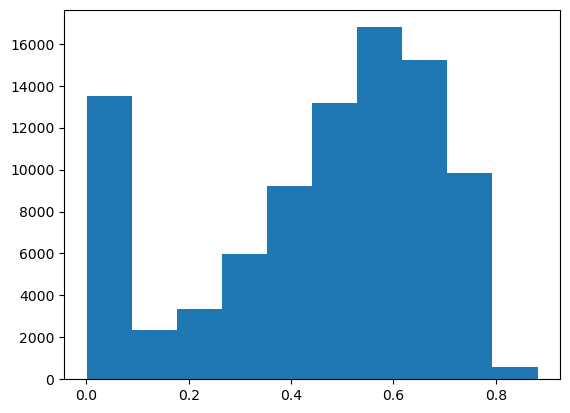

In [119]:
plt.hist(test_pred_total_mean)

In [120]:
sample_submission = pd.read_csv('/work/home/ybchae/aimers/aimers_data/sample_submission.csv')
sample_submission['probability'] = test_pred_total_mean

In [121]:
sample_submission.to_csv('/work/home/ybchae/aimers/aimers_data/Add_feature_reason2_lgbmcat_cpugpu.csv', index=False)